In [1]:
!pip install -r .\requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # Import FuncFormatter
import seaborn as sns
from pandas.api.types import CategoricalDtype
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
import geopandas as gpd
from scipy.stats import f_oneway
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from scipy.stats import shapiro, normaltest, anderson
from scipy.stats import boxcox
from matplotlib import font_manager as fm

# Introduction of the business problem

## Defining problem statement
House prices depend on various features beyond location and size, such as quality, condition, and renovations. 
This project aims to build a predictive model to estimate house prices using these features.

## Need for the Project
- Reduces uncertainty in determining fair property prices.
- Enables data-driven decision-making for buyers, sellers, and agents.
- Improves market efficiency and transparency.

## Business and Social Opportunities
### For Businesses:
- Real estate agencies can provide precise price recommendations.
- Developers and investors gain insights into pricing trends.
### For Society:
- Homeowners and buyers get fair, transparent pricing.
- Policymakers can craft affordable housing policies.

# Data Report

## How data was collected in terms of time, frequency and methodology?
### Data Collection Summary
#### Time
- Data spans from May 2, 2014, to May 27, 2015, with daily granularity.
- Transactions are timestamped but show no evidence of consistent hourly tracking.
#### Frequency
- Data collection is irregular, reflecting actual transaction events rather than a fixed schedule, i.e, every observation is a sale of a house.
- Peaks observed mid-year (summer months) and dips during year-end suggest seasonal market activity.
#### Methodology
- Data likely originates from real estate transactions, combining historical property records (e.g., year built, renovations) with market-driven details (e.g., price, location).
- Geographic identifiers (zip codes, latitude, longitude) and property attributes (size, condition, etc.) suggest integration of public and private datasets for comprehensive profiling.
- This combination of transactional and spatial data indicates a dynamic and event-driven collection process aimed at capturing real estate market behavior.

In [3]:
# Load and preprocess the data
file_path = '.\\data\\input\\innercity.xlsx'  # Replace with your file path
innercity_data = pd.read_excel(file_path)
innercity_data['dayhours'] = pd.to_datetime(innercity_data['dayhours'], format='%Y%m%dT%H%M%S', errors='coerce')
innercity_data.head().T

0                    1  \
cid                        3876100940           3145600250   
dayhours          2015-04-27 00:00:00  2015-03-17 00:00:00   
price                          600000               190000   
room_bed                          4.0                  2.0   
room_bath                        1.75                  1.0   
living_measure                 3050.0                670.0   
lot_measure                    9440.0               3101.0   
ceil                                1                    1   
coast                               0                    0   
sight                             0.0                  0.0   
condition                           3                    4   
quality                           8.0                  6.0   
ceil_measure                   1800.0                670.0   
basement                       1250.0                  0.0   
yr_built                         1966                 1948   
yr_renovated                        0                    0   
zipcode                         98034                98118   
lat                           47.7228              47.5546   
long                         -122.183             -122.274   
living_measure15               2020.0               1660.0   
lot_measure15                  8660.0               4100.0   
furnished                         0.0                  0.0   
total_area                      12490                 3771   

                                    2                    3  \
cid                        7129303070           7338220280   
dayhours          2014-08-20 00:00:00  2014-10-10 00:00:00   
price                          735000               257000   
room_bed                          4.0                  3.0   
room_bath                        2.75                  2.5   
living_measure                 3040.0               1740.0   
lot_measure                    2415.0               3721.0   
ceil                                2                    2   
coast                               1                    0   
sight                             4.0                  0.0   
condition                           3                    3   
quality                           8.0                  8.0   
ceil_measure                   3040.0               1740.0   
basement                          0.0                  0.0   
yr_built                         1966                 2009   
yr_renovated                        0                    0   
zipcode                         98118                98002   
lat                           47.5188              47.3363   
long                         -122.256             -122.213   
living_measure15               2620.0               2030.0   
lot_measure15                  2433.0               3794.0   
furnished                         0.0                  0.0   
total_area                       5455                 5461   

                                    4  
cid                        7950300670  
dayhours          2015-02-18 00:00:00  
price                          450000  
room_bed                          2.0  
room_bath                         1.0  
living_measure                 1120.0  
lot_measure                    4590.0  
ceil                                1  
coast                               0  
sight                             0.0  
condition                           3  
quality                           7.0  
ceil_measure                   1120.0  
basement                          0.0  
yr_built                         1924  
yr_renovated                        0  
zipcode                         98118  
lat                           47.5663  
long                         -122.285  
living_measure15               1120.0  
lot_measure15                  5100.0  
furnished                         0.0  
total_area                       5710

In [4]:
# 1. Time Analysis
date_range = innercity_data['dayhours'].min(), innercity_data['dayhours'].max()
print(f'The date range of the data is {date_range}')

The date range of the data is (Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))


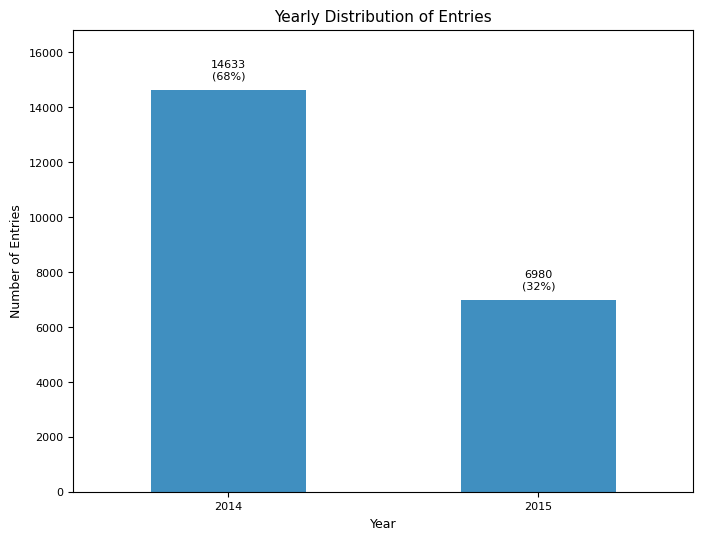

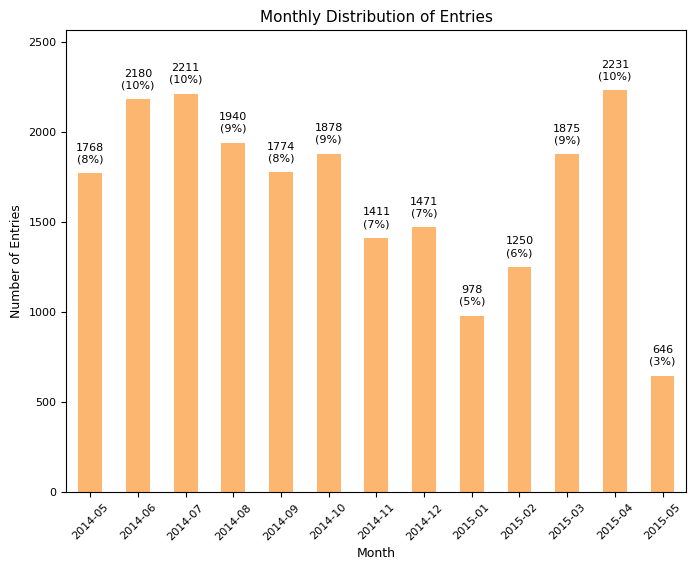

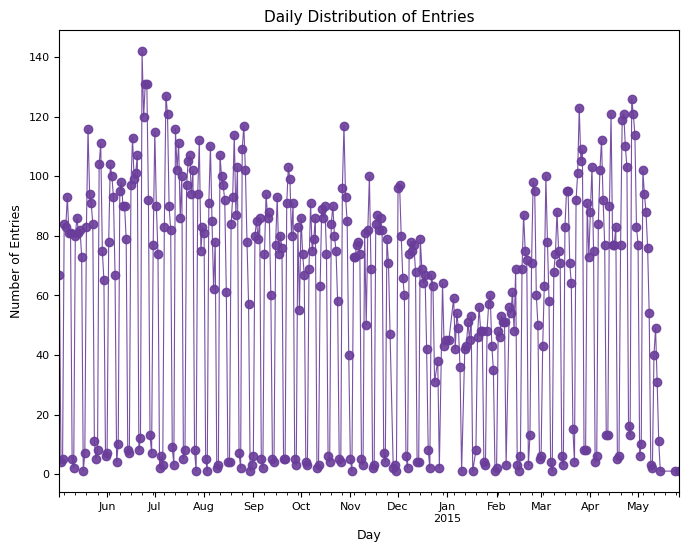

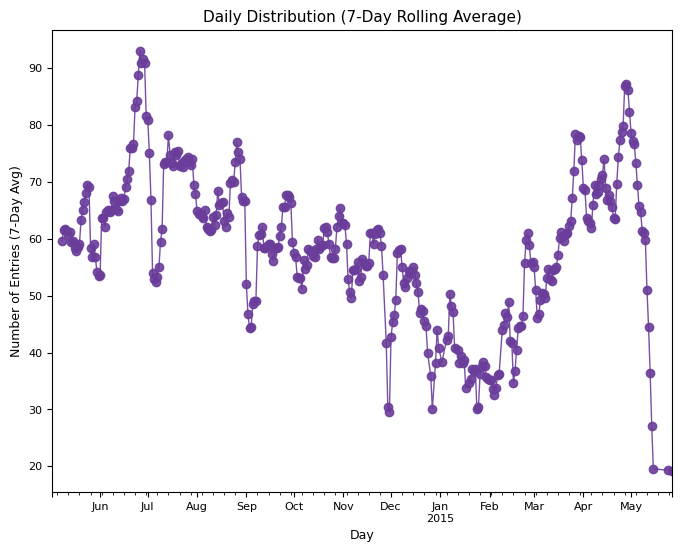

In [5]:
# Set global font to DejaVu Sans
plt.rcParams['font.family'] = 'DejaVu Sans'

# Define a high-contrast color palette
yearly_color = '#2b83ba'  # Muted dark blue
monthly_color = '#fdae61'  # Muted orange
daily_line_color = '#6a3d9a'  # Muted purple

# 1. Frequency Analysis
yearly_distribution = innercity_data['dayhours'].dt.year.value_counts().sort_index()
monthly_distribution = innercity_data['dayhours'].dt.to_period('M').value_counts().sort_index()
daily_distribution = innercity_data['dayhours'].dt.to_period('D').value_counts().sort_index()

# 2. Visualization: Yearly Distribution
plt.figure(figsize=(8, 6))
bars = yearly_distribution.plot(kind='bar', color=yearly_color, alpha=0.9)
plt.title('Yearly Distribution of Entries', fontsize=11, color='black')
plt.xlabel('Year', fontsize=9, color='black')
plt.ylabel('Number of Entries', fontsize=9, color='black')
plt.xticks(rotation=0, fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Adjust y-limit to add space for labels
y_max = yearly_distribution.max() * 1.15
plt.ylim(0, y_max)

# Adding labels with counts and percentages
total_entries = yearly_distribution.sum()
for bar, count in zip(bars.patches, yearly_distribution):
    percentage = (count / total_entries) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + y_max * 0.02,
             f'{count}\n({round(percentage)}%)', ha='center', va='bottom', fontsize=8, color='black')

plt.savefig(".\\images\\yearly_dist_a4.svg", format="svg", dpi=300)
plt.show()

# 3. Visualization: Monthly Distribution
plt.figure(figsize=(8, 6))
bars = monthly_distribution.plot(kind='bar', color=monthly_color, alpha=0.9)
plt.title('Monthly Distribution of Entries', fontsize=11, color='black')
plt.xlabel('Month', fontsize=9, color='black')
plt.ylabel('Number of Entries', fontsize=9, color='black')
plt.xticks(rotation=45, fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Adjust y-limit to add space for labels
y_max = monthly_distribution.max() * 1.15
plt.ylim(0, y_max)

# Adding labels with counts and percentages
total_entries = monthly_distribution.sum()
for bar, count in zip(bars.patches, monthly_distribution):
    percentage = (count / total_entries) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + y_max * 0.02,
             f'{count}\n({round(percentage)}%)', ha='center', va='bottom', fontsize=8, color='black')

plt.savefig(".\\images\\monthly_dist_a4.svg", format="svg", dpi=300)
plt.show()

# 4. Visualization: Daily Distribution
plt.figure(figsize=(8, 6))
daily_distribution.plot(kind='line', marker='o', linewidth=0.8, color=daily_line_color, alpha=0.9)
plt.title('Daily Distribution of Entries', fontsize=11, color='black')
plt.xlabel('Day', fontsize=9, color='black')
plt.ylabel('Number of Entries', fontsize=9, color='black')
plt.xticks(fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

plt.savefig(".\\images\\daily_dist_a4.svg", format="svg", dpi=300)
plt.show()

# 5. Visualization: Daily Distribution (7-Day Rolling Average)
daily_distribution_rolling = daily_distribution.rolling(window=7).mean()

plt.figure(figsize=(8, 6))
daily_distribution_rolling.plot(kind='line', marker='o', linewidth=1.0, color=daily_line_color, alpha=0.9)
plt.title('Daily Distribution (7-Day Rolling Average)', fontsize=11, color='black')
plt.xlabel('Day', fontsize=9, color='black')
plt.ylabel('Number of Entries (7-Day Avg)', fontsize=9, color='black')
plt.xticks(fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

plt.savefig(".\\images\\daily_dist_smoothed_a4.svg", format="svg", dpi=300)
plt.show()

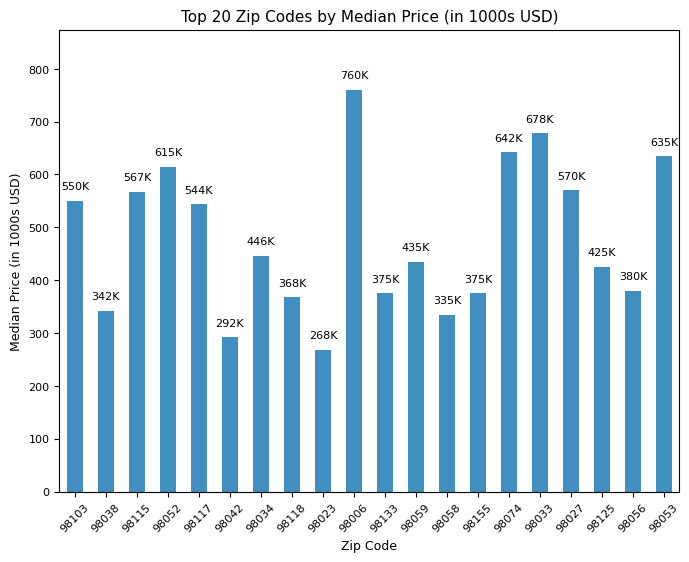

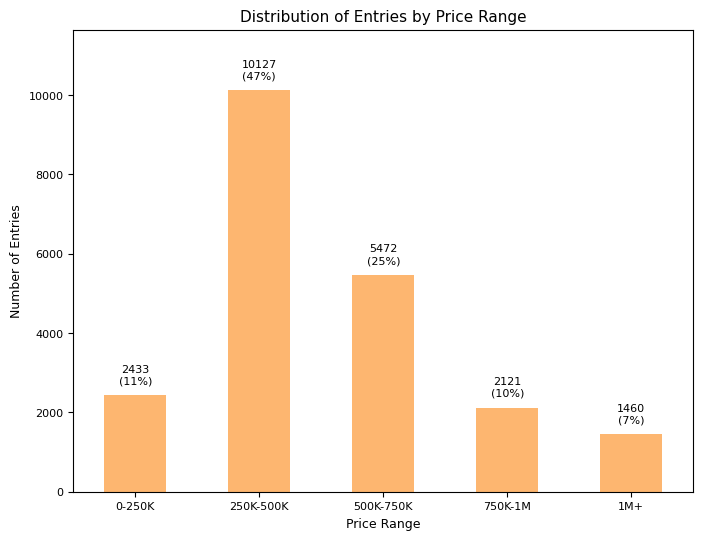

In [6]:
# Define a high-contrast color palette
zip_color = '#2b83ba'  # Muted dark blue
price_color = '#fdae61'  # Muted orange

# Methodology Insights
zip_code_stats = innercity_data.groupby('zipcode').agg(
    median_price=('price', 'median'),
    total_entries=('price', 'count'),
    mean_living_measure=('living_measure', 'median')
).sort_values(by='total_entries', ascending=False)

# Visualization: Top 20 Zip Codes by Median Price
plt.figure(figsize=(8, 6))  # Adjusted for A4 compatibility
bars = (zip_code_stats['median_price'] / 1000).head(20).plot(kind='bar', color=zip_color, alpha=0.9)
plt.title('Top 20 Zip Codes by Median Price (in 1000s USD)', fontsize=11, color='black')
plt.xlabel('Zip Code', fontsize=9, color='black')
plt.ylabel('Median Price (in 1000s USD)', fontsize=9, color='black')
plt.xticks(rotation=45, fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Adjust y-limit to add space for labels
y_max = (zip_code_stats['median_price'] / 1000).head(20).max() * 1.15
plt.ylim(0, y_max)

# Adding labels
for bar, value in zip(bars.patches, (zip_code_stats['median_price'] / 1000).head(20)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + y_max * 0.02,
             f'{value:.0f}K', ha='center', va='bottom', fontsize=8, color='black')

# Save with high DPI for quality
plt.savefig(".\\images\\top_zip_a4.svg", format="svg", dpi=300)
plt.show()

# Price Distribution
price_bins = pd.cut(innercity_data['price'], bins=[0, 250000, 500000, 750000, 1000000, float('inf')],
                    labels=['0-250K', '250K-500K', '500K-750K', '750K-1M', '1M+'])
price_distribution = price_bins.value_counts().sort_index()

plt.figure(figsize=(8, 6))  # Adjusted for A4 compatibility
bars = price_distribution.plot(kind='bar', color=price_color, alpha=0.9)
plt.title('Distribution of Entries by Price Range', fontsize=11, color='black')
plt.xlabel('Price Range', fontsize=9, color='black')
plt.ylabel('Number of Entries', fontsize=9, color='black')
plt.xticks(rotation=0, fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Adjust y-limit to add space for labels
y_max = price_distribution.max() * 1.15
plt.ylim(0, y_max)

# Adding labels
total_entries = price_distribution.sum()
for bar, count in zip(bars.patches, price_distribution):
    percentage = (count / total_entries) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + y_max * 0.02,
             f'{count}\n({round(percentage)}%)', ha='center', va='bottom', fontsize=8, color='black')

# Save with high DPI for quality
plt.savefig(".\\images\\price_dist_a4.svg", format="svg", dpi=300)
plt.show()

## Visual inspection of data (rows, columns, descriptive details
#### Rows and Columns
- The data has 21613 Rows/Observations and 23 Columns/Features.

#### Descriptive Details
##### Price:
- The average price is approximately USD 540,000, with a wide range from USD 75,000 to USD 7.7 million
- A significant skew toward lower property prices, but with a tail indicating high-value luxury properties

##### Living Measure:
- The average living area is about 2,080 sq. ft., with properties ranging from 370 sq. ft. to 13,540 sq. ft.
- Most properties fall under 3,000 sq. ft., with a few outliers for larger properties
##### Lot Measure:
- The average lot size is 15,200 sq. ft., but values range from very small lots (520 sq. ft.) to expansive estates (1.65 million sq. ft.)
- A small percentage of properties have exceptionally large lots, creating a heavy-tailed distribution
##### Bedrooms and Bathrooms:
- Most properties have between 2 to 4 bedrooms, with an average of 3 bedrooms
- Bathrooms range from 1 to 8, with an average of 2.5 bathrooms
##### Condition and Quality:
- Property conditions are rated from 1 (Poor) to 5 (Excellent), with the majority clustered around 3 (Average)
- Quality scores (on a scale from 1 to 13) average around 7-8, reflecting good build quality
#### Missing Values:
##### Notable columns with missing values include:
- living_measure15: 166 missing values (0.77% of total rows)
- room_bed and room_bath: 108 missing values each (0.50% of total rows)
##### Other Affected Columns
- Moderate missing data in sight and condition (57 missing each, 0.26%)
- Smaller gaps in lot_measure, ceil, and total_area (~0.19% - 0.13%)
- Minimal missing data in basement, quality, and coast (~0.005%)
##### Other incorrect values
- There are also values of '$' which are incorrect and will set these to 'NaN'
##### Distribution:
- Missing data is sporadic and column-specific, affecting only a subset of features
- No strong row-level patterns detected, as visualized in the heatmap

In [7]:
print(f'The data has {innercity_data.shape[0]} Rows/Observations and {innercity_data.shape[1]} Columns/Features')


The data has 21613 Rows/Observations and 23 Columns/Features


In [8]:
summary_stats = innercity_data[['price', 'living_measure', 'lot_measure', 'room_bed', 'room_bath']].describe()
summary_stats_rounded = summary_stats.map(lambda x: f"{int(round(x)):,}" if pd.notnull(x) else "N/A")
print("Descriptive Statistics Summary:")
print(summary_stats_rounded)

Descriptive Statistics Summary:
           price living_measure lot_measure room_bed room_bath
count     21,613         21,596      21,571   21,505    21,505
mean     540,182          2,080      15,105        3         2
std      367,362            918      41,424        1         1
min       75,000            290         520        0         0
25%      321,950          1,429       5,040        3         2
50%      450,000          1,910       7,618        3         2
75%      645,000          2,550      10,684        4         2
max    7,700,000         13,540   1,651,359       33         8


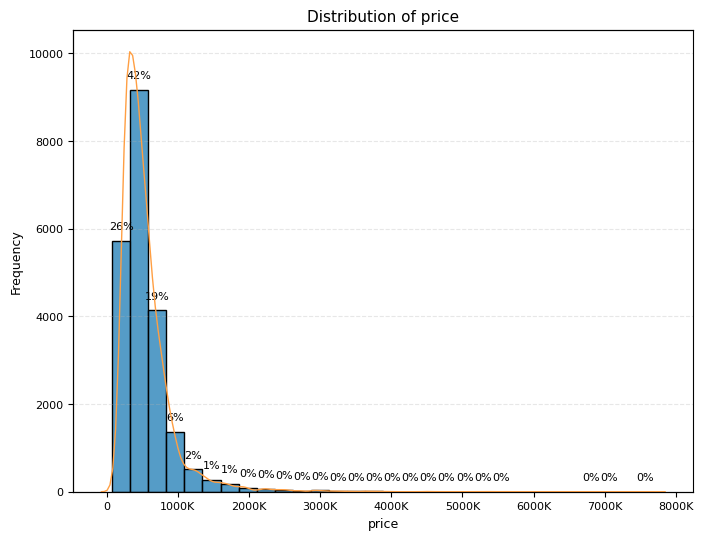

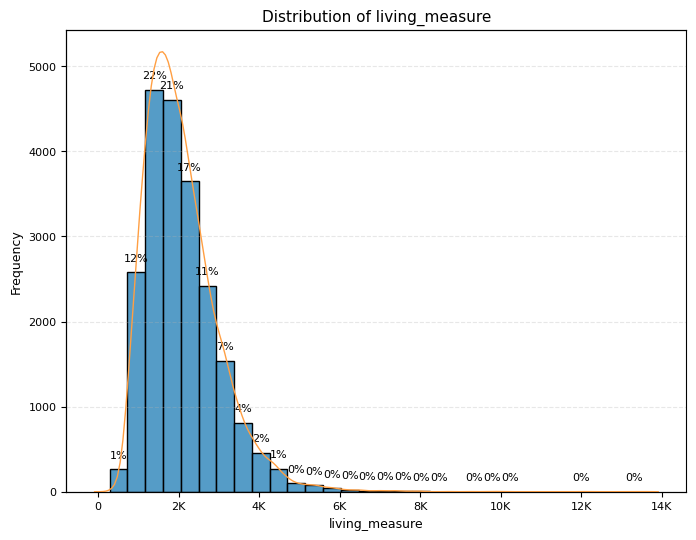

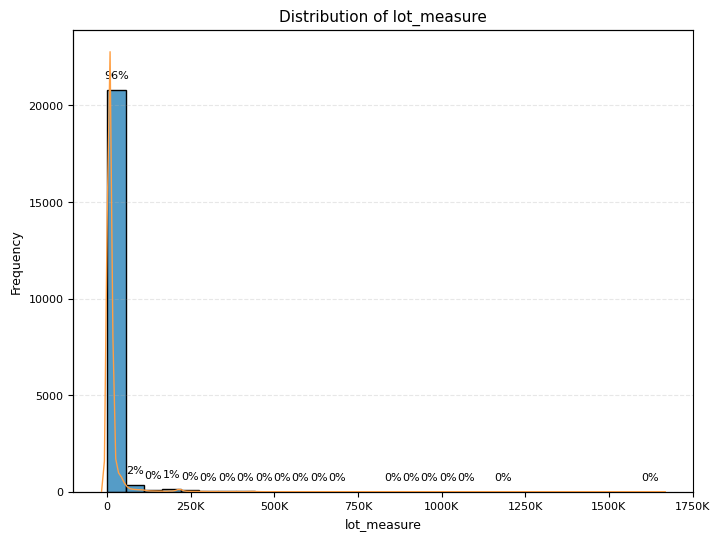

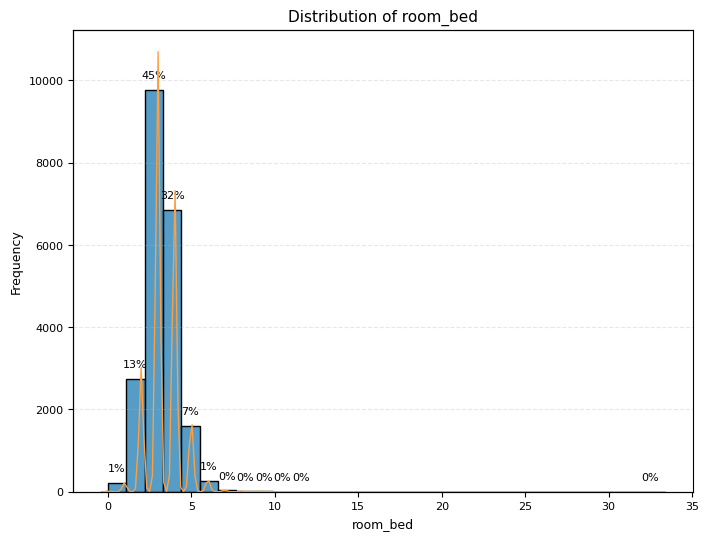

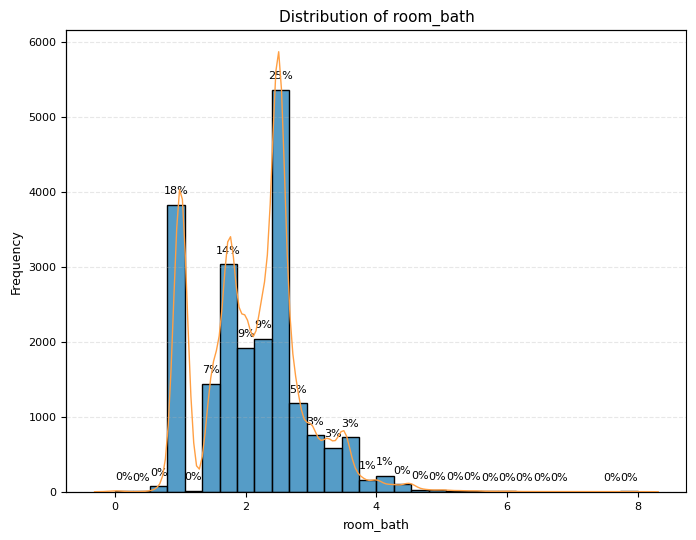

In [9]:
# Define colors
hist_color = '#2b83ba'  # Muted dark blue
kde_color = '#ff9f43'   # Muted orange

# Distribution Plots for Key Numerical Columns
numerical_columns = ['price', 'living_measure', 'lot_measure', 'room_bed', 'room_bath']
for column in numerical_columns:
    fig, ax1 = plt.subplots(figsize=(8, 6))
    data = innercity_data[column].dropna()

    # Plot histogram on the primary y-axis
    sns.histplot(data, bins=30, color=hist_color, alpha=0.8, kde=False, ax=ax1)
    ax1.set_title(f'Distribution of {column}', fontsize=11, color='black')
    ax1.set_xlabel(column, fontsize=9, color='black')
    ax1.set_ylabel('Frequency', fontsize=9, color='black')
    ax1.tick_params(axis='x', labelsize=8, colors='black')
    ax1.tick_params(axis='y', labelsize=8, colors='black')

    # Adjust y-limit to add space for labels
    y_max = max([bar.get_height() for bar in ax1.patches]) * 1.15  # Add 15% extra space above the tallest bar
    ax1.set_ylim(0, y_max)

    # Add percentage labels to bars
    total_entries = len(data)
    for bar in ax1.patches:
        height = bar.get_height()
        if height > 0:
            percentage = (height / total_entries) * 100
            ax1.text(bar.get_x() + bar.get_width() / 2, height + y_max * 0.02,
                     f'{round(percentage)}%', ha='center', va='bottom', fontsize=8, color='black')

    # Format x-axis with human-readable scales
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1000:.0f}K' if x >= 1000 else f'{x:,.0f}'))

    # Add gridlines with reduced alpha
    ax1.grid(axis='y', linestyle='--', alpha=0.3)

    # Plot KDE on the secondary y-axis
    ax2 = ax1.twinx()
    sns.kdeplot(data, color=kde_color, linewidth=1, ax=ax2)

    # Completely disable the secondary y-axis
    ax2.get_yaxis().set_visible(False)  # Fully disable secondary y-axis rendering
    ax2.spines['right'].set_visible(False)  # Hide the secondary y-axis spine

    # Save and show plot
    plt.savefig(f".\\images\\Dist_{column}.svg", format="svg", dpi=300)
    plt.show()

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


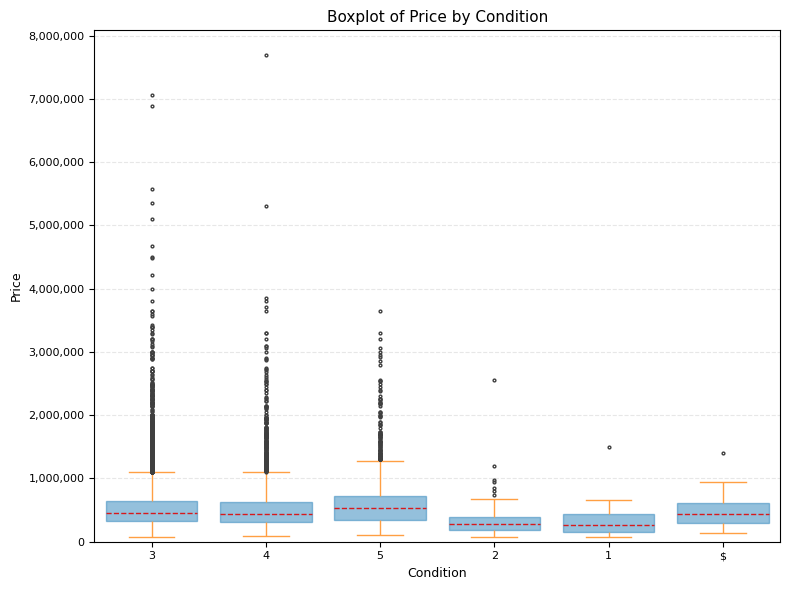

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


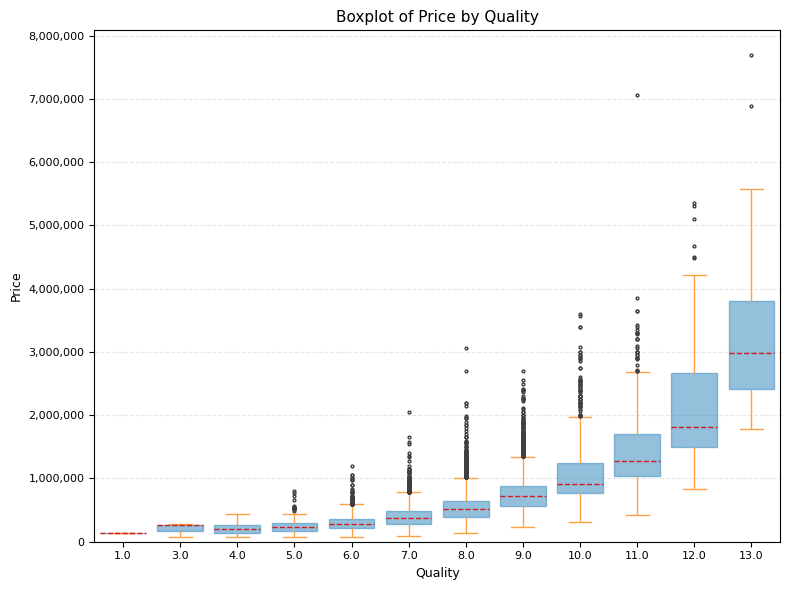

In [10]:
# Define colors
box_color = '#2b83ba'  # Muted dark blue for boxplots
line_color = '#ff9f43'  # Muted orange for whiskers and lines
median_color = '#d7191c'  # Muted red for median line

# Helper function to format axis labels in non-scientific notation
def format_non_scientific(x, pos):
    return f"{int(x):,}"

# Boxplot of Price by Condition
plt.figure(figsize=(8, 6))  # Adjusted figure size
sns.boxplot(
    data=innercity_data,
    x='condition',
    y='price',
    boxprops=dict(color=box_color, facecolor=box_color, alpha=0.5, linewidth=1),  # Box color and line width
    whiskerprops=dict(color=line_color, linewidth=1),  # Whisker color and line width
    capprops=dict(color=line_color, linewidth=1),  # Cap color and line width
    medianprops=dict(color=median_color, linestyle='--', linewidth=1),  # Median line (red, dashed, 1-width)
    flierprops=dict(marker='o', markersize=2, color='black', linestyle='none')  # Outliers as small black dots
)
plt.title('Boxplot of Price by Condition', fontsize=11, color='black')
plt.xlabel('Condition', fontsize=9, color='black')
plt.ylabel('Price', fontsize=9, color='black')
plt.xticks(fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3)  # Subtle gridlines

# Adjust y-limits for better visibility
y_max = innercity_data['price'].max() * 1.05
plt.ylim(0, y_max)

# Apply non-scientific notation to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_non_scientific))

plt.tight_layout()  # Ensure the plot fits well
plt.savefig(f".\\images\\box_price_condition.svg", format="svg", dpi=300)
plt.show()

# Boxplot of Price by Quality
plt.figure(figsize=(8, 6))  # Adjusted figure size
sns.boxplot(
    data=innercity_data,
    x='quality',
    y='price',
    boxprops=dict(color=box_color, facecolor=box_color, alpha=0.5, linewidth=1),  # Box color and line width
    whiskerprops=dict(color=line_color, linewidth=1),  # Whisker color and line width
    capprops=dict(color=line_color, linewidth=1),  # Cap color and line width
    medianprops=dict(color=median_color, linestyle='--', linewidth=1),  # Median line (red, dashed, 1-width)
    flierprops=dict(marker='o', markersize=2, color='black', linestyle='none')  # Outliers as small black dots
)
plt.title('Boxplot of Price by Quality', fontsize=11, color='black')
plt.xlabel('Quality', fontsize=9, color='black')
plt.ylabel('Price', fontsize=9, color='black')
plt.xticks(fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')
plt.grid(axis='y', linestyle='--', alpha=0.3)  # Subtle gridlines

# Adjust y-limits for better visibility
y_max = innercity_data['price'].max() * 1.05
plt.ylim(0, y_max)

# Apply non-scientific notation to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_non_scientific))

plt.tight_layout()  # Ensure the plot fits well
plt.savefig(f".\\images\\box_price_quality.svg", format="svg", dpi=300)
plt.show()


In [11]:
# 1. Missing values count for each column
missing_values = innercity_data.isnull().sum()
print(missing_values.sort_values(ascending=False))
dollar_counts = innercity_data.apply(lambda col: col.astype(str).str.count(r'\$').sum())
print(dollar_counts.sort_values(ascending=False))

living_measure15    166
room_bath           108
room_bed            108
condition            57
sight                57
ceil                 42
lot_measure          42
furnished            29
lot_measure15        29
total_area           29
living_measure       17
yr_built              1
basement              1
ceil_measure          1
coast                 1
quality               1
dayhours              0
price                 0
cid                   0
long                  0
lat                   0
zipcode               0
yr_renovated          0
dtype: int64
total_area          39
long                34
ceil                30
coast               30
condition           28
yr_built            14
cid                  0
lot_measure          0
living_measure       0
room_bath            0
room_bed             0
price                0
dayhours             0
sight                0
quality              0
basement             0
ceil_measure         0
zipcode              0
yr_renovated         

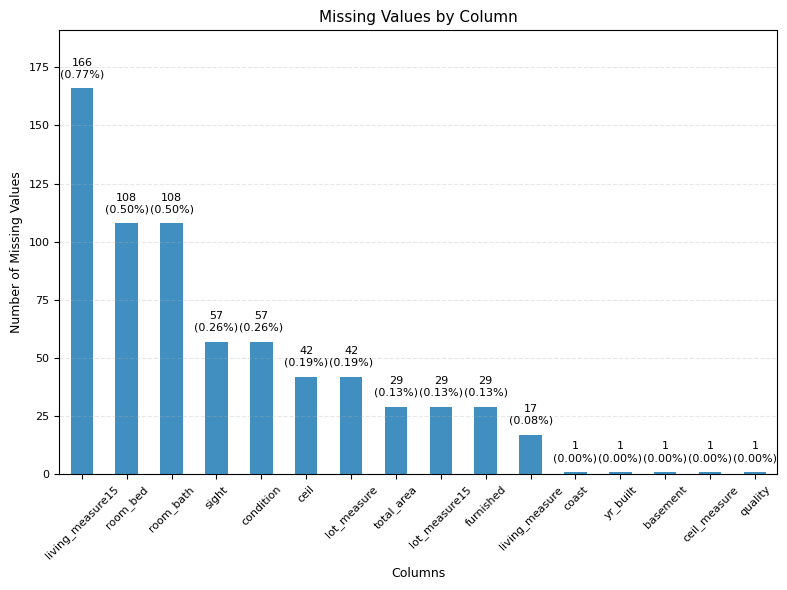

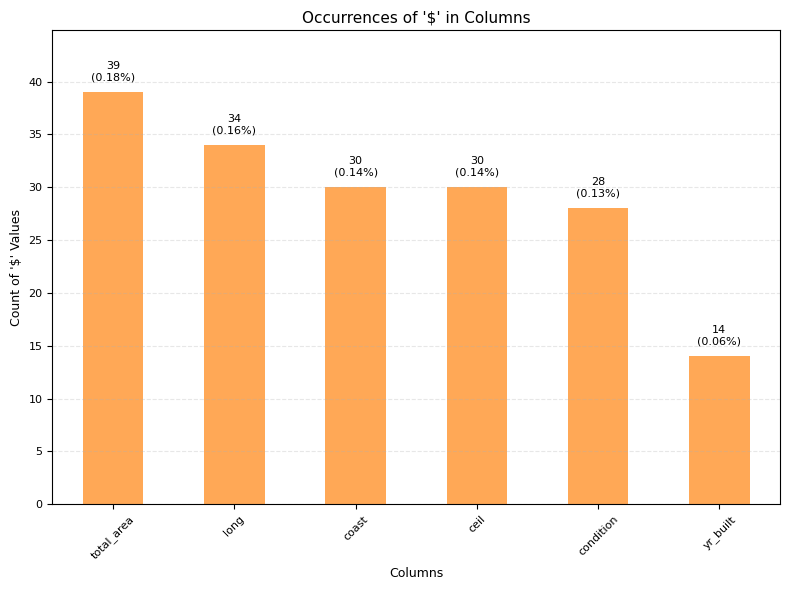

In [12]:
missing_columns = missing_values[missing_values > 0].sort_values(ascending=False)
dollar_counts_filtered = dollar_counts[dollar_counts > 0].sort_values(ascending=False)

# Visualization: Missing Values by Column
plt.figure(figsize=(8, 6))  # Consistent figure size
bars = missing_columns.plot(kind='bar', color='#2b83ba', alpha=0.9)  # Muted dark blue for bars
plt.title('Missing Values by Column', fontsize=11, color='black')
plt.xlabel('Columns', fontsize=9, color='black')
plt.ylabel('Number of Missing Values', fontsize=9, color='black')
plt.xticks(rotation=45, fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Adjust y-limit to avoid label overlap
y_max = missing_columns.max() * 1.15
plt.ylim(0, y_max)

# Add count labels and percentage annotations
total_records = innercity_data.shape[0]
for bar, count in zip(bars.patches, missing_columns):
    percentage = (count / total_records) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + y_max * 0.02,
             f'{count}\n({percentage:.2f}%)', ha='center', va='bottom', fontsize=8, color='black')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Save and show plot
plt.tight_layout()
plt.savefig(".\\images\\missing_values.svg", format="svg", dpi=300)
plt.show()

# Visualization: Occurrences of '$' in Columns
plt.figure(figsize=(8, 6))  # Consistent figure size
bars = dollar_counts_filtered.plot(kind='bar', color='#ff9f43', alpha=0.9)  # Muted orange for bars
plt.title("Occurrences of '$' in Columns", fontsize=11, color='black')
plt.xlabel('Columns', fontsize=9, color='black')
plt.ylabel("Count of '$' Values", fontsize=9, color='black')
plt.xticks(rotation=45, fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Adjust y-limit to avoid label overlap
y_max = dollar_counts_filtered.max() * 1.15
plt.ylim(0, y_max)

# Add count labels and percentage annotations
total_records = innercity_data.shape[0]
for bar, count in zip(bars.patches, dollar_counts_filtered):
    percentage = (count / total_records) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + y_max * 0.02,
             f'{count}\n({percentage:.2f}%)', ha='center', va='bottom', fontsize=8, color='black')

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Save and show plot
plt.tight_layout()
plt.savefig(".\\images\\dollar_values.svg", format="svg", dpi=300)
plt.show()

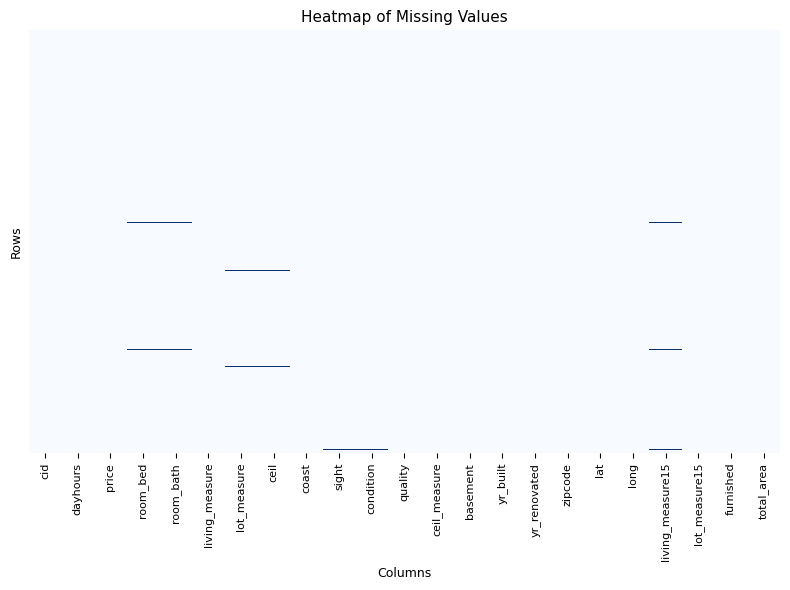

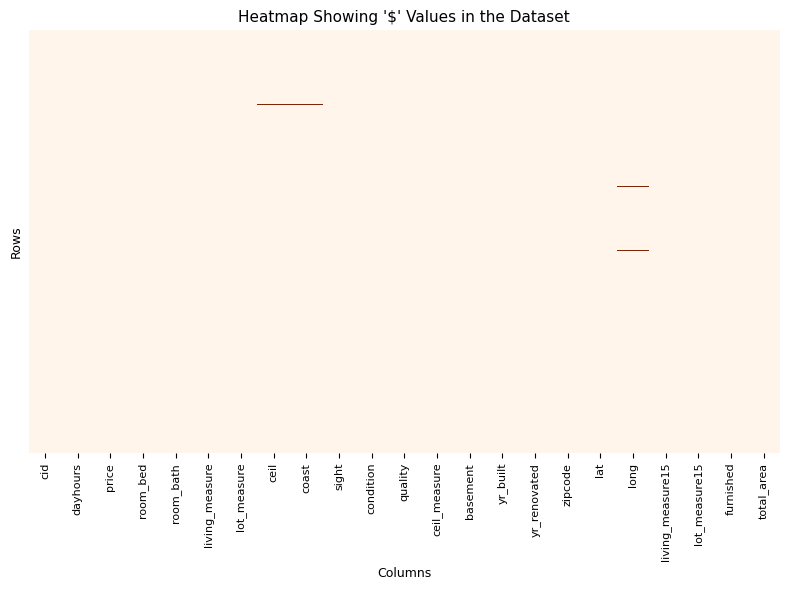

In [13]:
# 1. Heatmap of Missing Values
plt.figure(figsize=(8, 6))  # Consistent figure size
sns.heatmap(innercity_data.isnull(), cbar=False, cmap='Blues', yticklabels=False)  # Disabled row index labels
plt.title('Heatmap of Missing Values', fontsize=11, color='black')
plt.xlabel('Columns', fontsize=9, color='black')
plt.ylabel('Rows', fontsize=9, color='black')
plt.xticks(fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Save and show plot
plt.tight_layout()
plt.savefig(".\\images\\heatmap_missing_values.svg", format="svg", dpi=300)
plt.show()

# 2. Heatmap for '$' Values
# Create a boolean DataFrame indicating where values are '$'
dollar_mask = innercity_data.apply(lambda col: col.astype(str).str.contains(r'\$', na=False))

plt.figure(figsize=(8, 6))  # Consistent figure size
sns.heatmap(dollar_mask, cbar=False, cmap='Oranges', yticklabels=False)  # Disabled row index labels
plt.title("Heatmap Showing '$' Values in the Dataset", fontsize=11, color='black')
plt.xlabel("Columns", fontsize=9, color='black')
plt.ylabel("Rows", fontsize=9, color='black')
plt.xticks(fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')

# Save and show plot
plt.tight_layout()
plt.savefig(".\\images\\heatmap_dollar_values.svg", format="svg", dpi=300)
plt.show()

## Understanding of attributes (variable info, renaming if required)
### Attributes, Descriptions, and Recommendations

| **Attribute**        | **Description**                                              | **Recommendation for rename**                                    | **Recommended Datatypes**
|-----------------------|--------------------------------------------------------------|------------------------------------------------------|---------------------------|
| `cid`                | A notation for a house.                                      | Retain as **house_id** for improved clarity.            | **index** **String**
| `dayhours`           | Date house was sold.                                         | Rename to **sale_date** for clarity and uniformity.      | **index** **Datetime**
| `price`              | Price is the prediction target.                              | Retain as is, since it is clear and meaningful.      | **Float**
| `room_bed`           | Number of bedrooms in the house.                             | Rename to **num_bedrooms_per_house** for clarity and consistency.  | **Integer**/
| `room_bath`          | Number of bathrooms per bedroom.                             | Rename to **num_bathrooms_per_bedroom**.                             |**Float**
| `living_measure`     | Square footage of the home.                                  | Rename to **living_area_sqft**.                          |**Float**
| `lot_measure`        | Square footage of the lot.                                   | Rename to **lot_area_sqft**.                             |**Float**
| `ceil`               | Total floors (levels) in the house.                          | Rename to **num_floors**.                                |**Float**
| `coast`              | House which has a view to a waterfront.                      | Rename to **waterfront_view** (0 for no, 1 for yes).     | **Integer**
| `sight`              | Has been viewed.                                             | Rename to **views**.        | **Integer**
| `condition`          | How good the condition is (Overall).                         | Retain as is; it is clear and meaningful.            |**Integer**
| `quality`            | Grade given to the housing unit, based on a grading system.  | Rename to **construction_grade** for clarity.            |**Integer**
| `ceil_measure`       | Square footage of the house apart from the basement.         | Rename to **above_ground_area_sqft**.                    |**Float**
| `basement_measure`   | Square footage of the basement.                              | Rename to **basement_area_sqft**.                        |**Float**
| `yr_built`           | Built year.                                                  | Retain as **year_built**.                                |**Integer**
| `yr_renovated`       | Year when the house was renovated.                           | Retain as **year_renovated**.                            |**Integer**
| `zipcode`            | Zip code of the house location.                              | Retain as is.                                        |**String**
| `lat`                | Latitude coordinate.                                         | Retain as **Latitude**.                                        |**Float**
| `long`               | Longitude coordinate.                                        | Retain as is **Longitude**.                                        |**Float**
| `living_measure15`   | Living room area in 2015 (implies some renovations).         | Rename to **living_area_2015_sqft**.                     |**Float**
| `lot_measure15`      | Lot size area in 2015 (implies some renovations).            | Rename to **lot_area_2015_sqft**.                        |**Float**
| `furnished`          | Based on the quality of the room.                            | Retain as is.                                        |**Integer**
| `total_area`         | Measure of both living and lot areas.                        | Retain as is.                                        |**Float**

# Exploratory Data Analysis

In [14]:
# Replace blank strings, errors like '$', and other placeholders with NaN
innercity_data.replace(['', ' ', '$', 'NaN', 'nan', None], np.nan, inplace=True)

# Renaming the columns
column_renaming = {
    "cid": "house_id",
    "dayhours": "sale_date",
    "price": "price",
    "room_bed": "num_bedrooms_per_house",
    "room_bath": "num_bathrooms_per_bedroom",
    "living_measure": "living_area_sqft",
    "lot_measure": "lot_area_sqft",
    "ceil": "num_floors",
    "coast": "waterfront_view",
    "sight": "views",
    "condition": "condition",
    "quality": "construction_grade",
    "ceil_measure": "above_ground_area_sqft",
    "basement": "basement_area_sqft",
    "yr_built": "year_built",
    "yr_renovated": "year_renovated",
    "zipcode": "zipcode",
    "lat": "latitude",
    "long": "longitude",
    "living_measure15": "living_area_2015_sqft",
    "lot_measure15": "lot_area_2015_sqft",
    "furnished": "furnished",
    "total_area": "total_area"
}
innercity_data.rename(columns=column_renaming, inplace=True)

C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\1845363803.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  innercity_data.replace(['', ' ', '$', 'NaN', 'nan', None], np.nan, inplace=True)


In [15]:
#adding has_basement flag columns
innercity_data['has_basement'] = innercity_data['basement_area_sqft'].apply(lambda x: 0 if pd.isnull(x) else (1 if x > 0 else 0))

In [16]:
# Setting the data types as per recommendations while taking care not to change missing or incorrect values
data_types = {
    "house_id": "category",
    "price": "float64",
    "num_bedrooms_per_house": "Int64",  # Nullable integer for missing values
    "num_bathrooms_per_bedroom": "float64",
    "living_area_sqft": "float64",
    "lot_area_sqft": "float64",
    "num_floors": "category",
    "waterfront_view": "category",  # Binary as integer (0/1)
    "views": "category",
    "condition": "category",
    "construction_grade": "category",
    "above_ground_area_sqft": "float64",
    "basement_area_sqft": "float64",
    "year_built": "category",
    "year_renovated": "category",
    "zipcode": "category",
    "latitude": "float64",
    "longitude": "float64",
    "living_area_2015_sqft": "float64",
    "lot_area_2015_sqft": "float64",
    "furnished": "category",  # Binary as integer (0/1)
    "total_area": "float64",
    "has_basement": "category"
}

# Convert the columns to the specified data types
innercity_data = innercity_data.astype(data_types)

# Display the updated DataFrame info
innercity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21505 non-null  Int64         
 4   num_bathrooms_per_bedroom  21505 non-null  float64       
 5   living_area_sqft           21596 non-null  float64       
 6   lot_area_sqft              21571 non-null  float64       
 7   num_floors                 21541 non-null  category      
 8   waterfront_view            21582 non-null  category      
 9   views                      21556 non-null  category      
 10  condition                  21528 non-null  category      
 11  construction_grade         21612 non-null  category      
 12  abov

In [17]:
innercity_data['num_bedrooms_per_house'].value_counts()

num_bedrooms_per_house
3     9767
4     6854
2     2747
5     1595
6      270
1      197
7       38
8       13
0       13
9        6
10       3
33       1
11       1
Name: count, dtype: Int64

In [18]:
# Define meaningful bins or categories
floors_order = [1, 1.5, 2, 2.5, 3, 3.5]  # Based on possible values
water_front_view_order = [0,1]
views_order = [0,1, 2, 3, 4, 5] # Assuming 0=Poor to 5=Excellent
condition_order = [1, 2, 3, 4, 5]  # Assuming 1=Poor to 5=Excellent
construction_grade_order = list(range(1, 14))  # Assuming grades 1 to 13 
furnished_order = [0,1]
has_basement_order = [0,1]                

# Create CategoricalDtype for each ordinal variable
floors_dtype = CategoricalDtype(categories=floors_order, ordered=True)
water_front_view_dtype = CategoricalDtype(categories=water_front_view_order, ordered=True)
views_dtype = CategoricalDtype(categories=views_order, ordered=True)
condition_dtype = CategoricalDtype(categories=condition_order, ordered=True)
construction_grade_dtype = CategoricalDtype(categories=construction_grade_order, ordered=True)
furnished_dtype = CategoricalDtype(categories=furnished_order, ordered=True)
has_basement_dtype = CategoricalDtype(categories=has_basement_order, ordered=True)


# Convert columns to ordinal categorical
innercity_data['num_floors'] = innercity_data['num_floors'].astype(floors_dtype)
innercity_data['waterfront_view'] = innercity_data['waterfront_view'].astype(water_front_view_dtype)
innercity_data['views'] = innercity_data['views'].astype(views_dtype)
innercity_data['condition'] = innercity_data['condition'].astype(condition_dtype)
innercity_data['construction_grade'] = innercity_data['construction_grade'].astype(construction_grade_dtype)
innercity_data['furnished'] = innercity_data['furnished'].astype(furnished_dtype)
innercity_data['has_basement'] = innercity_data['has_basement'].astype(has_basement_dtype)

innercity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21505 non-null  Int64         
 4   num_bathrooms_per_bedroom  21505 non-null  float64       
 5   living_area_sqft           21596 non-null  float64       
 6   lot_area_sqft              21571 non-null  float64       
 7   num_floors                 21541 non-null  category      
 8   waterfront_view            21582 non-null  category      
 9   views                      21556 non-null  category      
 10  condition                  21528 non-null  category      
 11  construction_grade         21612 non-null  category      
 12  abov

## Univariate analysis (distribution and spread for every continuous attribute, distribution of data in categories for categorical ones) 
### Continous Variables
#### Price
- Mean: USD 540K Median: USD 450K
- Max: USD 7.7M Min: USD 75K
- High Variance ~USD 367K 
- 25% below USD 321K and 75% below USD 645K
- Distribution: Skewed toward higher values due to the large max value.
#### num_bedrooms_per_house
- Mean: 3.3 Bedrooms Median: 3 Bedrooms
- Max: 33 Bedrooms Min: 0 Bedrooms
- Low Variance around the mean
- 25% below 5 and 75% below 4 Bedrooms
- Distribution: Highly concentrated around 3-4 bedrooms, with outliers like 33 bedrooms.
#### num_bathrooms_per_bedroom
- Mean: ~2K Bathrooms/Bedroom Median:2.25 Bathrooms/Bedroom
- Max: 8 Bathrooms/Bedroom Min: 0 Bathrooms/Bedroom
- Low Variance around the mean
- 25% below 1.75 and 75% below 2.5 Bathrooms/Bedroom
- Distribution: Concentrated around 2 bathrooms per bedroom
#### living_area_sqrt
- Mean: 2K Sqrt Median:1.9 Sqrt
- Max: 13K Sqrt Min: 520 Sqrt
- High Variance
- 25% below 1.4K and 75% below 2.5K Sqrt
- Distribution: Skewed toward larger houses.
#### lot_area_sqrt
- Mean: 1.5K Sqrt Median:7.6K Sqrt
- Max: 1.6M Sqrt Min: 290 Sqrt
- extremely high variability
- 25% below 5K and 75% below 10.6K Sqrt
- Distribution: Highly skewed due to large outliers.
#### above_ground_area_sqrt
- Mean: 1.7K Sqrt Median: 1.5K Sqrt
- Max: 9.4K Sqrt Min: 290 Sqrt
- high variability
- 25% below 1.19K and 75% below 2.2K Sqrt
- Distribution: Concentrated around 1,560–2,210 sq ft.
#### basement_area_sqrt
- Mean: 291 Sqrt Median: 0 Sqrt
- Max: 4K Sqrt Min: 0 Sqrt
-  high variability
- 25% is at 0K and 75% below 560 Sqrt
- Distribution: Most houses have small or no basements.
#### living_area_2015_sqrt
- Mean: 1.9K Sqrt Median: 1.8K Sqrt
- Max: 6K Sqrt Min: 399 Sqrt
-  high variability
- 25% below 1.4K and 75% below 2.3K Sqrt
- Distribution: Most houses have living areas between 1,490–2,360 sq ft.
#### lot_area_2015_sqrt
- Mean: 12K Sqrt Median: 7.6K Sqrt
- Max: 871K Sqrt Min: 651 Sqrt
-  extremely high variability
- 25% below 5.1K and 75% below 10K Sqrt
- Distribution: Skewed due to large outliers.
#### total_area
- Mean: 17K Sqrt Median: 9K Sqrt
- Max: 1.6M Sqrt Min: 1.4K Sqrt
-  extremely high variability
- 25% below 7K and 75% below 13K Sqrt
- Distribution: Skewed toward larger total areas.
### Catigorical Variables
#### num_floors
- 6 unique values : 1,1.5,2,2.5,3,3.5
- Counts: {1.0: 10647, 2.0: 8210, 1.5: 1905, 3.0: 610, 2.5: 161, 3.5: 8}
- Percentage Distribution: {1.0: 49.262, 2.0: 37.986, 1.5: 8.814, 3.0: 2.822, 2.5: 0.745, 3.5: 0.037}
- Mode: 1.0
#### waterfront_view
- 2 unique values
- Counts: {0: 21421, 1: 161}
- Percentage Distribution: {0: 99.112, 1: 0.745}
- Mode: 0
#### views
- 4 uniques values : 1,2,3,4
- Counts: {0: 19437, 2: 959, 3: 510, 1: 332, 4: 318, 5: 0}
- Percentage Distribution: {0: 89.932, 2: 4.437, 3: 2.36, 1: 1.536, 4: 1.471, 5: 0.0}
- Mode: 0
#### condition
- 5 unique values : 1,2,3,4,5
- Counts: {3: 13978, 4: 5655, 5: 1694, 2: 171, 1: 30}
- Percentage Distribution: {3: 64.674, 4: 26.165, 5: 7.838, 2: 0.791, 1: 0.139}
- Mode: 3
#### construction_grade
- 14 unique values : 0 to 13
- Counts: {7: 8981, 8: 6067, 9: 2615, 6: 2038, 10: 1134, 11: 399, 5: 242, 12: 90, 4: 29, 13: 13, 3: 3, 1: 1, 2: 0}
- Percentage Distribution: {7: 41.554, 8: 28.071, 9: 12.099, 6: 9.43, 10: 5.247, 11: 1.846, 5: 1.12, 12: 0.416, 4: 0.134, 13: 0.06, 3: 0.014, 1: 0.005, 2: 0.0}
- Mode: 7
#### furnished
- 2 unique values
- Counts: {0: 17338, 1: 4246}
- Percentage Distribution: {0: 80.22, 1: 19.646}
- Mode: 0
#### Sales Date Distribution
##### Yearly Distribution:
- Dominant Year: 2014
- Max Count: 14,633 sales
- Max Percentage: 67.70% of total sales
- Trend: Sales peaked in 2014, making up more than two-thirds of total transactions.
- ##### Monthly Distribution:
- Dominant Month: May
- Max Count: 2,414 sales
- Max Percentage: 11.17% of total sales
- Trend: May had the highest sales activity among months, contributing over 11% of total transactions.
##### Weekly Distribution:
- Dominant Week: Week 19
- Max Count: 848 sales
- Max Percentage: 3.92% of total sales
- Trend: Sales were concentrated in Week 19, which saw the highest weekly activity.
##### Daily Distribution:
- Dominant Day: Tuesday
- Max Count: 4,715 sales
- Max Percentage: 21.82% of total sales
- Trend: Tuesdays were the most active day, with nearly 22% of all transactions occurring on this day.
#### Geolocation and Categorical Year variables
##### Year Built
- Mode Year: 2014 (most frequent year for construction).
- Median Year: 1975 (indicates half the properties were built before 1975).
- Top 3 Peak Years:
    - 2014: 559 properties.
    - 2006: 454 properties.
    - 2005: 450 properties.
- Insight: Significant construction activity occurred in recent decades, with 2014 leading as a peak year.
##### Year Renovated --> Renovation Status
- Not Renovated: 20,699 properties (95.8%).
- Insight: The majority of properties have not been renovated, suggesting either newer properties or stable infrastructure.
##### Zipcode 
- 98103: 599 properties.
- Other zip codes have similar counts
- Top Zip Codes:
    - 98103: 602 sales (2.79% of total).
    - 98038: 590 sales (2.73% of total).
    - 98115: 583 sales (2.70% of total).
- Insight: The top 10 zip codes collectively account for a significant portion of total sales, with minor percentage differences among them.


In [19]:
# get the categorical columns
cat_cols = innercity_data.select_dtypes(include=['category']).columns.tolist()
#drop house id as it is a identifier
cat_cols.remove('house_id')
#drop years built,years renovated and zip_Code as will do these seperately
cat_cols.remove('year_built')
cat_cols.remove('year_renovated')
cat_cols.remove('zipcode')

#get the continous cols
con_cols = innercity_data.select_dtypes(include=['int64','float64']).columns.tolist()
#drop latitude and longitude as it is geospacial data
con_cols.remove('latitude')
con_cols.remove('longitude')

In [20]:
print(con_cols)

['price', 'num_bedrooms_per_house', 'num_bathrooms_per_bedroom', 'living_area_sqft', 'lot_area_sqft', 'above_ground_area_sqft', 'basement_area_sqft', 'living_area_2015_sqft', 'lot_area_2015_sqft', 'total_area']


In [21]:
print(cat_cols)

['num_floors', 'waterfront_view', 'views', 'condition', 'construction_grade', 'furnished', 'has_basement']


In [22]:
innercity_data[con_cols].describe().T

count           mean            std      min  \
price                      21613.0  540182.158793  367362.231718  75000.0   
num_bedrooms_per_house     21505.0       3.371355       0.930289      0.0   
num_bathrooms_per_bedroom  21505.0       2.115171       0.770248      0.0   
living_area_sqft           21596.0    2079.860761     918.496121    290.0   
lot_area_sqft              21571.0   15104.583283   41423.619385    520.0   
above_ground_area_sqft     21612.0    1788.366556     828.102535    290.0   
basement_area_sqft         21612.0     291.522534      442.58084      0.0   
living_area_2015_sqft      21447.0    1987.065557     685.519629    399.0   
lot_area_2015_sqft         21584.0    12766.54318   27286.987107    651.0   
total_area                 21545.0   17192.041634   41628.688279   1423.0   

                                25%       50%       75%        max  
price                      321950.0  450000.0  645000.0  7700000.0  
num_bedrooms_per_house          3.0       3.0       4.0       33.0  
num_bathrooms_per_bedroom      1.75      2.25       2.5        8.0  
living_area_sqft            1429.25    1910.0    2550.0    13540.0  
lot_area_sqft                5040.0    7618.0   10684.5  1651359.0  
above_ground_area_sqft       1190.0    1560.0    2210.0     9410.0  
basement_area_sqft              0.0       0.0     560.0     4820.0  
living_area_2015_sqft        1490.0    1840.0    2360.0     6210.0  
lot_area_2015_sqft           5100.0    7620.0   10087.0   871200.0  
total_area                   7032.0    9575.0   13000.0  1652659.0

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


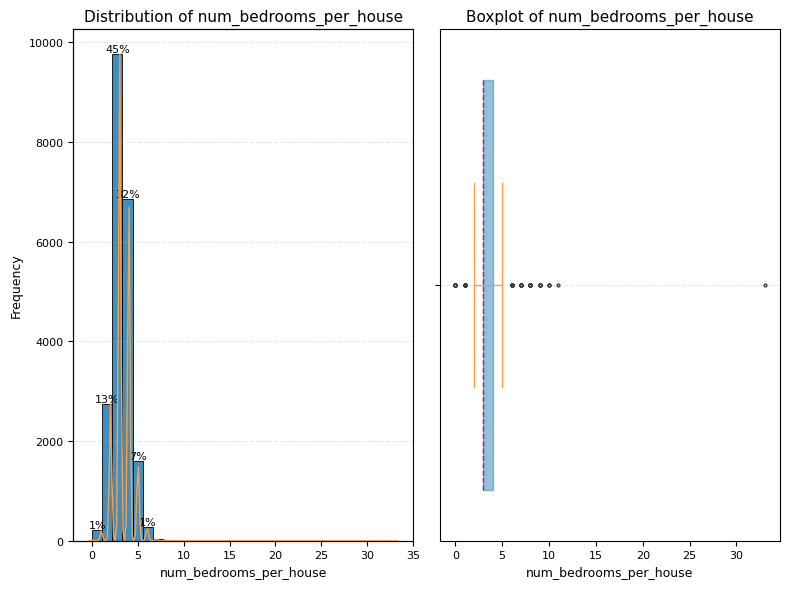

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


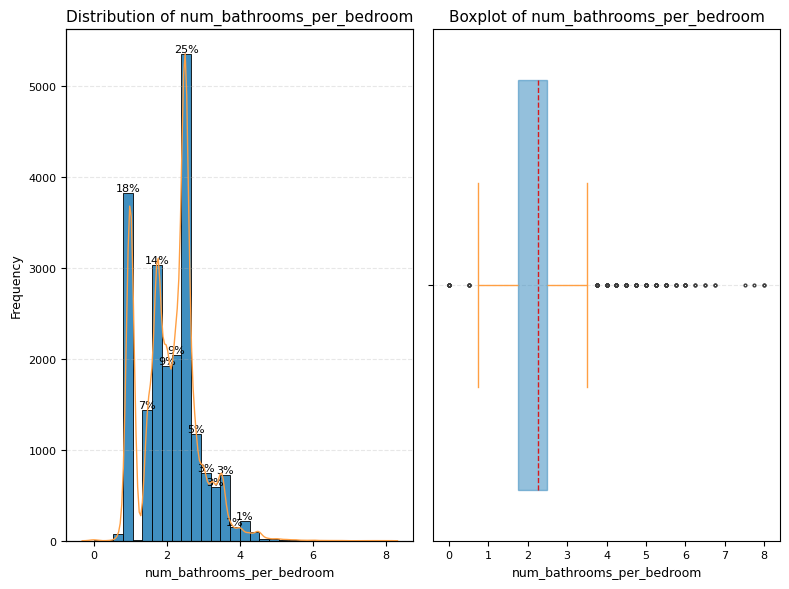

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


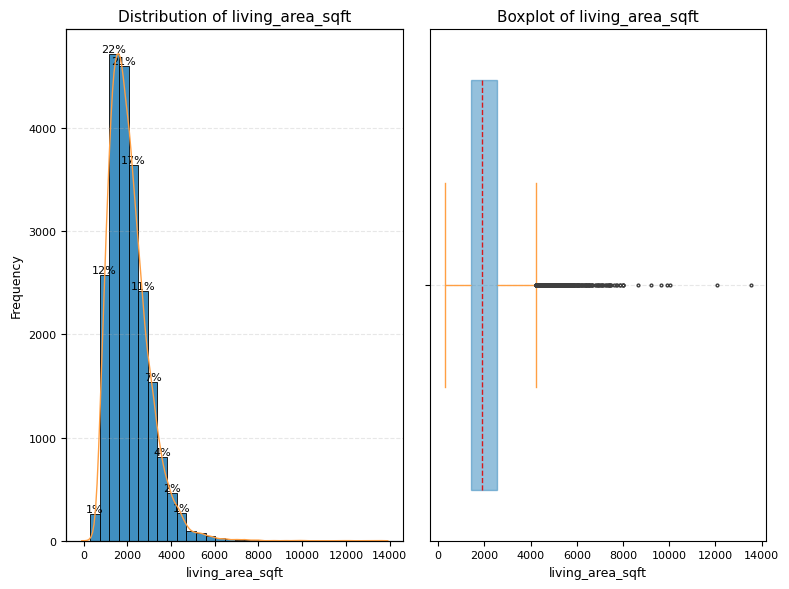

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


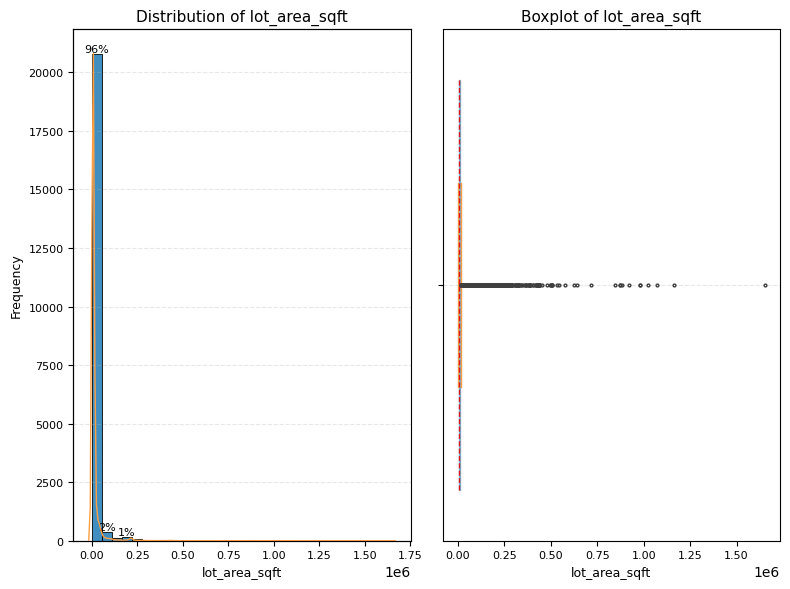

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


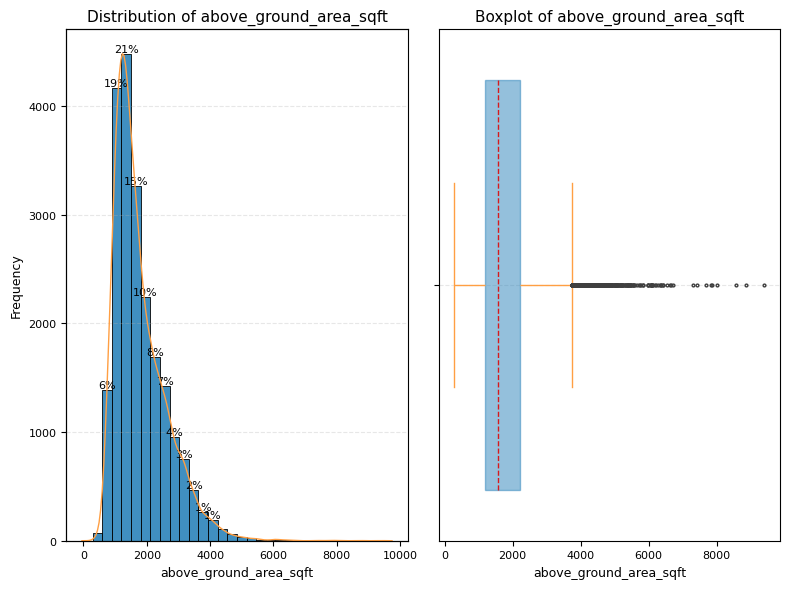

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


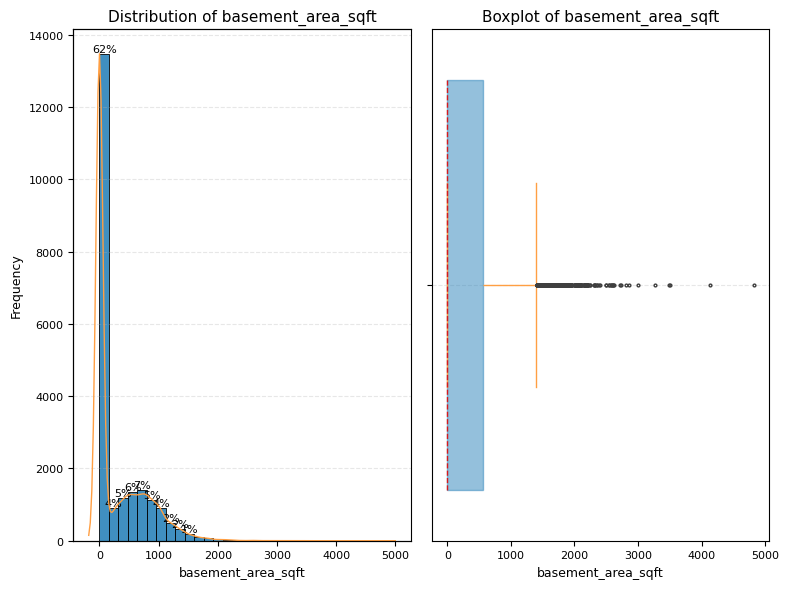

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


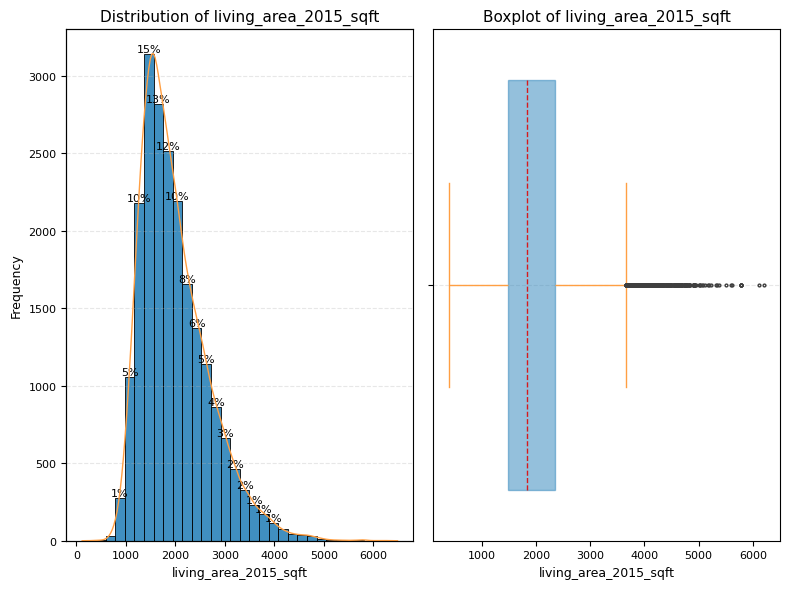

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


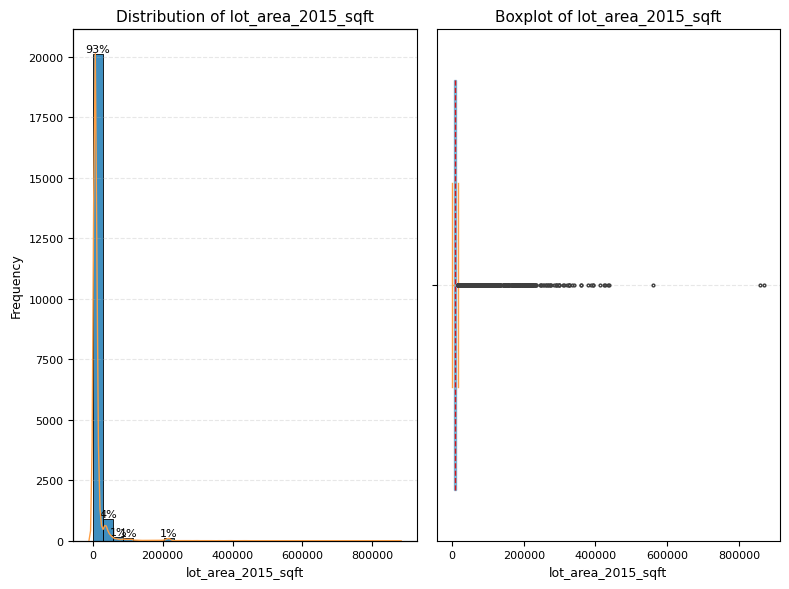

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


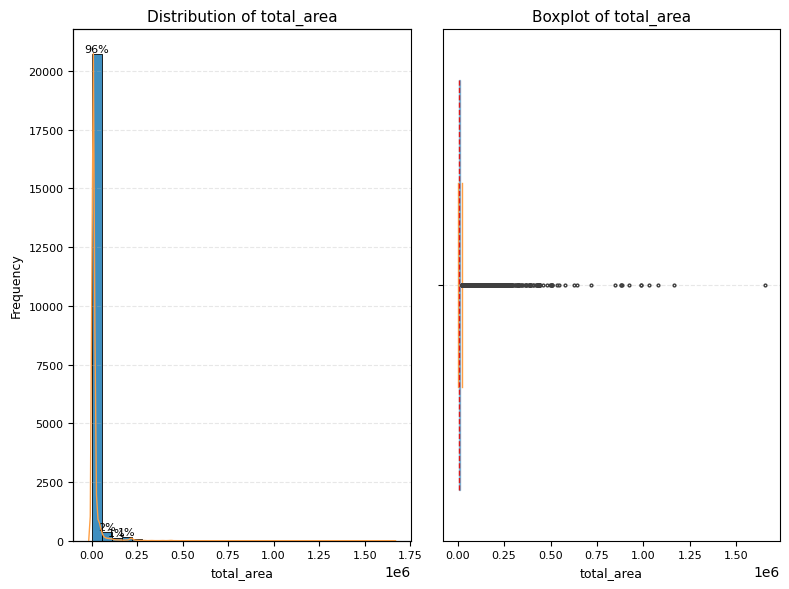

In [23]:
# Exclude the 'price' column
filtered_cols = [col for col in con_cols if col != 'price']

# Define figure dimensions
fig_width = 8  # Consistent figure width
fig_height = 6  # Consistent figure height

# Plot each column in a separate image
for col in filtered_cols:
    # Create subplots (1 row, 2 columns for distribution and boxplot)
    fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height))
    fig.tight_layout(pad=4)  # Adjust padding

    # Distribution plot (Histogram)
    sns.histplot(innercity_data[col], bins=30, ax=axes[0], color="#2b83ba", alpha=0.9)  # Muted dark blue

    # Add percentage labels
    total_entries = len(innercity_data[col].dropna())
    for bar in axes[0].patches:
        height = bar.get_height()
        if height > 0:  # Only add labels for non-zero values
            percentage = (height / total_entries) * 100
            if percentage >= 0.5:  # Only add labels for percentages >= 0.5%
                axes[0].text(
                    bar.get_x() + bar.get_width() / 2, 
                    height, 
                    f'{round(percentage)}%',  # Rounded to whole numbers
                    ha='center', va='bottom', fontsize=8, color='black'
                )
    
    # Add secondary y-axis for KDE line
    ax2 = axes[0].twinx()  # Create a secondary y-axis
    sns.kdeplot(innercity_data[col], ax=ax2, color="#ff9f43", linewidth=1)  # Orange KDE line

    # Hide secondary axis completely
    ax2.get_yaxis().set_visible(False)
    ax2.spines['right'].set_visible(False)

    axes[0].set_title(f"Distribution of {col}", fontsize=11, color='black')
    axes[0].set_xlabel(col, fontsize=9, color='black')
    axes[0].set_ylabel("Frequency", fontsize=9, color='black')
    axes[0].tick_params(axis='x', labelsize=8, colors='black')
    axes[0].tick_params(axis='y', labelsize=8, colors='black')
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)  # Subtle gridlines

    # Boxplot
    sns.boxplot(
        x=innercity_data[col], 
        ax=axes[1], 
        boxprops=dict(color="#2b83ba", facecolor="#2b83ba", alpha=0.5, linewidth=1),  # Blue box
        whiskerprops=dict(color="#ff9f43", linewidth=1),  # Orange whiskers
        capprops=dict(color="#ff9f43", linewidth=1),  # Orange caps
        medianprops=dict(color="#d7191c", linestyle='--', linewidth=1),  # Red dashed median
        flierprops=dict(marker='o', markersize=2, color='black', linestyle='none')  # Small dot outliers
    )
    axes[1].set_title(f"Boxplot of {col}", fontsize=11, color='black')
    axes[1].set_xlabel(col, fontsize=9, color='black')
    axes[1].tick_params(axis='x', labelsize=8, colors='black')
    axes[1].tick_params(axis='y', labelsize=8, colors='black')
    axes[1].grid(axis='y', linestyle='--', alpha=0.3)  # Subtle gridlines

    # Save each column as a separate image
    plt.tight_layout()
    plt.savefig(f".\\images\\dist_box_EDA_{col}.svg", format="svg", dpi=300)  # High resolution for compatibility
    plt.show()

In [24]:

# Function to describe categorical columns
def describe_categorical(data, columns):
    summary = {}
    for col in columns:
        value_counts = data[col].value_counts()
        percentages = (value_counts / len(data)) * 100
        percentages = percentages.round(3)
        summary[col] = {
            "Unique Values": data[col].unique(),
            "Count": value_counts.to_dict(),
            "Percentage (%)": percentages.to_dict(),
            "Mode": data[col].mode()[0] if not data[col].mode().empty else None
        }
    return summary

# Get description of categorical columns
categorical_summary = describe_categorical(innercity_data, cat_cols)

# Display summary
for col, stats in categorical_summary.items():
    print(f"Column: {col}")
    print(f"Unique Values: {stats['Unique Values']}")
    print(f"Counts: {stats['Count']}")
    print(f"Percentage Distribution: {stats['Percentage (%)']}")
    print(f"Mode: {stats['Mode']}\n")

Column: num_floors
Unique Values: [1.0, 2.0, 3.0, 1.5, 2.5, NaN, 3.5]
Categories (6, float64): [1.0 < 1.5 < 2.0 < 2.5 < 3.0 < 3.5]
Counts: {1.0: 10647, 2.0: 8210, 1.5: 1905, 3.0: 610, 2.5: 161, 3.5: 8}
Percentage Distribution: {1.0: 49.262, 2.0: 37.986, 1.5: 8.814, 3.0: 2.822, 2.5: 0.745, 3.5: 0.037}
Mode: 1.0

Column: waterfront_view
Unique Values: [0, 1, NaN]
Categories (2, int64): [0 < 1]
Counts: {0: 21421, 1: 161}
Percentage Distribution: {0: 99.112, 1: 0.745}
Mode: 0

Column: views
Unique Values: [0, 4, 2, 3, 1, NaN]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]
Counts: {0: 19437, 2: 959, 3: 510, 1: 332, 4: 318, 5: 0}
Percentage Distribution: {0: 89.932, 2: 4.437, 3: 2.36, 1: 1.536, 4: 1.471, 5: 0.0}
Mode: 0

Column: condition
Unique Values: [3, 4, 5, 2, NaN, 1]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
Counts: {3: 13978, 4: 5655, 5: 1694, 2: 171, 1: 30}
Percentage Distribution: {3: 64.674, 4: 26.165, 5: 7.838, 2: 0.791, 1: 0.139}
Mode: 3

Column: construction_grade
Unique Value

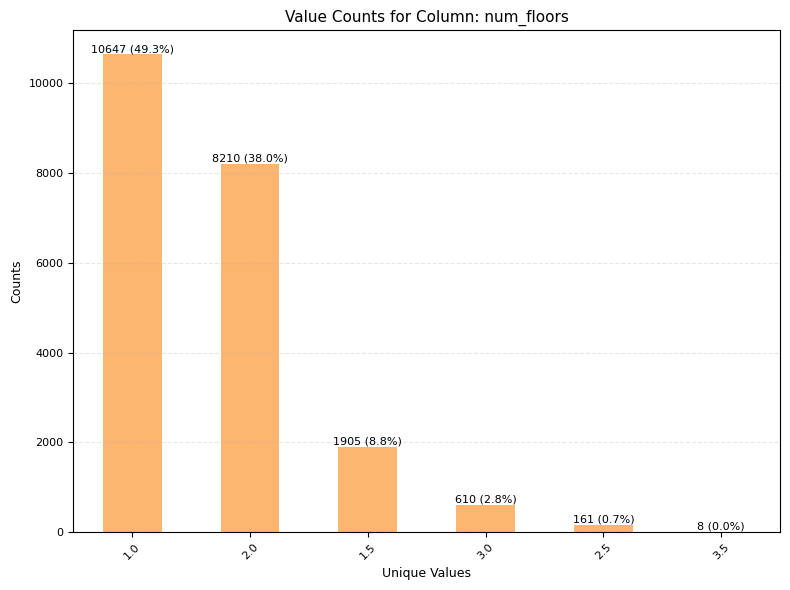

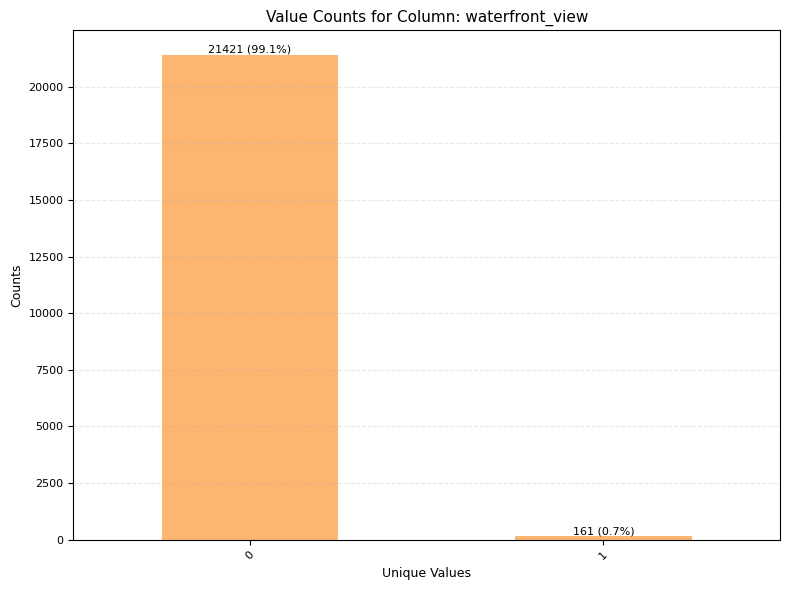

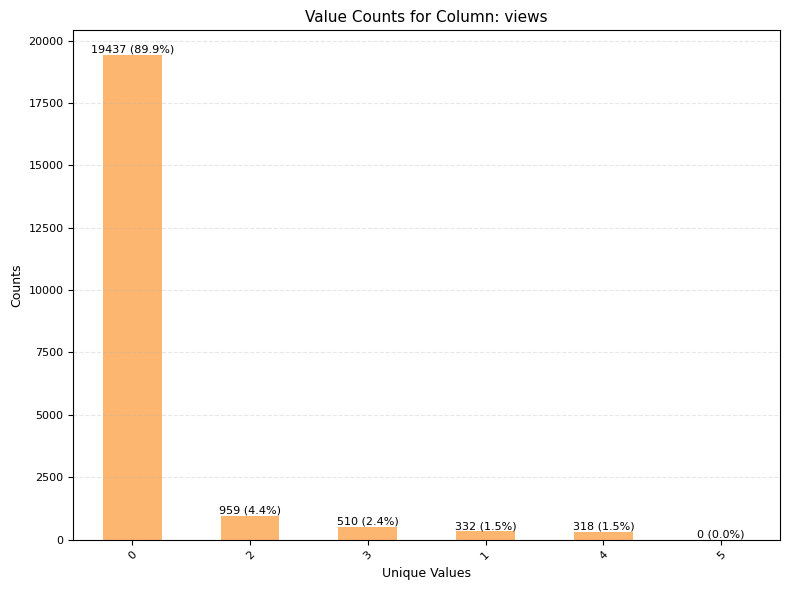

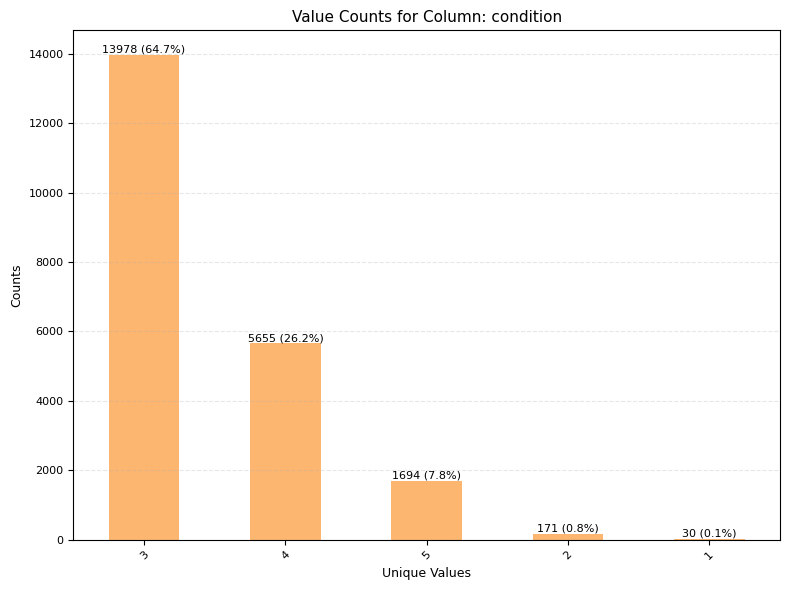

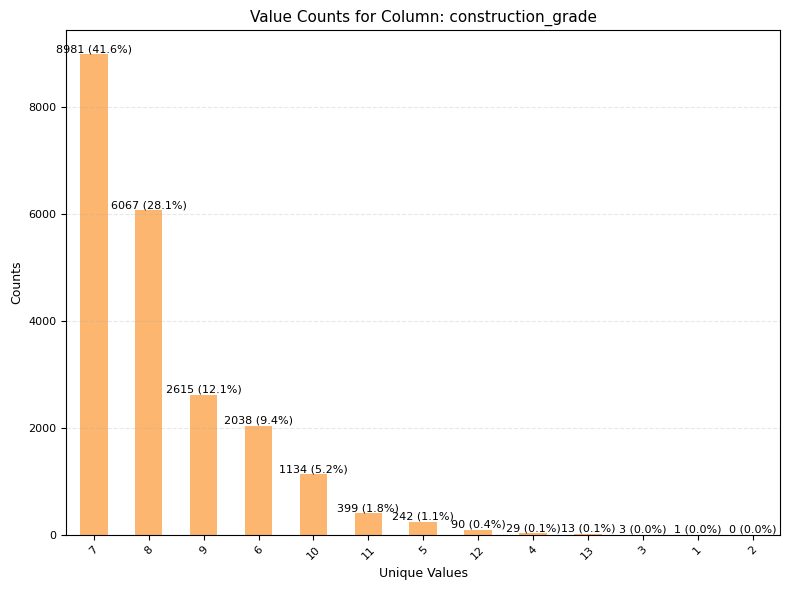

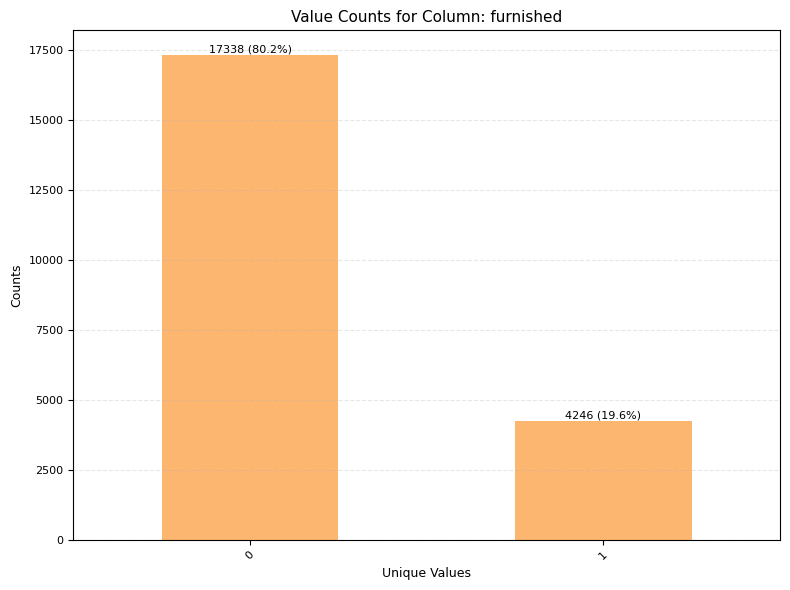

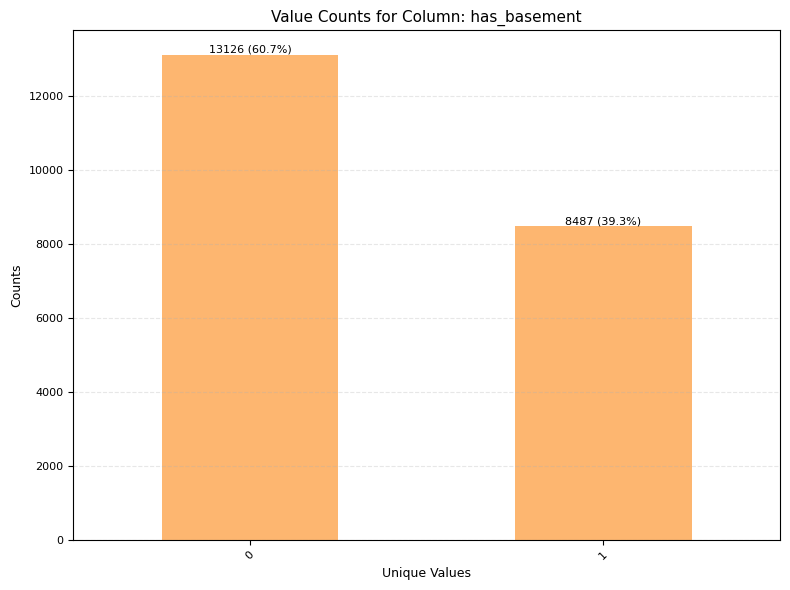

In [25]:
# Loop through all categorical columns
for col in cat_cols:
    if col in innercity_data.columns:
        # Calculate value counts and percentages
        value_counts = innercity_data[col].value_counts()
        percentages = (value_counts / len(innercity_data)) * 100

        # Create the plot
        plt.figure(figsize=(8, 6))
        ax = value_counts.plot(kind='bar', color="#fdae61", alpha=0.9)  # Muted orange color
        
        # Add labels with counts and percentages
        for bar, count, percentage in zip(ax.patches, value_counts.values, percentages.values):
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_height(),
                f'{int(count)} ({percentage:.1f}%)',  # Display count and percentage
                ha='center', va='bottom', fontsize=8, color='black'
            )

        # Set titles and labels
        plt.title(f"Value Counts for Column: {col}", fontsize=11, color='black')
        plt.xlabel('Unique Values', fontsize=9, color='black')
        plt.ylabel('Counts', fontsize=9, color='black')
        plt.xticks(rotation=45, fontsize=8, color='black')
        plt.yticks(fontsize=8, color='black')
        plt.grid(axis='y', linestyle='--', alpha=0.3)  # Subtle gridlines

        # Save and display the plot
        plt.tight_layout()
        plt.savefig(f".\\images\\{col}_value_counts_with_labels_and_percentages.svg", format="svg", dpi=300)  # Save as .svg
        plt.show()
    else:
        print(f"The column '{col}' does not exist in the dataset.")

In [26]:
innercity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21505 non-null  Int64         
 4   num_bathrooms_per_bedroom  21505 non-null  float64       
 5   living_area_sqft           21596 non-null  float64       
 6   lot_area_sqft              21571 non-null  float64       
 7   num_floors                 21541 non-null  category      
 8   waterfront_view            21582 non-null  category      
 9   views                      21556 non-null  category      
 10  condition                  21528 non-null  category      
 11  construction_grade         21612 non-null  category      
 12  abov

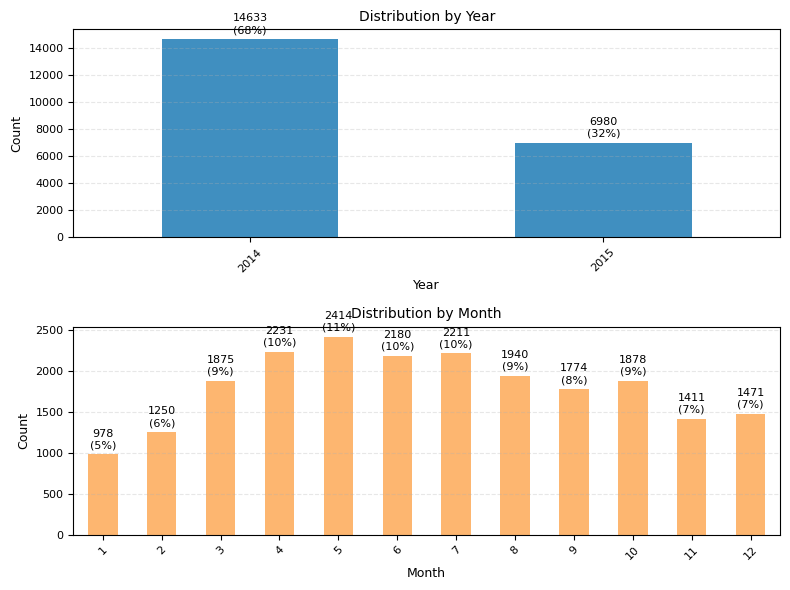

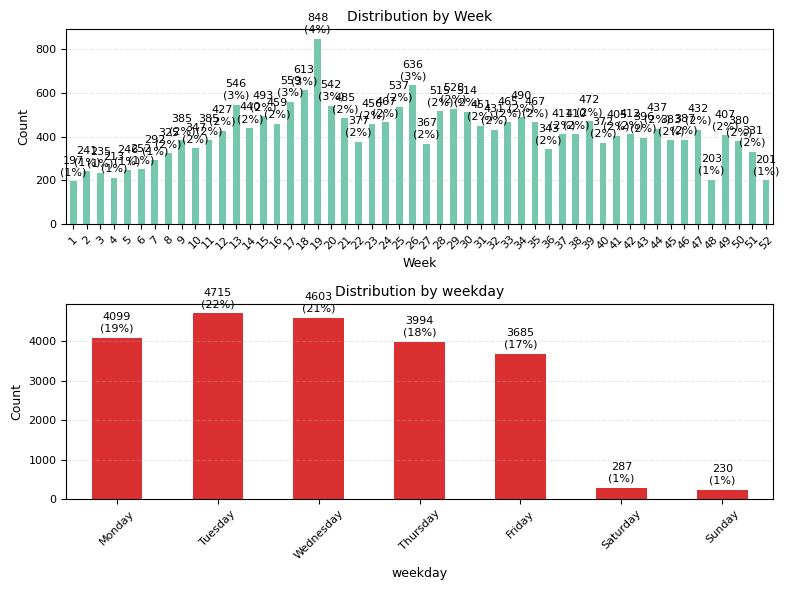

In [27]:

# Extract Year, Month, Week, and Day from sale_date
innercity_data['sale_date'] = pd.to_datetime(innercity_data['sale_date'])
innercity_data['year'] = innercity_data['sale_date'].dt.year
innercity_data['month'] = innercity_data['sale_date'].dt.month
innercity_data['week'] = innercity_data['sale_date'].dt.isocalendar().week
innercity_data['day'] = innercity_data['sale_date'].dt.day_name()

# Define aesthetics
colors = ['#2b83ba', '#fdae61', '#66c2a5', '#d7191c']  # Muted dark blue, orange, green, and red
font_title = 10
font_label = 9
font_tick = 8
label_offset = 0.05  # Adjusted offset for labels above bars

# Split the charts into two images
charts = [
    ('Year', innercity_data['year'].value_counts().sort_index(), colors[0]),
    ('Month', innercity_data['month'].value_counts().sort_index(), colors[1]),
    ('Week', innercity_data['week'].value_counts().sort_index(), colors[2]),
    ('weekday', innercity_data['day'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']), colors[3]),
]

# Helper function to create and save a 2-chart subplot
def create_subplot(charts, filename):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 charts per image, size 8x6
    fig.subplots_adjust(top=0.92, bottom=0.08, hspace=0.4)  # Adjust layout to reduce top and bottom margins
    for idx, (title, counts, color) in enumerate(charts):
        percentages = (counts / len(innercity_data)) * 100
        counts.plot(kind='bar', ax=axes[idx], color=color, alpha=0.9)
        axes[idx].set_title(f"Distribution by {title}", fontsize=font_title, color='black')
        axes[idx].set_xlabel(title, fontsize=font_label, color='black')
        axes[idx].set_ylabel("Count", fontsize=font_label, color='black')
        axes[idx].tick_params(axis='x', labelsize=font_tick, rotation=45, colors='black')
        axes[idx].tick_params(axis='y', labelsize=font_tick, colors='black')
        axes[idx].grid(axis='y', linestyle='--', alpha=0.3)
        y_max = counts.max() * (1 + label_offset)
        axes[idx].set_ylim(0, y_max)
        for i, count in enumerate(counts):
            percentage = round(percentages.iloc[i])
            # Ensure labels are positioned dynamically within chart limits
            label_y_position = count + (y_max * 0.02)
            axes[idx].text(i, label_y_position, f"{count}\n({percentage}%)", 
                           ha='center', va='bottom', fontsize=8, color='black')
    plt.tight_layout()
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

# Create the first subplot for Year and Month
create_subplot(charts[:2], ".\\images\\EDA_time_Year_Month_no_margin.svg")

# Create the second subplot for Week and Day
create_subplot(charts[2:], ".\\images\\EDA_time_Week_Day_no_margin.svg")

C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\4144706153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data['geometry'] = geo_data.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\4144706153.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zip_counts = geo_data.groupby('zipcode').size().reset_index(name='count')


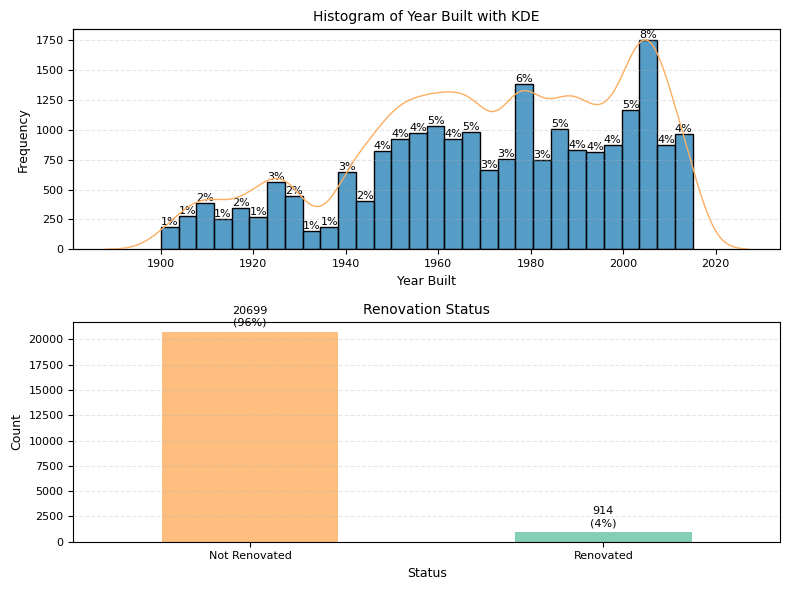

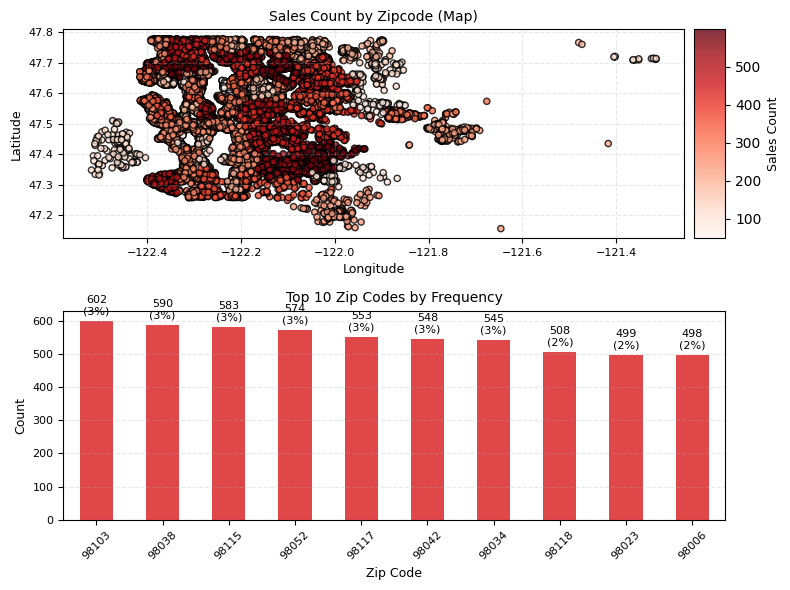

In [28]:
# Ensure latitude and longitude columns are available for map plotting
geo_data = innercity_data.dropna(subset=['latitude', 'longitude'])

# Create a GeoDataFrame with geometries
geo_data['geometry'] = geo_data.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)
gdf = gpd.GeoDataFrame(geo_data, geometry='geometry')

# Aggregate counts by zipcode
zip_counts = geo_data.groupby('zipcode').size().reset_index(name='count')

# Merge counts back to the GeoDataFrame
gdf = gdf.merge(zip_counts, on='zipcode', how='left')

# Define consistent aesthetics
colors = ['#2b83ba', '#fdae61', '#66c2a5', '#d7191c']  # Muted dark blue, orange, green, red
font_title = 10
font_label = 9
font_tick = 8
label_offset = 0.05

# Function to create subplots with two charts
def create_two_chart_subplots(charts, filename):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # Two charts per image
    for idx, (title, plot_func) in enumerate(charts):
        plot_func(axes[idx])
        axes[idx].set_title(title, fontsize=font_title, color='black')
    plt.tight_layout()
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

# Chart 1: Histogram for year_built with KDE on secondary axis
def plot_year_built(ax):
    # Plot histogram
    sns.histplot(
        innercity_data['year_built'].dropna().astype(int),
        bins=30, color=colors[0], alpha=0.8, ax=ax
    )
    # Create secondary y-axis for KDE
    ax2 = ax.twinx()
    sns.kdeplot(
        innercity_data['year_built'].dropna().astype(int),
        color="#fdae61", linewidth=1, ax=ax2
    )
    ax2.get_yaxis().set_visible(False)  # Hide the secondary y-axis
    ax2.spines['right'].set_visible(False)  # Hide the secondary y-axis spine

    ax.set_xlabel("Year Built", fontsize=font_label, color='black')
    ax.set_ylabel("Frequency", fontsize=font_label, color='black')
    ax.tick_params(axis='x', labelsize=font_tick, colors='black')
    ax.tick_params(axis='y', labelsize=font_tick, colors='black')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Calculate total for percentage calculation
    total = innercity_data['year_built'].dropna().shape[0]

    # Add percentage labels to the bars
    for bar in ax.patches:
        if bar.get_height() > 0:  # Avoid labeling bars with height 0
            percentage = (bar.get_height() / total) * 100
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + label_offset,
                f"{round(percentage)}%",  # Display only percentage
                ha='center', va='bottom', fontsize=8, color='black'
            )

# Chart 2: Bar Plot for Renovation Status
def plot_renovation_status(ax):
    renovated_counts = innercity_data['year_renovated'].apply(lambda x: 'Not Renovated' if x == 0 else 'Renovated').value_counts()
    renovated_counts.plot(kind='bar', ax=ax, color=[colors[1], colors[2]], alpha=0.8)
    ax.set_xlabel("Status", fontsize=font_label, color='black')
    ax.set_ylabel("Count", fontsize=font_label, color='black')
    ax.tick_params(axis='x', labelsize=font_tick, rotation=0, colors='black')
    ax.tick_params(axis='y', labelsize=font_tick, colors='black')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    y_max = renovated_counts.max() * (1 + label_offset)
    ax.set_ylim(0, y_max)
    for i, count in enumerate(renovated_counts):
        percentage = (count / len(innercity_data)) * 100
        ax.text(i, count + y_max * 0.02, f"{count}\n({round(percentage)}%)", ha='center', va='bottom', fontsize=8, color='black')

# Chart 3: Map of Sales Count by Zipcode
def plot_sales_map(ax):
    scatter = ax.scatter(
        gdf['longitude'], gdf['latitude'],
        c=gdf['count'], cmap='Reds', s=20, alpha=0.8, edgecolor='black'
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label('Sales Count', fontsize=font_label, color='black')
    ax.set_xlabel("Longitude", fontsize=font_label, color='black')
    ax.set_ylabel("Latitude", fontsize=font_label, color='black')
    ax.tick_params(axis='x', labelsize=font_tick, colors='black')
    ax.tick_params(axis='y', labelsize=font_tick, colors='black')
    ax.grid(True, linestyle='--', alpha=0.3)

# Chart 4: Bar Chart for Top Zip Codes
def plot_top_zipcodes(ax):
    top_zipcodes = innercity_data['zipcode'].value_counts().head(10)
    top_zipcodes.plot(kind='bar', ax=ax, color=colors[3], alpha=0.8)
    ax.set_xlabel("Zip Code", fontsize=font_label, color='black')
    ax.set_ylabel("Count", fontsize=font_label, color='black')
    ax.tick_params(axis='x', labelsize=font_tick, rotation=45, colors='black')
    ax.tick_params(axis='y', labelsize=font_tick, colors='black')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    y_max = top_zipcodes.max() * (1 + label_offset)
    ax.set_ylim(0, y_max)
    for i, count in enumerate(top_zipcodes):
        percentage = (count / len(innercity_data)) * 100
        ax.text(i, count + y_max * 0.02, f"{count}\n({round(percentage)}%)", ha='center', va='bottom', fontsize=8, color='black')

# Create and save two charts per image
create_two_chart_subplots(
    [("Histogram of Year Built with KDE", plot_year_built), ("Renovation Status", plot_renovation_status)],
    ".\\images\\EDA_year_built_renovation_secondary_kde.svg"
)

create_two_chart_subplots(
    [("Sales Count by Zipcode (Map)", plot_sales_map), ("Top 10 Zip Codes by Frequency", plot_top_zipcodes)],
    ".\\images\\EDA_sales_zipcodes_secondary_kde.svg"
)

## Bivariate analysis (relationship between different variables , correlations)
### Continous Variables
- Positive Relationships: Variables like living_area_sqft, total_area, and above_ground_area_sqft show strong positive relationships with price.
- Non-linear Relationships: Some variables (e.g., lot_area_sqft) exhibit non-linear relationships, with diminishing price increases at larger values.
- Clusters: Potential clustering in some variables suggests different market segments or property types.
- Top Correlations with Price:
    - living_area_sqft (correlation: high positive).
    - total_area (correlation: strong positive).
    - num_bathrooms_per_bedroom (moderate positive correlation).
- Weaker Correlations with Price:
    - basement_area_sqft and lot_area_sqft
- Inter-Variable Correlations:
    - High correlations between living_area_sqft, total_area, and above_ground_area_sqft indicate redundancy, suggesting multicollinearity.
### Categorical Variables
#### num_floors
- F-Statistic: 37.47, P-Value: 0.0
- The large F-statistic and very low p-value indicate significant differences in property prices across different numbers of floors.
- The number of floors is a strong factor influencing property prices. Higher-floor properties may cater to a premium market segment.
#### waterfront_views
- F-Statistic: 1632.47, P-Value: 0.0
- Extremely high F-statistic and p-value of 0 confirm that properties with waterfront views have significantly higher prices compared to those without.
- Waterfront views are among the most critical features affecting property pricing, often commanding premium prices.
#### views
- F-Statistic: 1081.32 , P-Value: 0.0
- high F-statistic and p-value of 0 suggest that properties with better views (higher view counts) have significantly different prices.
- Enhanced views substantially increase property desirability and market value.
#### condition
- F-Statistic: 37.47, P-Value:0.0
- F-statistic indicates that property condition has a statistically significant but relatively smaller impact on prices compared to features like waterfront_view or views.
- Properties in better condition attract higher prices, reflecting buyer preferences for well-maintained homes.
#### construction_grade
- F-Statistic: 2101.98,P-Value: 0.0
- A very high F-statistic shows that construction grade is a major determinant of property price.
- Higher construction grades strongly correlate with premium pricing, likely reflecting better quality materials and finishes.
#### year_built
- F-Statistic: 9.90, P-Value: >> 0.0
- The p-value indicates statistical significance, but the relatively lower F-statistic shows that year_built has a moderate effect on property prices.
- Newer properties tend to be priced higher, but the impact is less pronounced compared to other factors like location or amenities.
#### year_renovated
- F-Statistic: 8.71, P-Value: >>> 1.83e-84
- Statistically significant but lower F-statistic implies that renovation has a moderate impact on prices.
- Recent renovations add value, particularly for older properties, but the effect is not as strong as location or grade.
#### zipcode
- F-Statistic: 213.57, P-Value: 0.0
- The high F-statistic and p-value of 0 highlight that location (zip code) significantly influences property prices.
- Certain zip codes are associated with premium property prices, reflecting the importance of location in real estate.
#### furnished
- F-Statistic: 10076.24, P-Value: 0.0
- The extremely high F-statistic indicates that furnishing is one of the most significant factors influencing price.
- Furnished properties attract significantly higher prices, appealing to buyers looking for ready-to-move-in homes.
### Sales Date Distribution
#### Yearly Trend
- Plot: The average house price by year shows minor fluctuations but no strong upward.
- The p-value (0.601) indicates that the differences in average prices across years are not statistically significant at the conventional 0.05 significance level.
- Yearly changes in house prices are likely due to random variation rather than a systematic trend.
#### Monthly Trend
- Plot: The average house price by month shows noticeable variation. Certain months may have higher or lower prices than others, suggesting potential seasonality.
- The p-value (0.0003) is well below 0.05, indicating that the differences in average house prices across months are statistically significant.
- There is strong evidence that house prices vary systematically depending on the month.
#### Weekday Trend
- Plot: The average house price by weekday does not show significant differences. Prices appear relatively uniform across weekdays.
- The p-value (0.612) is much greater than 0.05, indicating that the differences in average house prices across weekdays are not statistically significant.
- House prices are not influenced by the day of the week.

In [29]:
print(cat_cols)

['num_floors', 'waterfront_view', 'views', 'condition', 'construction_grade', 'furnished', 'has_basement']


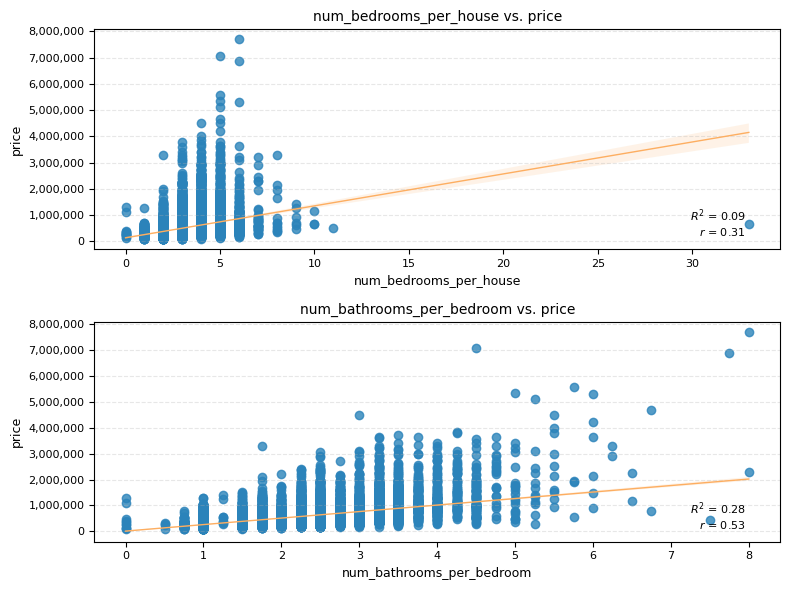

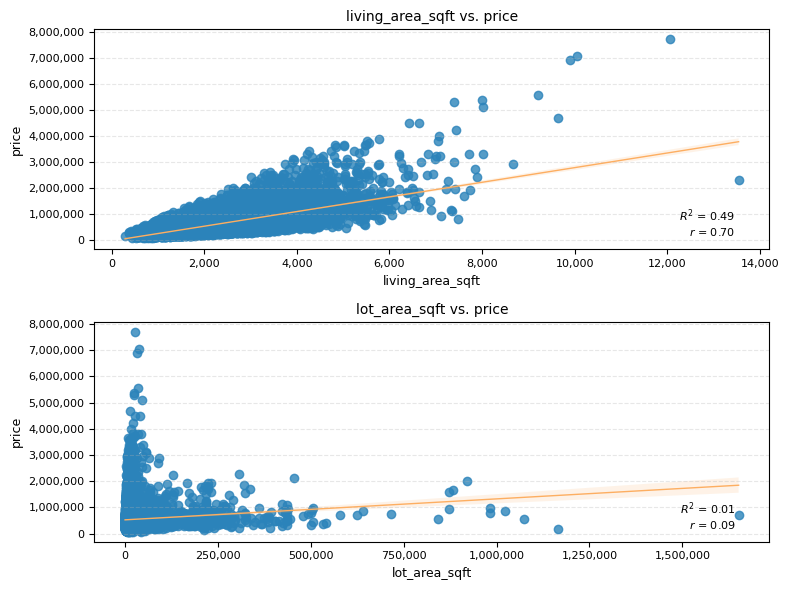

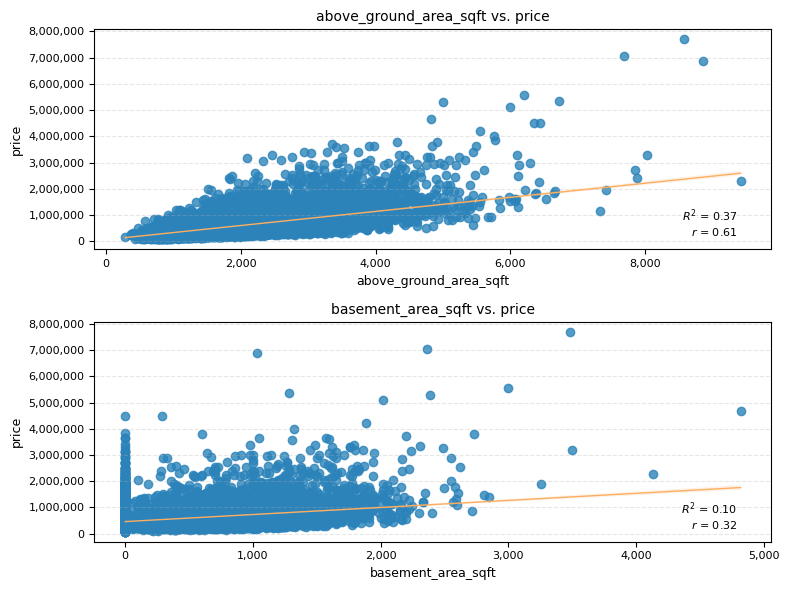

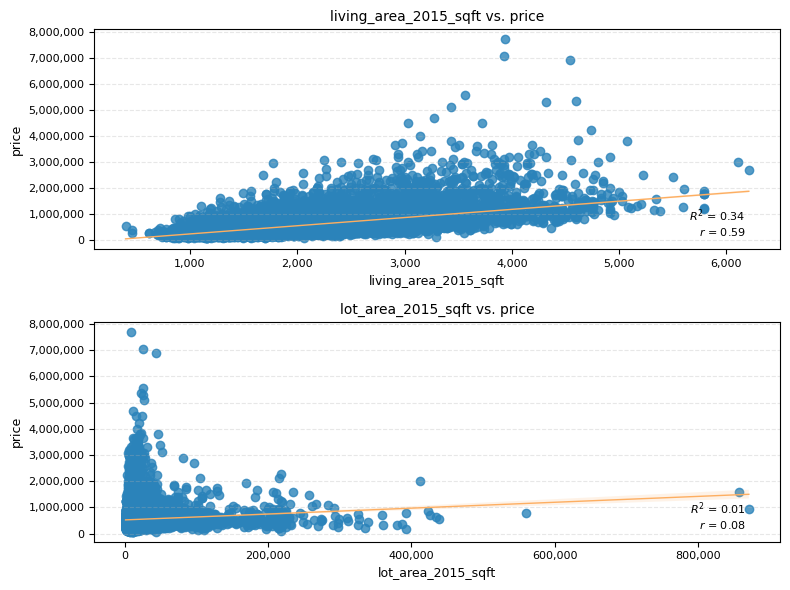

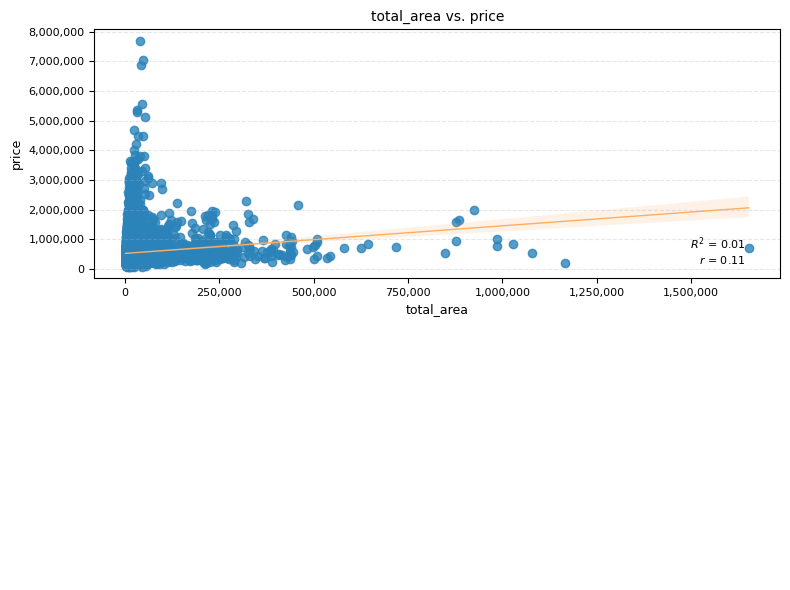

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Define continuous variables and the target variable 'price'
continuous_vars = [
    'num_bedrooms_per_house', 'num_bathrooms_per_bedroom', 'living_area_sqft',
    'lot_area_sqft', 'above_ground_area_sqft', 'basement_area_sqft',
    'living_area_2015_sqft', 'lot_area_2015_sqft', 'total_area'
]
target_var = 'price'

# Remove rows with missing values in relevant columns
analysis_data = innercity_data[continuous_vars + [target_var]].dropna()

# Define aesthetics
font_title = 10
font_label = 9
font_tick = 8

# Split continuous variables into pairs for two charts per image
scatter_pairs = [(continuous_vars[i], continuous_vars[i+1] if i+1 < len(continuous_vars) else None) 
                 for i in range(0, len(continuous_vars), 2)]

# Function to create scatter plots with trend line, R^2, correlation, and plain axis labels
def create_scatter_subplots(pairs, filename):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # Two charts per image
    for idx, (var, ax) in enumerate(zip(pairs, axes)):
        if var is not None:  # Check if the variable exists
            # Regression line and R^2 calculation
            X = analysis_data[[var]].values
            y = analysis_data[target_var].values
            model = LinearRegression().fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)

            # Calculate Pearson correlation coefficient
            correlation, _ = pearsonr(analysis_data[var], analysis_data[target_var])

            sns.regplot(
                x=var, y=target_var, data=analysis_data, ax=ax,
                scatter_kws={'color': "#2b83ba", 'alpha': 0.8},  # Muted dark blue
                line_kws={'color': '#fdae61', 'linewidth': 1}  # Muted orange
            )
            ax.set_title(f"{var} vs. {target_var}", fontsize=font_title, color='black')
            ax.set_xlabel(var, fontsize=font_label, color='black')
            ax.set_ylabel(target_var, fontsize=font_label, color='black')
            ax.tick_params(axis='x', labelsize=font_tick, colors='black')
            ax.tick_params(axis='y', labelsize=font_tick, colors='black')
            ax.grid(axis='y', linestyle='--', alpha=0.3)

            # Add R^2 and correlation annotation
            ax.text(
                0.95, 0.05, f"$R^2$ = {r2:.2f}\n$r$ = {correlation:.2f}",
                transform=ax.transAxes, ha='right', va='bottom', fontsize=8, color='black'
            )

            # Format axes to prevent scientific notation
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:,.0f}'))
        else:
            ax.axis('off')  # Turn off the empty subplot
    plt.tight_layout()
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

# Loop through pairs and create subplots
for idx, pair in enumerate(scatter_pairs):
    filename = f".\\images\\Scatter_with_correlation_{idx+1}.svg"
    create_scatter_subplots(pair, filename)

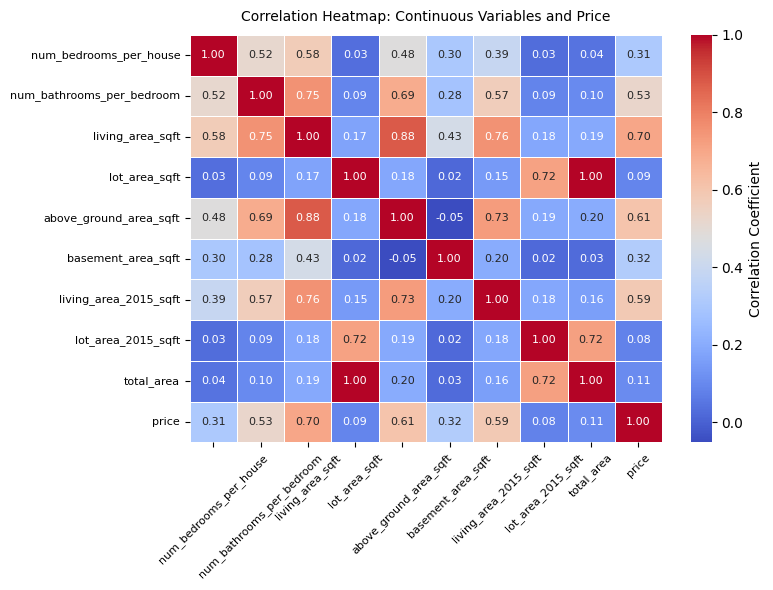

In [31]:
# Define consistent aesthetics
font_title = 10
font_label = 9
font_tick = 8
color_map = 'coolwarm'

# Generate correlation heatmap
corr_matrix = analysis_data.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Set figure size to 8x6
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap=color_map, 
    fmt='.2f', 
    linewidths=0.5, 
    annot_kws={"size": 8},  # Font size for annotations
    cbar_kws={"label": "Correlation Coefficient"}  # Color bar label
)

# Add titles and labels
plt.title("Correlation Heatmap: Continuous Variables and Price", fontsize=font_title, color='black', pad=10)
plt.tick_params(axis='x', labelsize=font_tick, labelrotation=45, colors='black')  # X-axis ticks
plt.tick_params(axis='y', labelsize=font_tick, colors='black')  # Y-axis ticks
plt.tight_layout()

# Save the plot
plt.savefig(".\\images\\heatmap_consistent.svg", format="svg", dpi=300)  # Save with appropriate DPI
plt.show()

In [32]:
print(cat_cols)

['num_floors', 'waterfront_view', 'views', 'condition', 'construction_grade', 'furnished', 'has_basement']


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


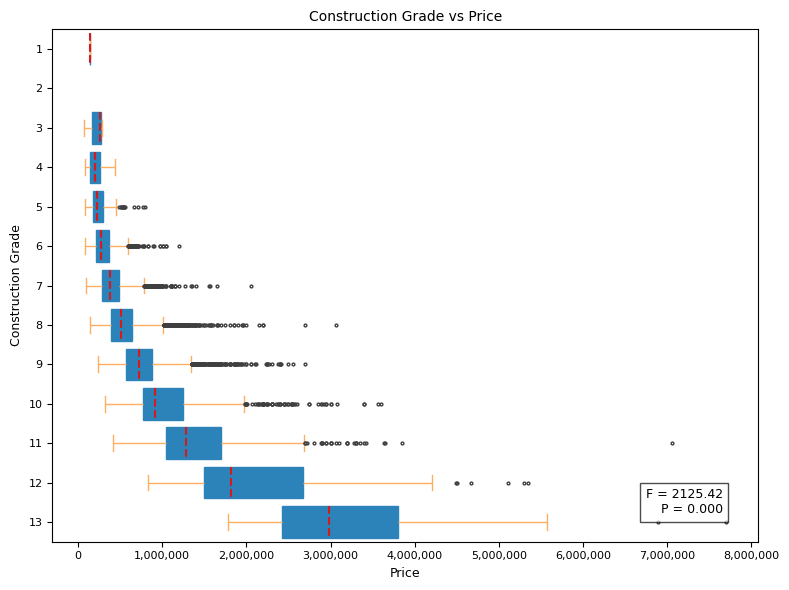

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


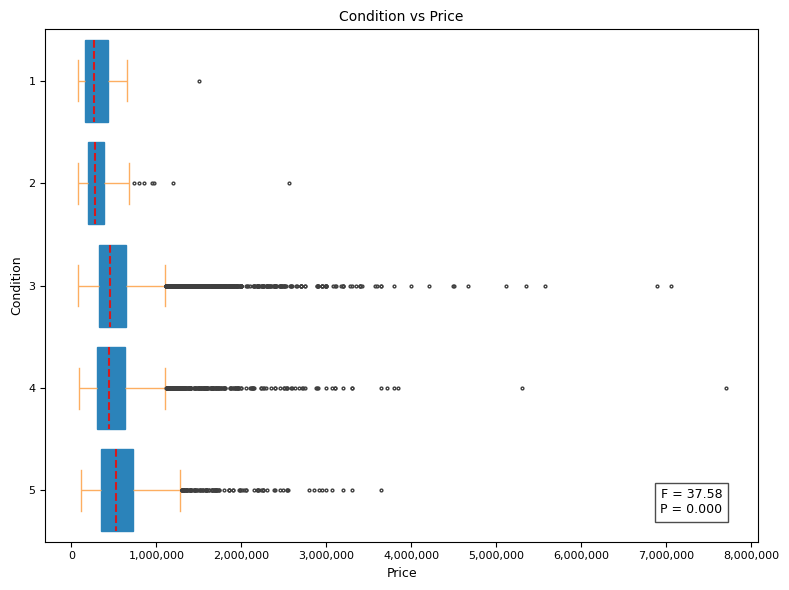

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


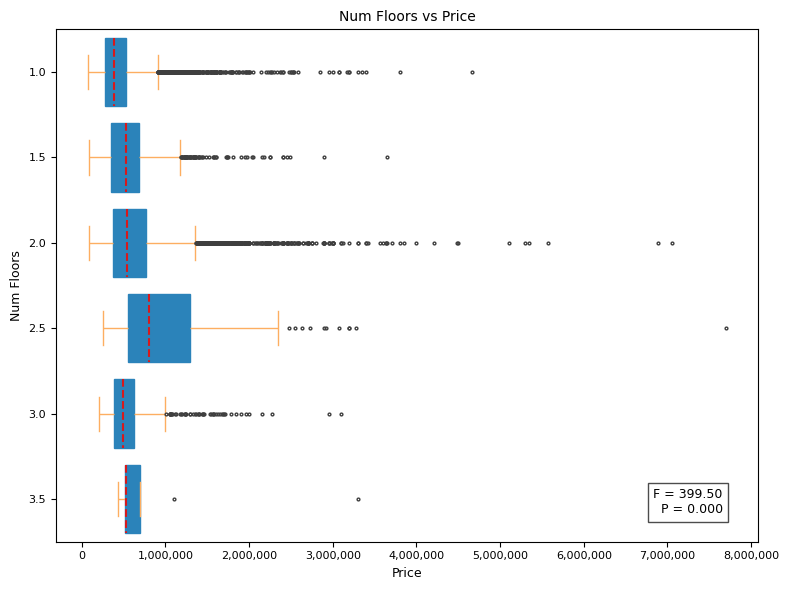

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


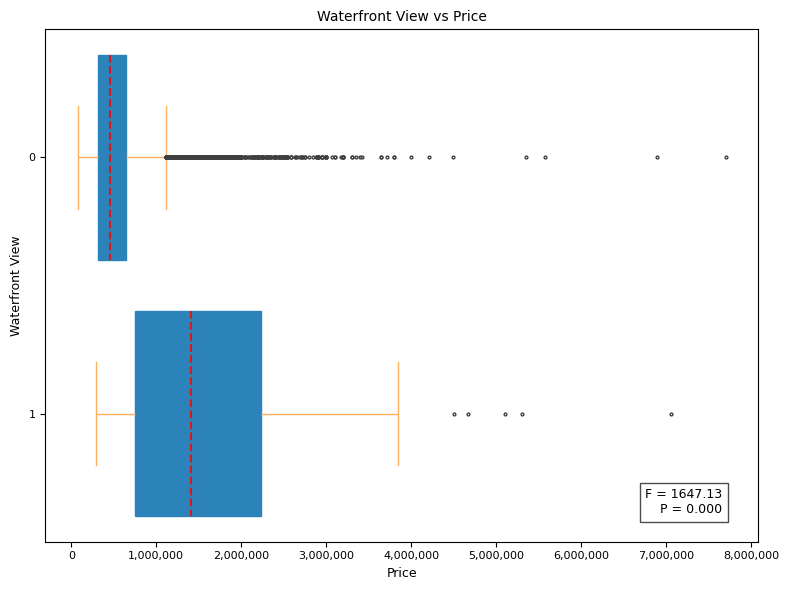

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


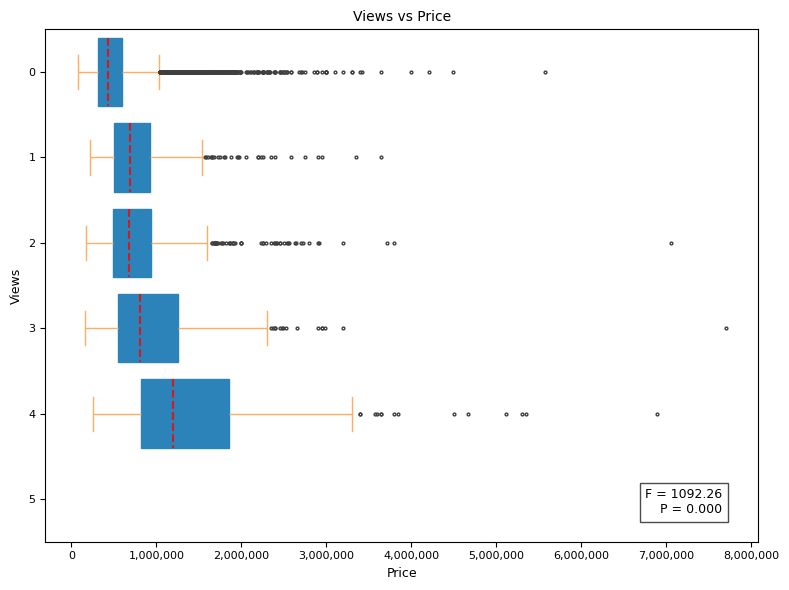

In [33]:
# Define aesthetics
font_title = 10
font_label = 9
font_tick = 8
label_offset = 0.05
color_box = '#2b83ba'  # Muted blue
color_whisker = '#fdae61'  # Muted orange
color_median = '#d7191c'  # Red dashed line for median
outlier_marker_size = 2  # Size of the dots for outliers

# List of categorical columns
cat_cols = ['construction_grade', 'condition', 'num_floors', 'waterfront_view', 'views']

# Helper function to calculate ANOVA and create rotated boxplot
def plot_boxplot_with_anova(y_var, x_var, data, filename):
    fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size to 8x6

    # Prepare data for ANOVA
    groups = [data[data[y_var] == group][x_var] for group in data[y_var].dropna().unique()]
    anova_result = f_oneway(*groups) if len(groups) > 1 else None

    # Plot the boxplot with aesthetics
    sns.boxplot(
        data=data, x=x_var, y=y_var, ax=ax,
        boxprops=dict(color=color_box),  # Box color
        whiskerprops=dict(color=color_whisker),  # Whisker color
        capprops=dict(color=color_whisker),  # Cap color
        medianprops=dict(color=color_median, linestyle='--', linewidth=1.5),  # Median line
        flierprops=dict(marker='o', markersize=outlier_marker_size, color='black', linestyle='none')  # Small dot outliers
    )
    
    # Titles and labels
    ax.set_title(f"{y_var.replace('_', ' ').title()} vs Price", fontsize=font_title, color='black')
    ax.set_xlabel("Price", fontsize=font_label, color='black')
    ax.set_ylabel(y_var.replace('_', ' ').title(), fontsize=font_label, color='black')

    # Ticks formatting
    ax.tick_params(axis='x', labelsize=font_tick, colors='black')
    ax.tick_params(axis='y', labelsize=font_tick, colors='black')

    # Annotate ANOVA results
    if anova_result:
        f_stat = f"{anova_result.statistic:.2f}"
        p_value = f"{anova_result.pvalue:.3f}"
        annotation = f"F = {f_stat}\nP = {p_value}"
    else:
        annotation = "ANOVA not applicable"
    
    # Position annotation
    ax.text(
        0.95, 0.05, annotation, fontsize=font_label, color='black',
        transform=ax.transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7)
    )

    # Ensure all y-axis values are shown if they are discrete integers
    if data[y_var].dtype == int or data[y_var].dtype == float:
        y_min, y_max = data[y_var].min(), data[y_var].max()
        ax.set_yticks(range(int(y_min), int(y_max) + 1))

    # Format x-axis (price) as whole numbers
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Save the figure
    plt.tight_layout()
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

# Generate boxplots with ANOVA annotations for all categorical columns
for col in cat_cols:
    plot_boxplot_with_anova(col, 'price', innercity_data, f".\\images\\price_vs_{col}.svg")

C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\2218211692.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  anova = f_oneway(*groups)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


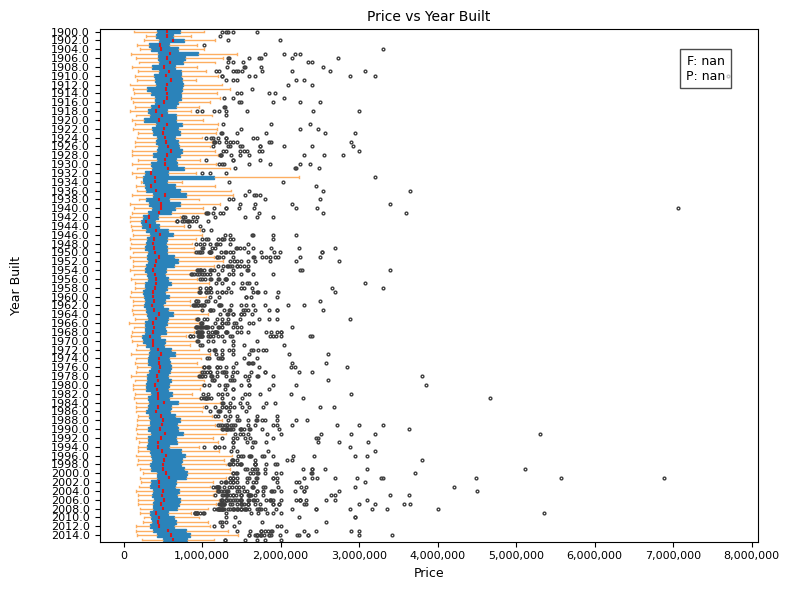

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


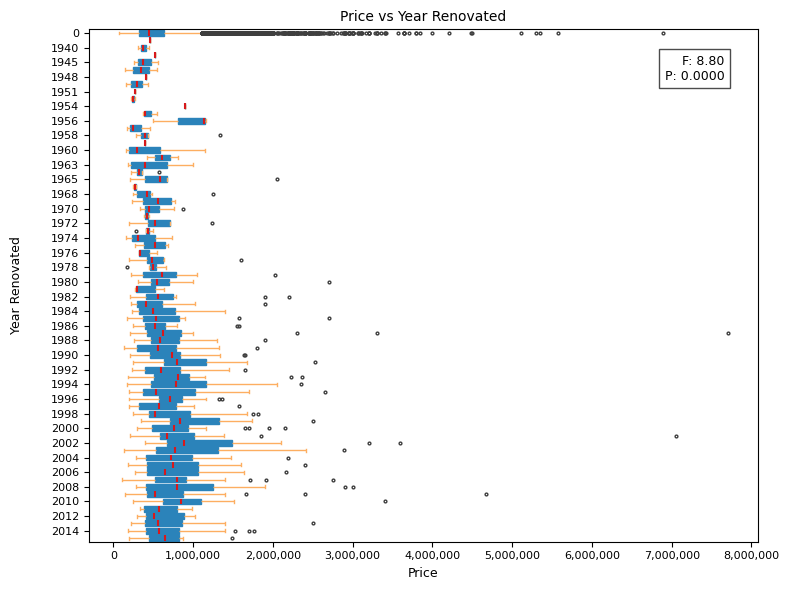

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


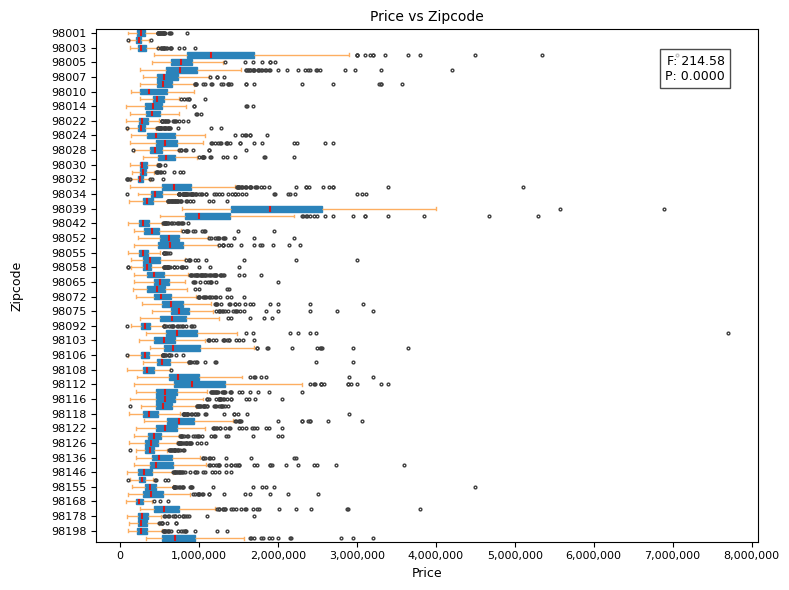

In [34]:
# Define aesthetics
font_title = 10
font_label = 9
font_tick = 8
label_offset = 0.05
color_box = '#2b83ba'  # Muted blue
color_whisker = '#fdae61'  # Muted orange
color_median = '#d7191c'  # Red dashed line for median
outlier_marker_size = 2  # Size of the dots for outliers

# Helper function to create a boxplot with ANOVA annotations
def plot_boxplot_with_anova(x_var, y_var, data, filename):
    # Perform ANOVA
    groups = [data[data[x_var] == group][y_var].dropna() for group in data[x_var].unique()]
    anova = f_oneway(*groups)
    
    fig, ax = plt.subplots(figsize=(8, 6))  # Set figure size to 8x6
    
    # Plot the boxplot with aesthetics
    sns.boxplot(
        data=data, x=y_var, y=x_var, ax=ax,
        boxprops=dict(color=color_box),  # Box color
        whiskerprops=dict(color=color_whisker),  # Whisker color
        capprops=dict(color=color_whisker),  # Cap color
        medianprops=dict(color=color_median, linestyle='--', linewidth=1.5),  # Median line
        flierprops=dict(marker='o', markersize=outlier_marker_size, color='black', linestyle='none')  # Small dot outliers
    )
    
    # Titles and labels
    ax.set_title(f"Price vs {x_var.replace('_', ' ').title()}", fontsize=font_title, color='black')
    ax.set_xlabel("Price", fontsize=font_label, color='black')
    ax.set_ylabel(x_var.replace('_', ' ').title(), fontsize=font_label, color='black', rotation=90, labelpad=20)
    
    # Ticks formatting
    ax.tick_params(axis='x', labelsize=font_tick, colors='black')
    ax.tick_params(axis='y', labelsize=font_tick, colors='black')
    
    # Show every alternate y-axis label
    y_ticks = ax.get_yticks()
    ax.set_yticks(y_ticks[::2])  # Select every second tick value
    
    # Format x-axis (price) as whole numbers
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
    
    # Annotate ANOVA F-value and p-value
    ax.text(0.95, 0.95, f"F: {anova.statistic:.2f}\nP: {anova.pvalue:.4f}",
            ha='right', va='top', transform=ax.transAxes,
            fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

# Plot Year Built
plot_boxplot_with_anova('year_built', 'price', innercity_data, ".\\images\\price_vs_year_built_with_anova.svg")

# Plot Year Renovated
plot_boxplot_with_anova('year_renovated', 'price', innercity_data, ".\\images\\price_vs_year_renovated_with_anova.svg")

# Plot Zipcode
plot_boxplot_with_anova('zipcode', 'price', innercity_data, ".\\images\\price_vs_zipcode_with_anova.svg")


C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\714425753.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=box_labels, showfliers=False)


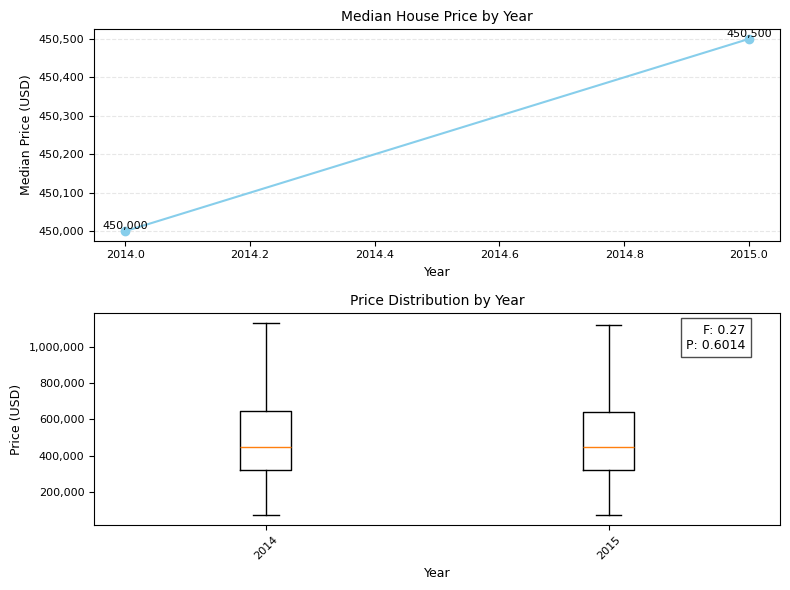

C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\714425753.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=box_labels, showfliers=False)


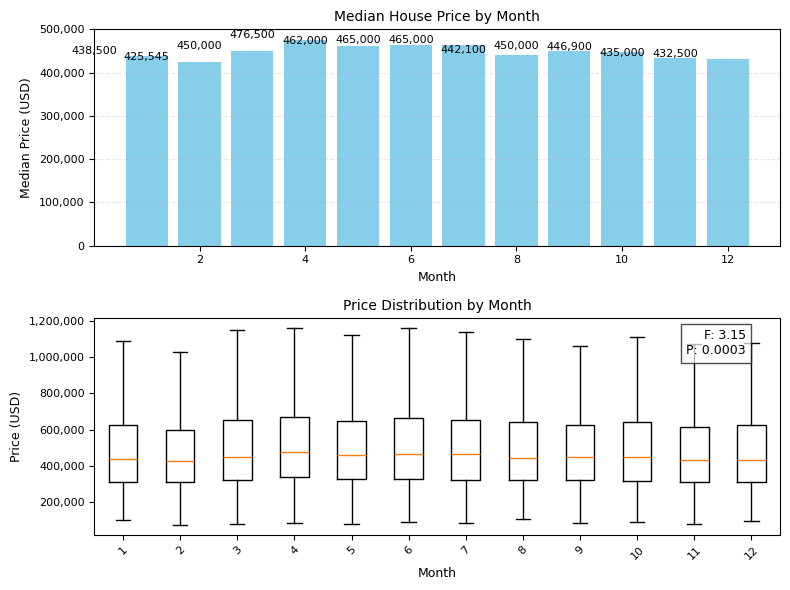

C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\714425753.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(box_data, labels=box_labels, showfliers=False)


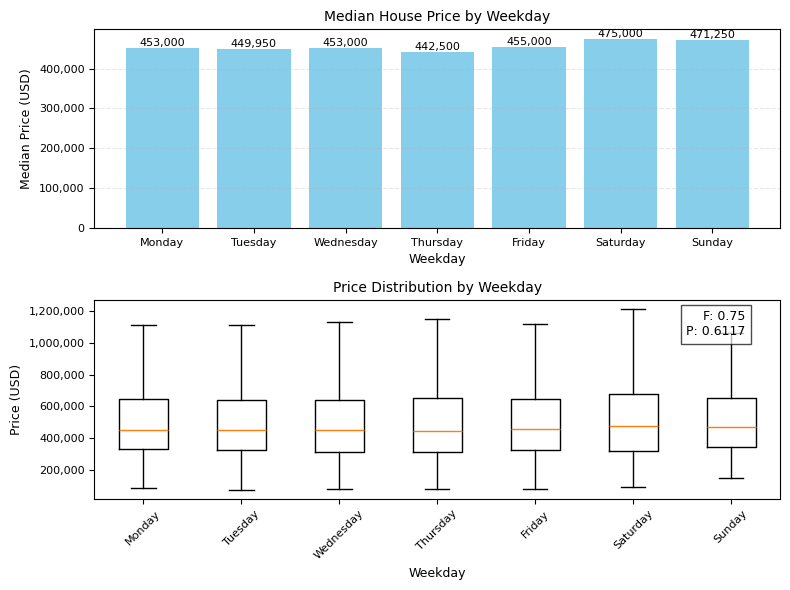

ANOVA Results:
{'Yearly ANOVA': {'F-Value': np.float64(0.27296794403474733), 'P-Value': np.float64(0.6013531188200092)}, 'Monthly ANOVA': {'F-Value': np.float64(3.1465447908516353), 'P-Value': np.float64(0.00028931058953811893)}, 'Weekday ANOVA': {'F-Value': np.float64(0.7470587748879264), 'P-Value': np.float64(0.6117011740010547)}}


In [35]:
# Convert 'sale_date' to datetime
innercity_data['sale_date'] = pd.to_datetime(innercity_data['sale_date'])
innercity_data['year'] = innercity_data['sale_date'].dt.year
innercity_data['month'] = innercity_data['sale_date'].dt.month
innercity_data['weekday'] = innercity_data['sale_date'].dt.day_name()

# Aggregate trends
yearly_trend = innercity_data.groupby('year')['price'].median().reset_index()
monthly_trend = innercity_data.groupby('month')['price'].median().reset_index()
weekday_trend = innercity_data.groupby('weekday')['price'].median().reset_index()

# Sorting weekdays for proper order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_trend['weekday'] = pd.Categorical(weekday_trend['weekday'], categories=weekday_order, ordered=True)
weekday_trend = weekday_trend.sort_values('weekday')

# Helper function for plotting trend and boxplot in one image
def plot_trend_and_box(trend_data, trend_title, trend_xlabel, trend_ylabel,
                       box_data, box_labels, box_title, box_xlabel, box_ylabel,
                       filename, anova_f, anova_p):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 1]})
    
    # Plot trend
    if 'weekday' in trend_data.columns or 'month' in trend_data.columns:
        axes[0].bar(trend_data.iloc[:, 0], trend_data['price'], color='skyblue')
        for i, value in enumerate(trend_data['price']):
            axes[0].text(i, value, f"{value:,.0f}", ha='center', va='bottom', fontsize=8)
    else:
        axes[0].plot(trend_data.iloc[:, 0], trend_data['price'], marker='o', color='skyblue', linestyle='-')
        for x, y in zip(trend_data.iloc[:, 0], trend_data['price']):
            axes[0].text(x, y, f"{y:,.0f}", ha='center', va='bottom', fontsize=8)
    
    axes[0].set_title(trend_title, fontsize=10)
    axes[0].set_xlabel(trend_xlabel, fontsize=9)
    axes[0].set_ylabel(trend_ylabel, fontsize=9)
    axes[0].tick_params(axis='x', labelsize=8)
    axes[0].tick_params(axis='y', labelsize=8)
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Plot boxplot
    axes[1].boxplot(box_data, labels=box_labels, showfliers=False)
    axes[1].set_title(box_title, fontsize=10)
    axes[1].set_xlabel(box_xlabel, fontsize=9)
    axes[1].set_ylabel(box_ylabel, fontsize=9)
    axes[1].tick_params(axis='x', labelsize=8, rotation=45)
    axes[1].tick_params(axis='y', labelsize=8)
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Annotate ANOVA F-value and p-value
    axes[1].text(0.95, 0.95, f"F: {anova_f:.2f}\nP: {anova_p:.4f}",
                 ha='right', va='top', transform=axes[1].transAxes,
                 fontsize=9, bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
    
    plt.tight_layout()
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

# Statistical Significance Tests
# ANOVA for Yearly Price Differences
year_groups = [innercity_data[innercity_data['year'] == y]['price'].dropna() for y in yearly_trend['year']]
anova_year = f_oneway(*year_groups)

# ANOVA for Monthly Price Differences
month_groups = [innercity_data[innercity_data['month'] == m]['price'].dropna() for m in range(1, 13)]
anova_month = f_oneway(*month_groups)

# ANOVA for Weekday Price Differences
weekday_groups = [innercity_data[innercity_data['weekday'] == day]['price'].dropna() for day in weekday_order]
anova_weekday = f_oneway(*weekday_groups)

# Plot Yearly Trend and Boxplot
plot_trend_and_box(
    trend_data=yearly_trend,
    trend_title="Median House Price by Year",
    trend_xlabel="Year",
    trend_ylabel="Median Price (USD)",
    box_data=[innercity_data[innercity_data['year'] == y]['price'].dropna() for y in yearly_trend['year']],
    box_labels=yearly_trend['year'],
    box_title="Price Distribution by Year",
    box_xlabel="Year",
    box_ylabel="Price (USD)",
    filename=".\\images\\yearly_price.svg",
    anova_f=anova_year.statistic,
    anova_p=anova_year.pvalue
)

# Plot Monthly Trend and Boxplot
plot_trend_and_box(
    trend_data=monthly_trend,
    trend_title="Median House Price by Month",
    trend_xlabel="Month",
    trend_ylabel="Median Price (USD)",
    box_data=[innercity_data[innercity_data['month'] == m]['price'].dropna() for m in range(1, 13)],
    box_labels=list(range(1, 13)),
    box_title="Price Distribution by Month",
    box_xlabel="Month",
    box_ylabel="Price (USD)",
    filename=".\\images\\monthly_price.svg",
    anova_f=anova_month.statistic,
    anova_p=anova_month.pvalue
)

# Plot Weekday Trend and Boxplot
plot_trend_and_box(
    trend_data=weekday_trend,
    trend_title="Median House Price by Weekday",
    trend_xlabel="Weekday",
    trend_ylabel="Median Price (USD)",
    box_data=[innercity_data[innercity_data['weekday'] == day]['price'].dropna() for day in weekday_order],
    box_labels=weekday_order,
    box_title="Price Distribution by Weekday",
    box_xlabel="Weekday",
    box_ylabel="Price (USD)",
    filename=".\\images\\weekday_price.svg",
    anova_f=anova_weekday.statistic,
    anova_p=anova_weekday.pvalue
)

# Print ANOVA Results
anova_results = {
    "Yearly ANOVA": {"F-Value": anova_year.statistic, "P-Value": anova_year.pvalue},
    "Monthly ANOVA": {"F-Value": anova_month.statistic, "P-Value": anova_month.pvalue},
    "Weekday ANOVA": {"F-Value": anova_weekday.statistic, "P-Value": anova_weekday.pvalue},
}
print("ANOVA Results:")
print(anova_results)


## Removal of unwanted variables (if applicable) 
### Univariate Analysis of Continuous Variables done above
#### Descriptive statistics reveal significant variability among variables:
- price: Ranges from $75,000 to $7,700,000, with a median of $450,000.
- basement_area_sqft: Many zero values indicate missing or unused spaces.
- lot_area_sqft and lot_area_2015_sqft: Extremely high ranges (up to over 1.6 million square feet) but weak relevance to price.
### Bivariate Analysis done above
#### Correlation Heatmap (Continuous Variables vs. price):
- Strong positive correlations: living_area_sqft, above_ground_area_sqft, total_area.
- Weak correlations: lot_area_sqft and lot_area_2015_sqft show negligible relationships with price (<0.1 correlation).
#### ANOVA (Categorical Variables vs. price):
- Statistically significant variables (p-value < 0.05):
- Strong predictors: furnished, waterfront_view, construction_grade, and views have very high F-statistics.
- Location impact: zipcode shows significant variance in price.
- Time-related features: year_built and year_renovated significantly affect price.
#### ANOVA (Time Periods vs. price):
- Year and weekday is not statistically significant with P-value 0.60 and 0.61 respectively
- Month and Week is statistically significant with P-value 0 and 0 respectively.
### Recommendations for Variable Removal
#### Continuous Variables
- lot_area_sqft and lot_area_2015_sqft
- Extremely weak correlation with price (<0.1)
- ikely not contributing meaningful information to analysis or predictive models.
#### Categorical Variables
- Retain all categorical variables
- All variables show statistically significant relationships with price (p-value < 0.05)
#### Time variables
- Year and weekday not statistically significant
#### Latitude, Longitude and Zipcode
- Retain zipcode as it provides a meaningful grouping for geographic data.
- latitude and longitude can be dropped because They have low direct correlation with price.

In [36]:
innercity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21505 non-null  Int64         
 4   num_bathrooms_per_bedroom  21505 non-null  float64       
 5   living_area_sqft           21596 non-null  float64       
 6   lot_area_sqft              21571 non-null  float64       
 7   num_floors                 21541 non-null  category      
 8   waterfront_view            21582 non-null  category      
 9   views                      21556 non-null  category      
 10  condition                  21528 non-null  category      
 11  construction_grade         21612 non-null  category      
 12  abov

In [37]:
drop_cols = ['lot_area_sqft','lot_area_2015_sqft','year','day','weekday','latitude','longitude','week']
innercity_data_removed_cols = innercity_data.drop(columns=drop_cols).copy()
innercity_data_removed_cols.head().T

0                    1  \
house_id                            3876100940           3145600250   
sale_date                  2015-04-27 00:00:00  2015-03-17 00:00:00   
price                                 600000.0             190000.0   
num_bedrooms_per_house                       4                    2   
num_bathrooms_per_bedroom                 1.75                  1.0   
living_area_sqft                        3050.0                670.0   
num_floors                                 1.0                  1.0   
waterfront_view                              0                    0   
views                                        0                    0   
condition                                    3                    4   
construction_grade                           8                    6   
above_ground_area_sqft                  1800.0                670.0   
basement_area_sqft                      1250.0                  0.0   
year_built                              1966.0               1948.0   
year_renovated                               0                    0   
zipcode                                  98034                98118   
living_area_2015_sqft                   2020.0               1660.0   
furnished                                    0                    0   
total_area                             12490.0               3771.0   
has_basement                                 1                    0   
month                                        4                    3   

                                             2                    3  \
house_id                            7129303070           7338220280   
sale_date                  2014-08-20 00:00:00  2014-10-10 00:00:00   
price                                 735000.0             257000.0   
num_bedrooms_per_house                       4                    3   
num_bathrooms_per_bedroom                 2.75                  2.5   
living_area_sqft                        3040.0               1740.0   
num_floors                                 2.0                  2.0   
waterfront_view                              1                    0   
views                                        4                    0   
condition                                    3                    3   
construction_grade                           8                    8   
above_ground_area_sqft                  3040.0               1740.0   
basement_area_sqft                         0.0                  0.0   
year_built                              1966.0               2009.0   
year_renovated                               0                    0   
zipcode                                  98118                98002   
living_area_2015_sqft                   2620.0               2030.0   
furnished                                    0                    0   
total_area                              5455.0               5461.0   
has_basement                                 0                    0   
month                                        8                   10   

                                             4  
house_id                            7950300670  
sale_date                  2015-02-18 00:00:00  
price                                 450000.0  
num_bedrooms_per_house                       2  
num_bathrooms_per_bedroom                  1.0  
living_area_sqft                        1120.0  
num_floors                                 1.0  
waterfront_view                              0  
views                                        0  
condition                                    3  
construction_grade                           7  
above_ground_area_sqft                  1120.0  
basement_area_sqft                         0.0  
year_built                              1924.0  
year_renovated                               0  
zipcode                                  98118  
living_area_2015_sqft                   1120.0  
furnished                            

In [38]:
innercity_data_removed_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21505 non-null  Int64         
 4   num_bathrooms_per_bedroom  21505 non-null  float64       
 5   living_area_sqft           21596 non-null  float64       
 6   num_floors                 21541 non-null  category      
 7   waterfront_view            21582 non-null  category      
 8   views                      21556 non-null  category      
 9   condition                  21528 non-null  category      
 10  construction_grade         21612 non-null  category      
 11  above_ground_area_sqft     21612 non-null  float64       
 12  base

## Missing Value treatment (if applicable)
### Continuous Columns
- living_area_2015_sqft KNN imputation Reason: Likely correlated with living_area_sqft, total_area, or other spatial dimensions
- total_area Method KNN imputation Reason: Strong correlation with living_area_sqft, above_ground_area_sqft, and basement_area_sqft.
- living_area_sqft KNN imputation Reason: Strong correlations with spatial columns like total_area make KNN effective here
- above_ground_area_sqft and basement_area_sqft Median imputation Reason: Minimal missing values; simple methods are sufficient.
- num_bedrooms_per_house Median imputation Reason: Bedroom counts are typically discrete values with low variance, making the median robust against outliers.
- num_bathrooms_per_bedroom Median imputation. Reason: Similar to bedrooms, bathrooms often follow patterns that median handles well.

### Categorical Columns
- num_floors Mode Imputation Reason: The number of floors is a discrete categorical-like variable with likely a small number of unique values (e.g., 1, 2, 3). The mode represents the most common category, which is usually the safest choice for such variables.
- waterfront_view Mode Imputation Reason: This is likely a binary feature (0 for no, 1 for yes), making mode imputation straightforward and effective. If most properties do not have a waterfront view, the mode will likely be 0.
- furnished Mode Imputation Reason: Furnished status is typically binary (0 for no, 1 for yes). Mode imputation is effective here, especially if the dataset shows a clear majority class.
- year_built Mode Imputation Reason:treated as a categorical feature (common build years like 2000, 1990, etc.), mode imputation is suitable.
- construction_grade Mode Imputation Reason: Only one missing value exists. The mode is the most efficient and practical solution for imputing this column.
- views KNN Imputation Reason: KNN imputation is preferred as it can utilize correlations with other features like waterfront_view or living_area_sqft.
- condition KNN Imputation Reason: there are correlations between condition and other features (e.g., construction_grade, views, price), KNN can use these relationships for more accurate imputation.



living_area_2015_sqft        166
num_bedrooms_per_house       108
num_bathrooms_per_bedroom    108
condition                     85
num_floors                    72
total_area                    68
views                         57
waterfront_view               31
furnished                     29
living_area_sqft              17
year_built                    15
construction_grade             1
basement_area_sqft             1
above_ground_area_sqft         1
sale_date                      0
house_id                       0
price                          0
zipcode                        0
year_renovated                 0
has_basement                   0
month                          0
dtype: int64
Number of Overall Missing Values: 759
Highest Percentage of Missing Values in a Column: 0.77%
Number of Overall Cell Values: 453873
Percentage of Missing Values: 0.17%


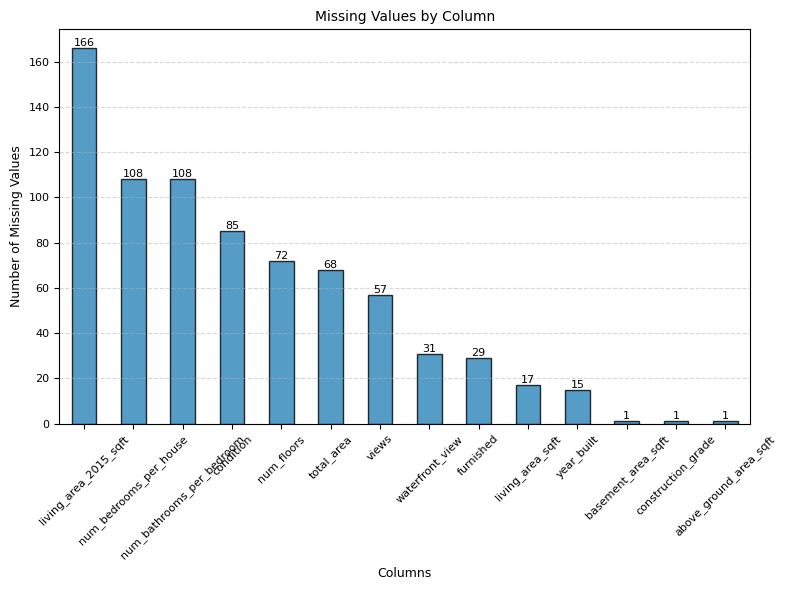

Continuous Columns with Missing Values: ['living_area_2015_sqft', 'num_bedrooms_per_house', 'num_bathrooms_per_bedroom', 'total_area', 'living_area_sqft', 'above_ground_area_sqft', 'basement_area_sqft']
Categorical Columns with Missing Values: ['num_floors', 'views', 'waterfront_view', 'furnished', 'year_built', 'construction_grade', 'condition']


In [39]:
# Calculate missing values
missing_values = innercity_data_removed_cols.isnull().sum()
total_missing_values = missing_values.sum()
total_cells = innercity_data_removed_cols.shape[0] * innercity_data_removed_cols.shape[1]
highest_percentage = missing_values.max() / innercity_data_removed_cols.shape[0]
percentage_missing = total_missing_values / total_cells

# Print missing value statistics
print(missing_values.sort_values(ascending=False))
print(f'Number of Overall Missing Values: {total_missing_values}')
print(f'Highest Percentage of Missing Values in a Column: {highest_percentage:.2%}')
print(f'Number of Overall Cell Values: {total_cells}')
print(f'Percentage of Missing Values: {percentage_missing:.2%}')

# Filter columns with missing values
missing_columns = missing_values[missing_values > 0].sort_values(ascending=False)

# Visualization: Bar plot for missing values with data labels
plt.figure(figsize=(8, 6))  # Consistent figure size
bars = missing_columns.plot(kind='bar', color='#2b83ba', alpha=0.8, edgecolor='black')  # Muted blue
plt.title('Missing Values by Column', fontsize=10, color='black')
plt.xlabel('Columns', fontsize=9, color='black')
plt.ylabel('Number of Missing Values', fontsize=9, color='black')
plt.xticks(rotation=45, fontsize=8, color='black')
plt.yticks(fontsize=8, color='black')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add data labels to bars
for idx, value in enumerate(missing_columns):
    plt.text(idx, value, f"{value}", ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.savefig(".\\images\\missing_values_by_column.svg", format="svg", dpi=300)
plt.show()

# Split columns into continuous and categorical missing columns
continuous_missing_cols = ['living_area_2015_sqft', 'num_bedrooms_per_house', 'num_bathrooms_per_bedroom', 
                            'total_area', 'living_area_sqft', 'above_ground_area_sqft', 'basement_area_sqft']
categorical_missing_cols = ['num_floors', 'views', 'waterfront_view', 'furnished', 
                            'year_built', 'construction_grade', 'condition']

# Print the categorized columns
print(f"Continuous Columns with Missing Values: {continuous_missing_cols}")
print(f"Categorical Columns with Missing Values: {categorical_missing_cols}")

In [40]:
# Columns requiring median imputation
columns_to_impute = ['above_ground_area_sqft', 'basement_area_sqft', 
                     'num_bedrooms_per_house', 'num_bathrooms_per_bedroom']

# Impute missing values with the median
for column in columns_to_impute:
    median_value = innercity_data_removed_cols[column].median()  # Calculate the median
    innercity_data_removed_cols[column].fillna(median_value, inplace=True)  # Impute missing values

# Verify imputation
missing_after_imputation = innercity_data_removed_cols[columns_to_impute].isnull().sum()
print("Missing values after median imputation:\n", missing_after_imputation)

Missing values after median imputation:
 above_ground_area_sqft       0
basement_area_sqft           0
num_bedrooms_per_house       0
num_bathrooms_per_bedroom    0
dtype: int64


C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\3107269150.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  innercity_data_removed_cols[column].fillna(median_value, inplace=True)  # Impute missing values
C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\3107269150.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

In [41]:
# Select the columns for KNN Imputation
columns_to_impute = ['living_area_2015_sqft', 'total_area', 'living_area_sqft']

# Subset the dataset to include only relevant columns for imputation
imputation_data = innercity_data_removed_cols[columns_to_impute]

# Initialize the KNN Imputer (e.g., k=5 neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data to impute missing values
imputed_data = knn_imputer.fit_transform(imputation_data)

# Replace the original columns with the imputed values
innercity_data_removed_cols[columns_to_impute] = imputed_data

# Verify imputation
missing_after_imputation = innercity_data_removed_cols[columns_to_impute].isnull().sum()
print("Missing values after KNN imputation:\n", missing_after_imputation)

Missing values after KNN imputation:
 living_area_2015_sqft    0
total_area               0
living_area_sqft         0
dtype: int64


In [42]:
# List of columns to impute using mode
columns_to_impute = ['num_floors', 'waterfront_view', 'furnished', 'year_built', 'construction_grade']

# Perform mode imputation for each column
for column in columns_to_impute:
    mode_value = innercity_data_removed_cols[column].mode()[0]  # Calculate the mode
    innercity_data_removed_cols[column].fillna(mode_value, inplace=True)  # Fill missing values with the mode

# Verify imputation
missing_after_imputation = innercity_data_removed_cols[columns_to_impute].isnull().sum()
print("Missing values after mode imputation:\n", missing_after_imputation)

Missing values after mode imputation:
 num_floors            0
waterfront_view       0
furnished             0
year_built            0
construction_grade    0
dtype: int64


C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\123881863.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  innercity_data_removed_cols[column].fillna(mode_value, inplace=True)  # Fill missing values with the mode


In [43]:
# Select relevant columns for KNN Imputation, including correlated features
knn_imputation_columns = ['views', 'waterfront_view', 'living_area_sqft','price']

# Subset the dataset to include relevant columns
imputation_data = innercity_data_removed_cols[knn_imputation_columns]

# Scale the data for better KNN results
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(imputation_data)

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)


# Apply KNN Imputation on scaled data
imputed_scaled_data = knn_imputer.fit_transform(scaled_data)

# Reverse the scaling
imputed_data = scaler.inverse_transform(imputed_scaled_data)

# Replace the 'views' column with the imputed values
innercity_data_removed_cols['views'] = imputed_data[:, 0]
innercity_data_removed_cols['views'] = innercity_data_removed_cols['views'].round()

# Verify imputation
missing_after_imputation = innercity_data_removed_cols['views'].isnull().sum()
print("Missing values in 'views' after KNN imputation:", missing_after_imputation)

Missing values in 'views' after KNN imputation: 0


In [44]:
print(innercity_data_removed_cols['views'].value_counts())

views
0.0    19483
2.0      960
3.0      510
1.0      342
4.0      318
Name: count, dtype: int64


In [45]:
# Select relevant columns for KNN Imputation
knn_imputation_columns = ['condition', 'basement_area_sqft', 'views', 'price']

# Subset the dataset to include relevant columns
imputation_data = innercity_data_removed_cols[knn_imputation_columns]

# Scale the data for KNN
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(imputation_data)

# Initialize the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN Imputation on scaled data
imputed_scaled_data = knn_imputer.fit_transform(scaled_data)

# Reverse the scaling for imputed data
imputed_data = scaler.inverse_transform(imputed_scaled_data)

# Replace the 'condition' column with imputed values
innercity_data_removed_cols['condition'] = imputed_data[:, 0]
innercity_data_removed_cols['condition'] = innercity_data_removed_cols['condition'].round()

# Verify imputation
missing_after_imputation = innercity_data_removed_cols['condition'].isnull().sum()
print("Missing values in 'condition' after KNN imputation:", missing_after_imputation)

Missing values in 'condition' after KNN imputation: 0


In [46]:
print(innercity_data_removed_cols['condition'].value_counts())

condition
3.0    14035
4.0     5683
5.0     1694
2.0      171
1.0       30
Name: count, dtype: int64


In [47]:
missing_values = innercity_data_removed_cols.isnull().sum()
print(missing_values.sort_values(ascending=False))
print(f'Number of Overall Missing values {innercity_data_removed_cols.isnull().sum().sum()}')
print(f'Highest Percentage of missing value in a column {166/innercity_data_removed_cols.shape[0]}')
print(f'Number of Overall cell values {innercity_data_removed_cols.shape[0]*innercity_data_removed_cols.shape[1]}')
print(f'Percentage of missing values {innercity_data_removed_cols.isnull().sum().sum()/(innercity_data_removed_cols.shape[0]*innercity_data_removed_cols.shape[1])}')

house_id                     0
sale_date                    0
price                        0
num_bedrooms_per_house       0
num_bathrooms_per_bedroom    0
living_area_sqft             0
num_floors                   0
waterfront_view              0
views                        0
condition                    0
construction_grade           0
above_ground_area_sqft       0
basement_area_sqft           0
year_built                   0
year_renovated               0
zipcode                      0
living_area_2015_sqft        0
furnished                    0
total_area                   0
has_basement                 0
month                        0
dtype: int64
Number of Overall Missing values 0
Highest Percentage of missing value in a column 0.007680562624346458
Number of Overall cell values 453873
Percentage of missing values 0.0


## Outlier treatment (if required)
### Continous Variables
- above_ground_area_sqft  Replace with Median Reason:  With relatively low outlier percentage, replacing extreme values with the median preserves central tendencies without introducing skewness.
- living_area_sqft Replace with Median Reason: Similar to above_ground_area_sqft, the low outlier percentage justifies replacing extreme values with the median to avoid overfitting.
- num_bathrooms_per_bedroom Replace with Median Reason: The distribution is typically narrow for this type of feature, and extreme values likely represent data entry errors or unique cases. Median is a robust choice.
- num_bedrooms_per_house Replace with Median Reason: Similar logic to num_bathrooms_per_bedroom.
- basement_area_sqft  Replace with Median Reason: Basement sizes typically follow a narrow range. Replacing outliers with the median avoids introducing noise.
- living_area_2015_sqft  KNN Imputation Reason: As a spatial metric, living_area_2015_sqft is influenced by related features like living_area_sqft, basement_area_sqft, and total_area.
- total_area KNN Imputation Reason: total_area is highly correlated with other features like living_area_sqft, basement_area_sqft, and num_bedrooms_per_house. KNN imputation will use these features to replace outliers with realistic values.
### Outliers Before
| Column                     | Outlier Count | Total Count | Outlier %  |
|----------------------------|---------------|-------------|------------|
| total_area                | 2423.0        | 21613.0     | 11.210845  |
| price                     | 1159.0        | 21613.0     |  5.362513  |
| above_ground_area_sqft    |  611.0        | 21613.0     |  2.827002  |
| living_area_sqft          |  572.0        | 21613.0     |  2.646555  |
| num_bathrooms_per_bedroom |  569.0        | 21613.0     |  2.632675  |
| num_bedrooms_per_house    |  542.0        | 21613.0     |  2.507750  |
| living_area_2015_sqft     |  542.0        | 21613.0     |  2.507750  |
| basement_area_sqft        |  496.0        | 21613.0     |  2.294915  |

**Total Outliers**: 6914.0  
**Total Values**: 453873  
**Overall Outlier %**: 1.5233336197570686
### Outliers After
| Column                      | Outlier Count | Total Count | Outlier %       |
|-----------------------------|---------------|-------------|-----------------|
| basement_area_sqft          | 351.0         | 21613.0     | 1.624023        |
| above_ground_area_sqft      | 302.0         | 21613.0     | 1.397307        |
| living_area_sqft            | 211.0         | 21613.0     | 0.976264        |
| total_area                  | 59.0          | 21613.0     | 0.272984        |
| living_area_2015_sqft       | 11.0          | 21613.0     | 0.050895        |
| num_bedrooms_per_house      | 0.0           | 21613.0     | 0.000000        |
| num_bathrooms_per_bedroom   | 0.0           | 21613.0     | 0.000000        |
| **Total Outliers**          | **934.0**     |             |                 |
| **Total Values**            | **453873**    |             |                 |
| **Overall Outlier %**       |               |             | **0.300304**  |

In [48]:
innercity_data_missing_treated = innercity_data_removed_cols.copy()
innercity_data_missing_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21613 non-null  Int64         
 4   num_bathrooms_per_bedroom  21613 non-null  float64       
 5   living_area_sqft           21613 non-null  float64       
 6   num_floors                 21613 non-null  category      
 7   waterfront_view            21613 non-null  category      
 8   views                      21613 non-null  float64       
 9   condition                  21613 non-null  float64       
 10  construction_grade         21613 non-null  category      
 11  above_ground_area_sqft     21613 non-null  float64       
 12  base

In [49]:
# Check for NaN values in the entire dataset
nan_summary = innercity_data_missing_treated.isnull().sum()

# Print the columns with NaN values
print("Columns with NaN values:")
print(nan_summary[nan_summary > 0])

# Print the total number of NaN values
total_nan = innercity_data_missing_treated.isnull().sum().sum()
print(f"\nTotal number of NaN values: {total_nan}")

Columns with NaN values:
Series([], dtype: int64)

Total number of NaN values: 0


In [50]:
data_types = {
    "house_id": "category",
    "price": "float64",
    "num_bedrooms_per_house": "Int64",  # Nullable integer for missing values
    "num_bathrooms_per_bedroom": "float64",
    "living_area_sqft": "float64",
    "num_floors": "category",
    "waterfront_view": "category",  # Binary as integer (0/1)
    "views": "category",
    "condition": "category",
    "construction_grade": "category",
    "above_ground_area_sqft": "float64",
    "basement_area_sqft": "float64",
    "year_built": "category",
    "year_renovated": "category",
    "zipcode": "category",
    "living_area_2015_sqft": "float64",
    "furnished": "category",  # Binary as integer (0/1)
    "total_area": "float64",
    "has_basement": "category"
}

innercity_data_missing_treated = innercity_data_missing_treated.astype(data_types)

# Define meaningful bins or categories
floors_order = [1, 1.5, 2, 2.5, 3, 3.5]  # Based on possible values
water_front_view_order = [0,1]
views_order = [0,1, 2, 3, 4, 5] # Assuming 0=Poor to 5=Excellent
condition_order = [1, 2, 3, 4, 5]  # Assuming 1=Poor to 5=Excellent
construction_grade_order = list(range(1, 14))  # Assuming grades 1 to 13 
furnished_order = [0,1]
has_basement_order = [0,1]    


# Create CategoricalDtype for each ordinal variable
floors_dtype = CategoricalDtype(categories=floors_order, ordered=True)
water_front_view_dtype = CategoricalDtype(categories=water_front_view_order, ordered=True)
views_dtype = CategoricalDtype(categories=views_order, ordered=True)
condition_dtype = CategoricalDtype(categories=condition_order, ordered=True)
construction_grade_dtype = CategoricalDtype(categories=construction_grade_order, ordered=True)
furnished_dtype = CategoricalDtype(categories=furnished_order, ordered=True)
has_basement_dtype = CategoricalDtype(categories=has_basement_order, ordered=True)

# Check for NaN values in the entire dataset
nan_summary = innercity_data_missing_treated.isnull().sum()

# Print the columns with NaN values
print("Columns with NaN values:")
print(nan_summary[nan_summary > 0])

# Print the total number of NaN values
total_nan = innercity_data_missing_treated.isnull().sum().sum()
print(f"\nTotal number of NaN values: {total_nan}")



# Convert columns to ordinal categorical
innercity_data_missing_treated['num_floors'] = innercity_data_missing_treated['num_floors'].astype(floors_dtype)
innercity_data_missing_treated['waterfront_view'] = innercity_data_missing_treated['waterfront_view'].astype(water_front_view_dtype)
innercity_data_missing_treated['views'] = innercity_data_missing_treated['views'].astype(views_dtype)
innercity_data_missing_treated['condition'] = innercity_data_missing_treated['condition'].astype(condition_dtype)
innercity_data_missing_treated['construction_grade'] = innercity_data_missing_treated['construction_grade'].astype(construction_grade_dtype)
innercity_data_missing_treated['furnished'] = innercity_data_missing_treated['furnished'].astype(furnished_dtype)
innercity_data_missing_treated['has_basement'] = innercity_data_missing_treated['has_basement'].astype(has_basement_dtype)
innercity_data_missing_treated.info()

Columns with NaN values:
Series([], dtype: int64)

Total number of NaN values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21613 non-null  Int64         
 4   num_bathrooms_per_bedroom  21613 non-null  float64       
 5   living_area_sqft           21613 non-null  float64       
 6   num_floors                 21613 non-null  category      
 7   waterfront_view            21613 non-null  category      
 8   views                      21613 non-null  category      
 9   condition                  21613 non-null  category      
 10  construction_grade         21613 non-null  catego

In [51]:
# Check for NaN values in the entire dataset
nan_summary = innercity_data_missing_treated.isnull().sum()

# Print the columns with NaN values
print("Columns with NaN values:")
print(nan_summary[nan_summary > 0])

# Print the total number of NaN values
total_nan = innercity_data_missing_treated.isnull().sum().sum()
print(f"\nTotal number of NaN values: {total_nan}")

Columns with NaN values:
Series([], dtype: int64)

Total number of NaN values: 0


<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\3869956322.py:35: SyntaxWarning: invalid escape sequence '\d'
  outlier_summary_df.to_csv('.\data\output\outlier_summary.csv', index=False)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\kurtg\App

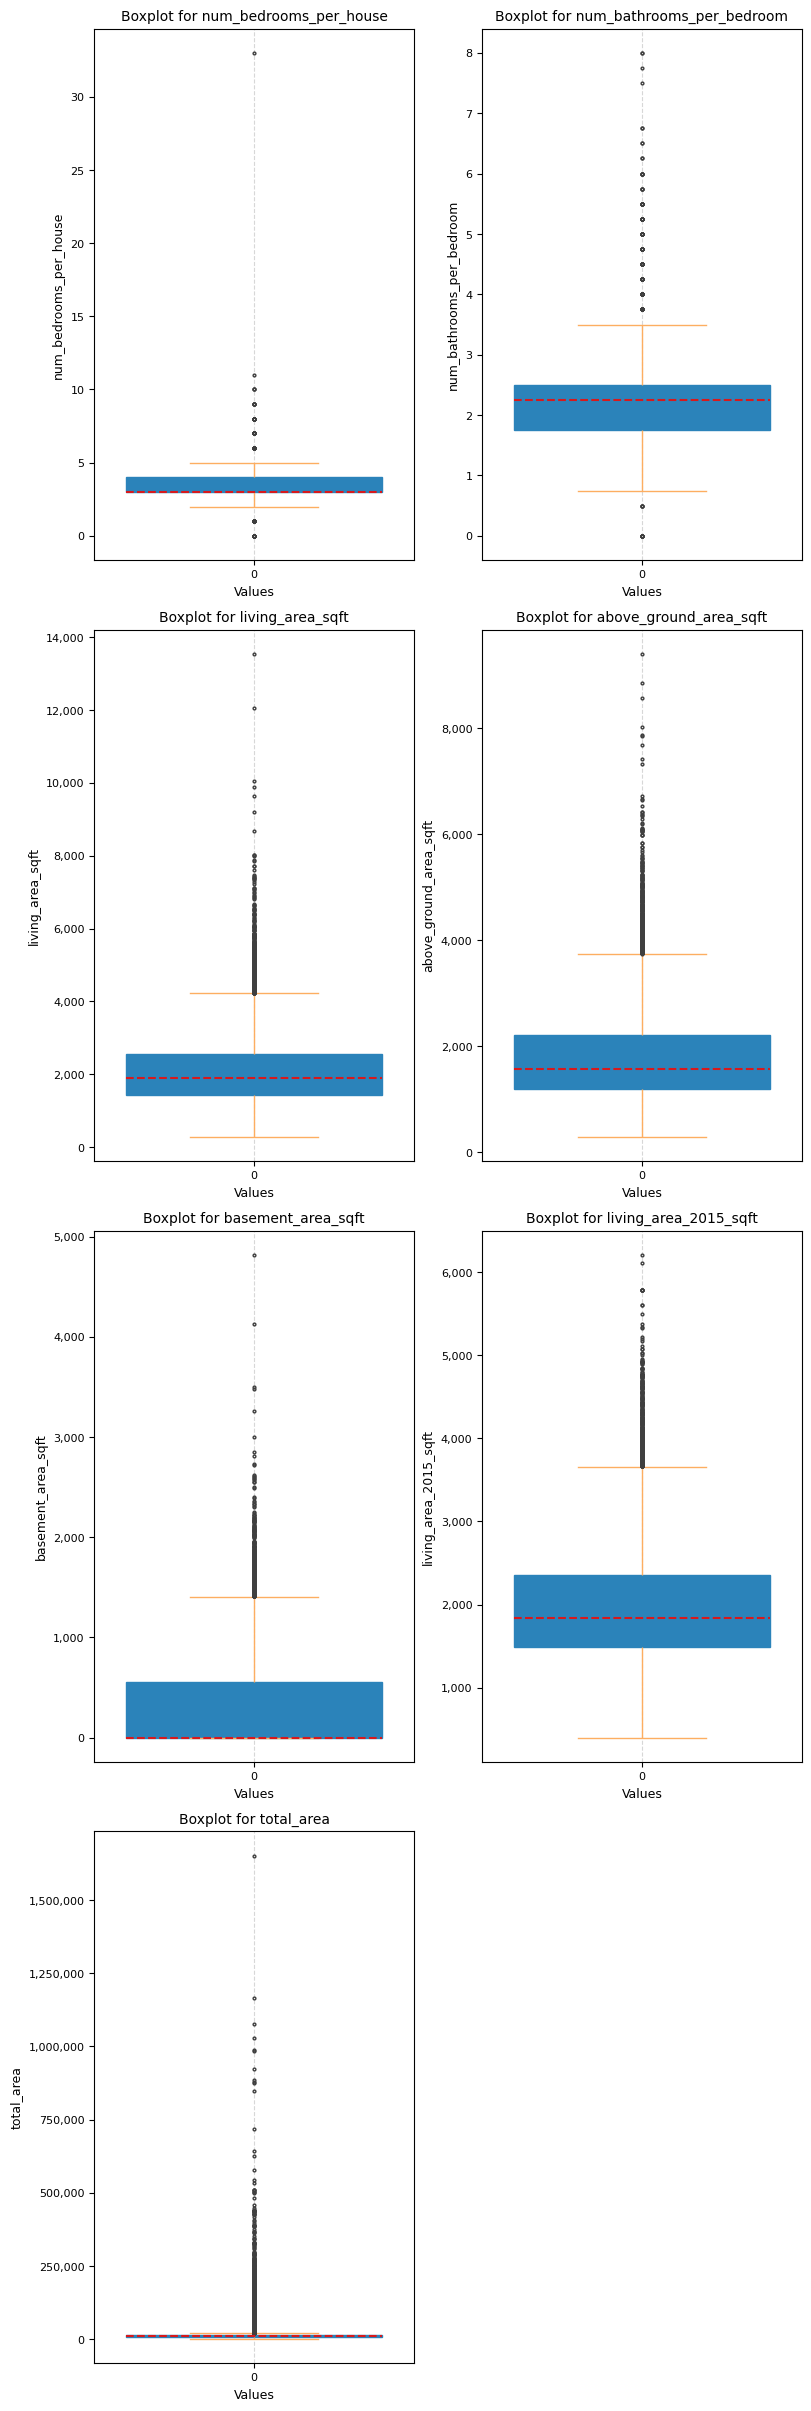

                      Column  Outlier Count  Total Count  Outlier %
6                 total_area         2423.0      21613.0  11.210845
3     above_ground_area_sqft          611.0      21613.0   2.827002
2           living_area_sqft          572.0      21613.0   2.646555
1  num_bathrooms_per_bedroom          569.0      21613.0   2.632675
0     num_bedrooms_per_house          542.0      21613.0   2.507750
5      living_area_2015_sqft          542.0      21613.0   2.507750
4         basement_area_sqft          496.0      21613.0   2.294915
Total Outliers: 5755.0
Total Values: 453873
Overall Outlier %: 1.27%


In [52]:
# Identify numerical columns
numerical_columns = innercity_data_missing_treated.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = numerical_columns.drop('price')

# Initialize an outlier summary
outlier_summary = {}

# Detect outliers using the IQR method and store the results
for column in numerical_columns:
    Q1 = innercity_data_missing_treated[column].quantile(0.25)
    Q3 = innercity_data_missing_treated[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = innercity_data_missing_treated[(innercity_data_missing_treated[column] < lower_bound) | 
                                              (innercity_data_missing_treated[column] > upper_bound)]
    outlier_count = len(outliers)
    total_count = len(innercity_data_missing_treated[column])
    
    # Store the percentage of outliers
    outlier_summary[column] = {
        'Outlier Count': outlier_count,
        'Total Count': total_count,
        'Outlier %': (outlier_count / total_count) * 100 if total_count > 0 else 0
    }

# Convert the outlier summary into a DataFrame for better visualization
outlier_summary_df = pd.DataFrame(outlier_summary).T
outlier_summary_df.reset_index(inplace=True)
outlier_summary_df.rename(columns={'index': 'Column'}, inplace=True)

# Save outlier summary for reference
outlier_summary_df.to_csv('.\data\output\outlier_summary.csv', index=False)

# Visualize outliers using boxplots with consistent aesthetics and horizontal orientation
rows = (len(numerical_columns) + 1) // 2  # Calculate number of rows for subplots
fig, axes = plt.subplots(rows, 2, figsize=(8, 6 * rows), constrained_layout=True)
axes = axes.flatten()

# Define aesthetics
box_color = '#2b83ba'  # Muted blue
whisker_color = '#fdae61'  # Muted orange
median_color = '#d7191c'  # Muted red
outlier_marker_size = 2  # Reduced marker size

for i, column in enumerate(numerical_columns):
    sns.boxplot(
        data=innercity_data_missing_treated, y=column, ax=axes[i],
        boxprops=dict(color=box_color),  # Box color
        whiskerprops=dict(color=whisker_color),  # Whisker color
        capprops=dict(color=whisker_color),  # Cap color
        medianprops=dict(color=median_color, linestyle='--', linewidth=1.5),  # Median line
        flierprops=dict(marker='o', markersize=outlier_marker_size, color='black', linestyle='none')  # Small dot outliers
    )
    axes[i].set_title(f'Boxplot for {column}', fontsize=10, color='black')
    axes[i].set_ylabel(column, fontsize=9, color='black')
    axes[i].set_xlabel("Values", fontsize=9, color='black')
    axes[i].tick_params(axis='x', labelsize=8, colors='black')
    axes[i].tick_params(axis='y', labelsize=8, colors='black')
    axes[i].grid(axis='x', linestyle='--', alpha=0.5)

    # Ensure non-scientific notation for both x-axis and y-axis labels
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
    axes[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):,}"))

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig(".\\images\\outliers_before_horizontal.svg", format="svg", dpi=300)
plt.show()

# Print outlier summary
print(outlier_summary_df.sort_values(by='Outlier %', ascending=False))
print(f"Total Outliers: {outlier_summary_df['Outlier Count'].sum()}")
print(f"Total Values: {innercity_data_missing_treated.shape[0] * innercity_data_missing_treated.shape[1]}")
print(f"Overall Outlier %: {outlier_summary_df['Outlier Count'].sum() / (innercity_data_missing_treated.shape[0] * innercity_data_missing_treated.shape[1]) * 100:.2f}%")

In [53]:
# List of columns for median imputation
columns_for_median_imputation = [
    'above_ground_area_sqft',
    'living_area_sqft',
    'num_bathrooms_per_bedroom',
    'num_bedrooms_per_house',
    'basement_area_sqft'
]

# Function to replace outliers with median
def replace_outliers_with_median(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Calculate median
    median_value = data[column].median()
    
    # Replace outliers with the median
    data.loc[(data[column] < lower_bound) | (data[column] > upper_bound), column] = median_value

# Apply the function to each specified column
for column in columns_for_median_imputation:
    replace_outliers_with_median(innercity_data_missing_treated, column)

In [54]:
# Variables to use for KNN Imputation
knn_features = ['living_area_sqft', 'basement_area_sqft', 'num_bedrooms_per_house', 'total_area']

# Step 1: Identify outliers in 'total_area' using the IQR method
Q1 = innercity_data_missing_treated['total_area'].quantile(0.25)
Q3 = innercity_data_missing_treated['total_area'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
innercity_data_missing_treated.loc[(innercity_data_missing_treated['total_area'] < lower_bound) | (innercity_data_missing_treated['total_area'] > upper_bound), 'total_area'] = np.nan

# Step 2: Prepare the data for KNN Imputation
knn_data = innercity_data_missing_treated[knn_features]

# Step 3: Scale the data
scaler = StandardScaler()
knn_data_scaled = pd.DataFrame(scaler.fit_transform(knn_data), columns=knn_features)

# Step 4: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
knn_imputed_scaled = imputer.fit_transform(knn_data_scaled)

# Step 5: Reverse the scaling for 'total_area'
knn_imputed = pd.DataFrame(scaler.inverse_transform(knn_imputed_scaled), columns=knn_features)

# Replace the 'total_area' column with the imputed values
innercity_data_missing_treated['total_area'] = knn_imputed['total_area']

In [55]:
# Variables to use for KNN Imputation
knn_features = ['living_area_sqft', 'basement_area_sqft', 'total_area', 'living_area_2015_sqft']

# Step 1: Check correlation to confirm relevance of variables
correlations = innercity_data_missing_treated[knn_features].corr()
print("Correlations between variables:\n", correlations)

# Step 2: Determine if scaling is needed
needs_scaling = any(innercity_data_missing_treated[feature].std() > 10 for feature in knn_features)
if needs_scaling:
    print("Scaling is needed for KNN Imputation.")
else:
    print("Scaling is not needed for KNN Imputation.")

# Step 3: Identify outliers in 'living_area_2015_sqft' using the IQR method
Q1 = innercity_data_missing_treated['living_area_2015_sqft'].quantile(0.25)
Q3 = innercity_data_missing_treated['living_area_2015_sqft'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
innercity_data_missing_treated.loc[(innercity_data_missing_treated['living_area_2015_sqft'] < lower_bound) | (innercity_data_missing_treated['living_area_2015_sqft'] > upper_bound), 'living_area_2015_sqft'] = np.nan

# Step 4: Prepare the data for KNN Imputation
knn_data = innercity_data_missing_treated[knn_features]

# Step 5: Scale the data if needed
if needs_scaling:
    scaler = StandardScaler()
    knn_data_scaled = pd.DataFrame(scaler.fit_transform(knn_data), columns=knn_features)
else:
    knn_data_scaled = knn_data

# Step 6: Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
knn_imputed_scaled = imputer.fit_transform(knn_data_scaled)

# Step 7: Reverse scaling if applied
if needs_scaling:
    knn_imputed = pd.DataFrame(scaler.inverse_transform(knn_imputed_scaled), columns=knn_features)
else:
    knn_imputed = pd.DataFrame(knn_imputed_scaled, columns=knn_features)

# Replace the 'living_area_2015_sqft' column with the imputed values
innercity_data_missing_treated['living_area_2015_sqft'] = knn_imputed['living_area_2015_sqft']

Correlations between variables:
                        living_area_sqft  basement_area_sqft  total_area  \
living_area_sqft               1.000000            0.276600    0.407272   
basement_area_sqft             0.276600            1.000000    0.095568   
total_area                     0.407272            0.095568    1.000000   
living_area_2015_sqft          0.665661            0.079780    0.455353   

                       living_area_2015_sqft  
living_area_sqft                    0.665661  
basement_area_sqft                  0.079780  
total_area                          0.455353  
living_area_2015_sqft               1.000000  
Scaling is needed for KNN Imputation.


In [56]:
data_types = {
    "house_id": "category",
    "price": "float64",
    "num_bedrooms_per_house": "Int64",  # Nullable integer for missing values
    "num_bathrooms_per_bedroom": "float64",
    "living_area_sqft": "float64",
    "num_floors": "category",
    "waterfront_view": "category",  # Binary as integer (0/1)
    "views": "category",
    "condition": "category",
    "construction_grade": "category",
    "above_ground_area_sqft": "float64",
    "basement_area_sqft": "float64",
    "year_built": "category",
    "year_renovated": "category",
    "zipcode": "category",
    "living_area_2015_sqft": "float64",
    "furnished": "category",  # Binary as integer (0/1)
    "total_area": "float64",
    "has_basement": "category"
}

innercity_data_missing_treated = innercity_data_missing_treated.astype(data_types)

# Define meaningful bins or categories
floors_order = [1, 1.5, 2, 2.5, 3, 3.5]  # Based on possible values
water_front_view_order = [0,1]
views_order = [0,1, 2, 3, 4, 5] # Assuming 0=Poor to 5=Excellent
condition_order = [1, 2, 3, 4, 5]  # Assuming 1=Poor to 5=Excellent
construction_grade_order = list(range(1, 14))  # Assuming grades 1 to 13 
furnished_order = [0,1]
has_basement_order = [0,1]                

# Create CategoricalDtype for each ordinal variable
floors_dtype = CategoricalDtype(categories=floors_order, ordered=True)
water_front_view_dtype = CategoricalDtype(categories=water_front_view_order, ordered=True)
views_dtype = CategoricalDtype(categories=views_order, ordered=True)
condition_dtype = CategoricalDtype(categories=condition_order, ordered=True)
construction_grade_dtype = CategoricalDtype(categories=construction_grade_order, ordered=True)
furnished_dtype = CategoricalDtype(categories=furnished_order, ordered=True)
has_basement_dtype = CategoricalDtype(categories=has_basement_order, ordered=True)


# Convert columns to ordinal categorical
innercity_data_missing_treated['num_floors'] = innercity_data_missing_treated['num_floors'].astype(floors_dtype)
innercity_data_missing_treated['waterfront_view'] = innercity_data_missing_treated['waterfront_view'].astype(water_front_view_dtype)
innercity_data_missing_treated['views'] = innercity_data_missing_treated['views'].astype(views_dtype)
innercity_data_missing_treated['condition'] = innercity_data_missing_treated['condition'].astype(condition_dtype)
innercity_data_missing_treated['construction_grade'] = innercity_data_missing_treated['construction_grade'].astype(construction_grade_dtype)
innercity_data_missing_treated['furnished'] = innercity_data_missing_treated['furnished'].astype(furnished_dtype)
innercity_data_missing_treated['has_basement'] = innercity_data_missing_treated['has_basement'].astype(has_basement_dtype)
innercity_data_missing_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21613 non-null  Int64         
 4   num_bathrooms_per_bedroom  21613 non-null  float64       
 5   living_area_sqft           21613 non-null  float64       
 6   num_floors                 21613 non-null  category      
 7   waterfront_view            21613 non-null  category      
 8   views                      21613 non-null  category      
 9   condition                  21613 non-null  category      
 10  construction_grade         21613 non-null  category      
 11  above_ground_area_sqft     21613 non-null  float64       
 12  base

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn

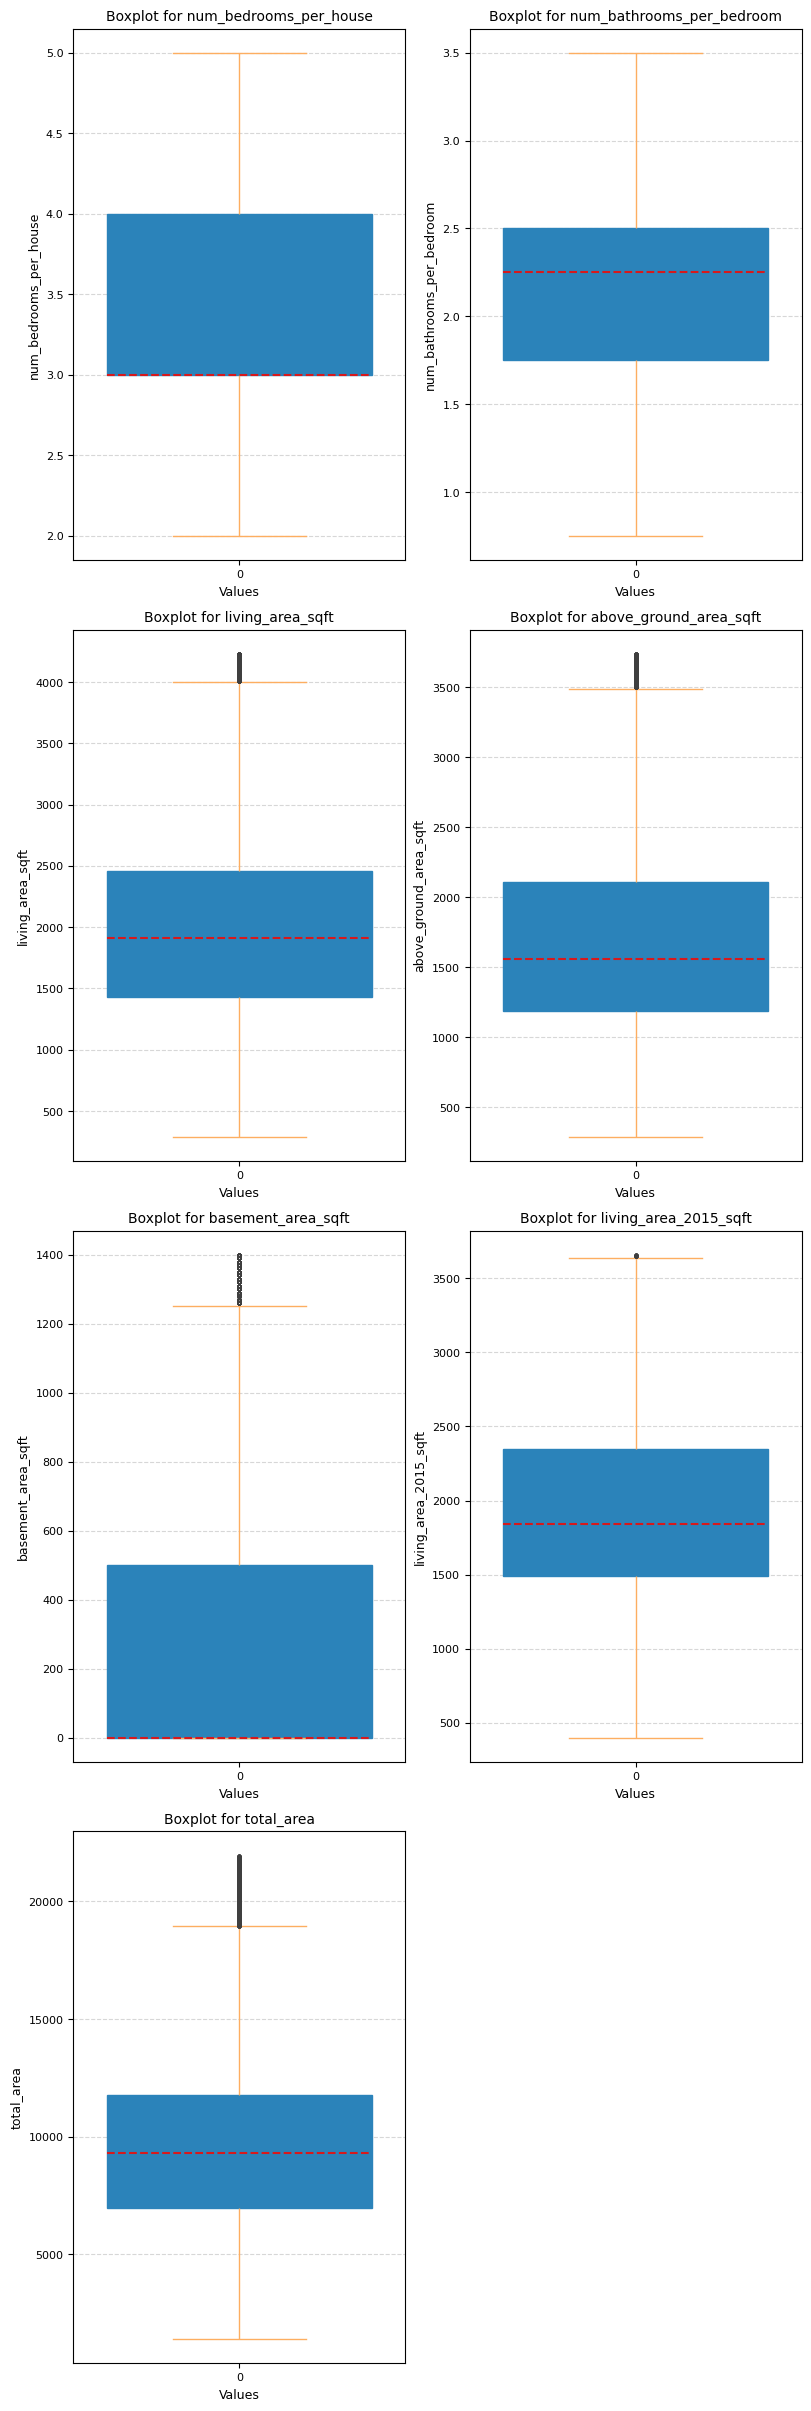

                      Column  Outlier Count  Total Count  Outlier %
6                 total_area         2423.0      21613.0  11.210845
3     above_ground_area_sqft          611.0      21613.0   2.827002
2           living_area_sqft          572.0      21613.0   2.646555
1  num_bathrooms_per_bedroom          569.0      21613.0   2.632675
0     num_bedrooms_per_house          542.0      21613.0   2.507750
5      living_area_2015_sqft          542.0      21613.0   2.507750
4         basement_area_sqft          496.0      21613.0   2.294915
Total Outliers: 5755.0
Total Values: 453873
Overall Outlier %: 1.27%


In [57]:
# Define aesthetics
box_color = '#2b83ba'  # Muted blue
whisker_color = '#fdae61'  # Muted orange
median_color = '#d7191c'  # Muted red dashed
outlier_marker_size = 2  # Small dot for outliers

# Visualize outliers using vertical boxplots, 2 charts per image
rows = (len(numerical_columns) + 1) // 2  # Calculate number of rows for 2 charts per row
fig, axes = plt.subplots(rows, 2, figsize=(8, 6 * rows), constrained_layout=True)
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.boxplot(
        data=innercity_data_missing_treated, y=column, ax=axes[i],
        boxprops=dict(color=box_color),  # Box color
        whiskerprops=dict(color=whisker_color),  # Whisker color
        capprops=dict(color=whisker_color),  # Cap color
        medianprops=dict(color=median_color, linestyle='--', linewidth=1.5),  # Median line
        flierprops=dict(marker='o', markersize=outlier_marker_size, color='black', linestyle='none')  # Small dot outliers
    )
    axes[i].set_title(f'Boxplot for {column}', fontsize=10, color='black')
    axes[i].set_xlabel("Values", fontsize=9, color='black')
    axes[i].set_ylabel(column, fontsize=9, color='black')
    axes[i].tick_params(axis='x', labelsize=8, colors='black')
    axes[i].tick_params(axis='y', labelsize=8, colors='black')
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Ensure non-scientific notation for x-axis
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig(".\\images\\outliers_after_vertical.svg", format="svg", dpi=300)
plt.show()

# Print outlier summary
print(outlier_summary_df.sort_values(by='Outlier %', ascending=False))
print(f"Total Outliers: {outlier_summary_df['Outlier Count'].sum()}")
print(f"Total Values: {innercity_data_missing_treated.shape[0] * innercity_data_missing_treated.shape[1]}")
print(f"Overall Outlier %: {outlier_summary_df['Outlier Count'].sum() / (innercity_data_missing_treated.shape[0] * innercity_data_missing_treated.shape[1]) * 100:.2f}%")

In [58]:
# Check for NaN values in the entire dataset
nan_summary = innercity_data_missing_treated.isnull().sum()

# Print the columns with NaN values
print("Columns with NaN values:")
print(nan_summary[nan_summary > 0])

# Print the total number of NaN values
total_nan = innercity_data_missing_treated.isnull().sum().sum()
print(f"\nTotal number of NaN values: {total_nan}")

Columns with NaN values:
Series([], dtype: int64)

Total number of NaN values: 0


In [59]:
innercity_data_outlier_treated = innercity_data_missing_treated.copy()
innercity_data_outlier_treated.to_csv('.\\data\\output\\innercity_data_outlier_treated.csv')
innercity_data_outlier_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21613 non-null  Int64         
 4   num_bathrooms_per_bedroom  21613 non-null  float64       
 5   living_area_sqft           21613 non-null  float64       
 6   num_floors                 21613 non-null  category      
 7   waterfront_view            21613 non-null  category      
 8   views                      21613 non-null  category      
 9   condition                  21613 non-null  category      
 10  construction_grade         21613 non-null  category      
 11  above_ground_area_sqft     21613 non-null  float64       
 12  base

## Variable transformation (if applicable)
#### Continous Columns
- num_floors Can be treated as a numeric feature unless it's highly categorical.
- month might capture seasonal patterns. Consider encoding as cyclical features (sin and cos transformations).
- living_area_sqft, above_ground_area_sqft, basement_area_sqft, and total_area: Consider log transformation if these variables exhibit skewness, as area variables often do.
### Categorical Columns
- waterfront_view, furnished, These can be encoded as binary or ordinal variables if they hold categorical meaning
- views Can be ordinal if higher views correspond to better appeal.
- condition and construction_grade Ensure these are treated as ordinal variables if the categories have an inherent order

In [60]:
innercity_data_outlier_treated['month_sin'] = np.sin(2 * np.pi * innercity_data_outlier_treated['month'] / 12)
innercity_data_outlier_treated['month_cos'] = np.cos(2 * np.pi * innercity_data_outlier_treated['month'] / 12)

# Display the first few rows to verify
print(innercity_data_outlier_treated[['month', 'month_sin', 'month_cos']].head())
innercity_data_outlier_treated = innercity_data_outlier_treated.drop(columns='month')


   month  month_sin     month_cos
0      4   0.866025 -5.000000e-01
1      3   1.000000  6.123234e-17
2      8  -0.866025 -5.000000e-01
3     10  -0.866025  5.000000e-01
4      2   0.866025  5.000000e-01


In [61]:
# Display transformed columns
transformed_columns = innercity_data_outlier_treated[['waterfront_view', 'furnished', 'views', 'condition', 'construction_grade']]
transformed_columns.head()

waterfront_view furnished views condition construction_grade
0               0         0     0         3                  8
1               0         0     0         4                  6
2               1         0     4         3                  8
3               0         0     0         3                  8
4               0         0     0         3                  7

In [62]:
innercity_data_outlier_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   house_id                   21613 non-null  category      
 1   sale_date                  21613 non-null  datetime64[ns]
 2   price                      21613 non-null  float64       
 3   num_bedrooms_per_house     21613 non-null  Int64         
 4   num_bathrooms_per_bedroom  21613 non-null  float64       
 5   living_area_sqft           21613 non-null  float64       
 6   num_floors                 21613 non-null  category      
 7   waterfront_view            21613 non-null  category      
 8   views                      21613 non-null  category      
 9   condition                  21613 non-null  category      
 10  construction_grade         21613 non-null  category      
 11  above_ground_area_sqft     21613 non-null  float64       
 12  base

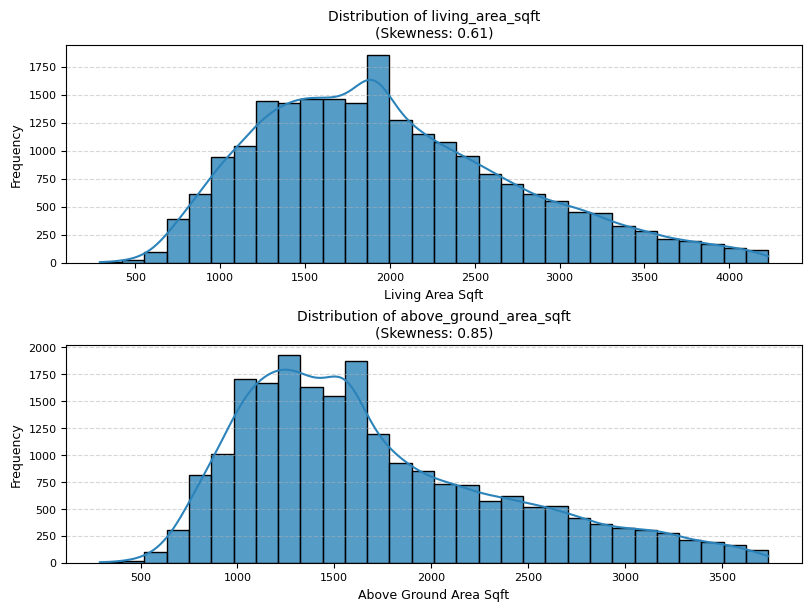

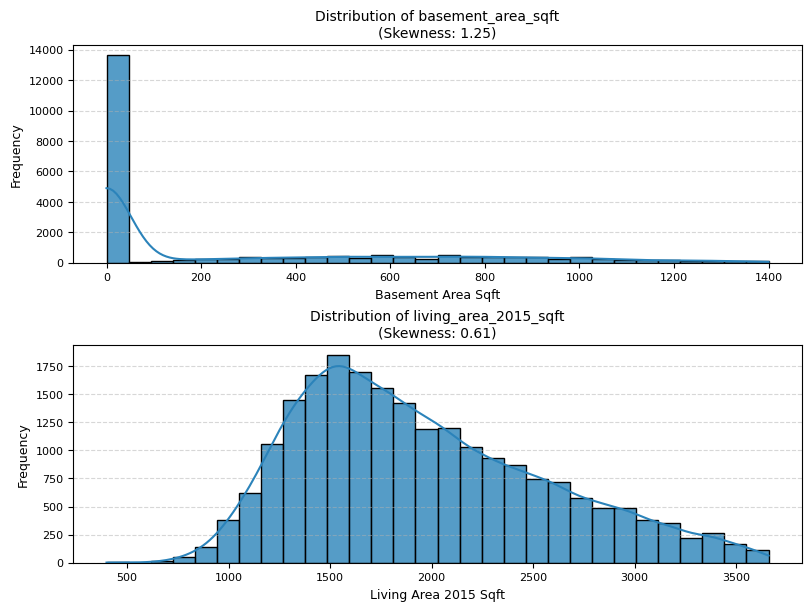

In [63]:
# Step 1: Define the columns to analyze
columns_to_check = ['living_area_sqft', 'above_ground_area_sqft', 
                    'basement_area_sqft', 'living_area_2015_sqft']

# Step 2: Calculate skewness before transformation
skewness_before = innercity_data_outlier_treated[columns_to_check].apply(lambda x: skew(x.dropna()))

# Step 3: Visualize distributions before log transformation
for idx in range(0, len(columns_to_check), 2):  # Loop through columns in pairs
    # Select up to two columns for each image
    current_columns = columns_to_check[idx:idx + 2]
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)  # Two charts per image
    
    for i, column in enumerate(current_columns):
        sns.histplot(
            innercity_data_outlier_treated[column], kde=True, bins=30, ax=axes[i], color='#2b83ba', alpha=0.8
        )
        axes[i].set_title(f'Distribution of {column}\n(Skewness: {skewness_before[column]:.2f})', fontsize=10, color='black')
        axes[i].set_xlabel(column.replace('_', ' ').title(), fontsize=9, color='black')
        axes[i].set_ylabel("Frequency", fontsize=9, color='black')
        axes[i].tick_params(axis='x', labelsize=8, colors='black')
        axes[i].tick_params(axis='y', labelsize=8, colors='black')
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    
    # Save the image
    filename = f".\\images\\skewness_before_{idx // 2 + 1}.svg"
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

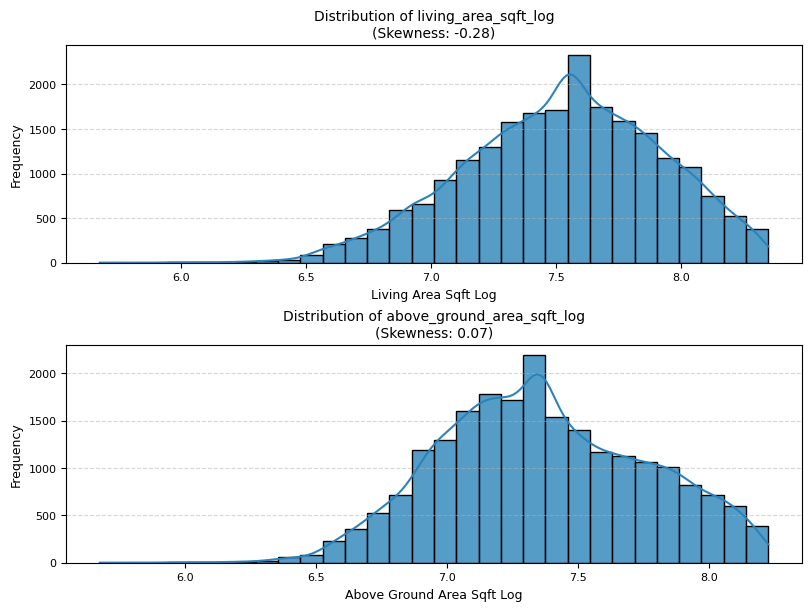

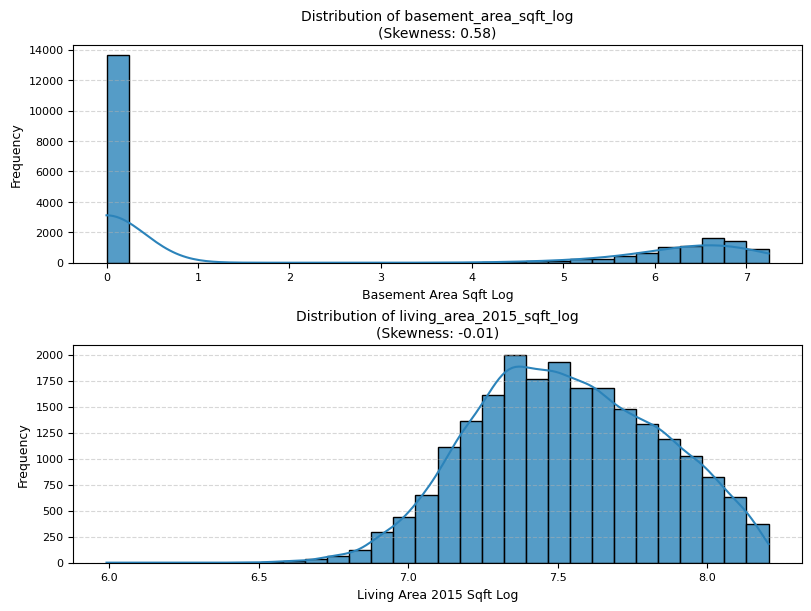

                 Variable  Skewness Before  Skewness After
0        living_area_sqft         0.606347       -0.277311
1  above_ground_area_sqft         0.848644        0.073118
2      basement_area_sqft         1.254775        0.579393
3   living_area_2015_sqft         0.611948       -0.011152


In [64]:
# Step 4: Apply log transformation to reduce skewness
for col in columns_to_check:
    innercity_data_outlier_treated[f'{col}_log'] = innercity_data_outlier_treated[col].apply(
        lambda x: np.log1p(x) if x > 0 else 0  # log1p handles zero values
    )

# Step 5: Calculate skewness after transformation
skewness_after = innercity_data_outlier_treated[[f'{col}_log' for col in columns_to_check]].apply(
    lambda x: skew(x.dropna())
)

# Step 6: Visualize distributions after log transformation
log_columns = [f'{col}_log' for col in columns_to_check]
for idx in range(0, len(log_columns), 2):  # Loop through columns in pairs
    current_columns = log_columns[idx:idx + 2]
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)  # Two charts per image
    
    for i, column in enumerate(current_columns):
        sns.histplot(
            innercity_data_outlier_treated[column], kde=True, bins=30, ax=axes[i], color='#2b83ba', alpha=0.8
        )
        axes[i].set_title(f'Distribution of {column}\n(Skewness: {skewness_after[column]:.2f})', fontsize=10, color='black')
        axes[i].set_xlabel(column.replace('_', ' ').title(), fontsize=9, color='black')
        axes[i].set_ylabel("Frequency", fontsize=9, color='black')
        axes[i].tick_params(axis='x', labelsize=8, colors='black')
        axes[i].tick_params(axis='y', labelsize=8, colors='black')
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)
    
    # Save the image
    filename = f".\\images\\skewness_after_{idx // 2 + 1}.svg"
    plt.savefig(filename, format="svg", dpi=300)
    plt.show()

# Step 7: Display skewness before and after transformation
skewness_comparison = pd.DataFrame({
    'Variable': columns_to_check,
    'Skewness Before': skewness_before.values,
    'Skewness After': skewness_after.values
})

# Step 8: Output the comparison table
print(skewness_comparison)

In [65]:
innercity_data_outlier_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   house_id                    21613 non-null  category      
 1   sale_date                   21613 non-null  datetime64[ns]
 2   price                       21613 non-null  float64       
 3   num_bedrooms_per_house      21613 non-null  Int64         
 4   num_bathrooms_per_bedroom   21613 non-null  float64       
 5   living_area_sqft            21613 non-null  float64       
 6   num_floors                  21613 non-null  category      
 7   waterfront_view             21613 non-null  category      
 8   views                       21613 non-null  category      
 9   condition                   21613 non-null  category      
 10  construction_grade          21613 non-null  category      
 11  above_ground_area_sqft      21613 non-null  float64   

## Addition of new variables (if required)
- year_built and year_renovated Create new features like "house age" (current_year - year_built) and "years since renovation" (current_year - year_renovated). Drop original columns after transformation.
- basement_area_sqft is skewed, with alot of houses having no or small basements, we will create a flag has_basement, we need to create this above  as median is 0 and outlier and missing treatement was done with median.
- **Add City using Zip Code mapping**    
- Drop unwanted columns


In [66]:
innercity_data_outlier_treated['year_built'] = innercity_data_outlier_treated['year_built'].astype('int')
innercity_data_outlier_treated['year_renovated'] = innercity_data_outlier_treated['year_renovated'].astype('int')

# Step 1: Ensure 'sale_date' is in datetime format
innercity_data_outlier_treated['sale_date'] = pd.to_datetime(innercity_data_outlier_treated['sale_date'])

# Step 2: Extract the latest sale year
latest_sale_year = innercity_data_outlier_treated['sale_date'].dt.year.max()

# Step 3: Create the "house age" feature
innercity_data_outlier_treated['house_age'] = latest_sale_year - innercity_data_outlier_treated['year_built']

# Step 4: Create the "years since renovation" feature
# Replace values for houses never renovated (e.g., year_renovated == 0)
innercity_data_outlier_treated['is_renovated'] = innercity_data_outlier_treated['year_renovated'].apply(lambda x: 0 if x == 0 else 1)
innercity_data_outlier_treated['is_renovated']  = innercity_data_outlier_treated['is_renovated'] .astype('category')

# Calculate 'years_since_renovation'
innercity_data_outlier_treated['renovation_age'] = innercity_data_outlier_treated.apply(
    lambda row: row['house_age'] if row['year_renovated'] == 0 else latest_sale_year - row['year_renovated'], axis=1
)
# Step 5: Drop the original columns
#innercity_data_outlier_treated.drop(['year_built', 'year_renovated'], axis=1, inplace=True)

# Step 6: Display the updated DataFrame
innercity_data_outlier_treated.head().T

0                    1  \
house_id                             3876100940           3145600250   
sale_date                   2015-04-27 00:00:00  2015-03-17 00:00:00   
price                                  600000.0             190000.0   
num_bedrooms_per_house                        4                    2   
num_bathrooms_per_bedroom                  1.75                  1.0   
living_area_sqft                         3050.0                670.0   
num_floors                                  1.0                  1.0   
waterfront_view                               0                    0   
views                                         0                    0   
condition                                     3                    4   
construction_grade                            8                    6   
above_ground_area_sqft                   1800.0                670.0   
basement_area_sqft                       1250.0                  0.0   
year_built                                 1966                 1948   
year_renovated                                0                    0   
zipcode                                   98034                98118   
living_area_2015_sqft                    2020.0               1660.0   
furnished                                     0                    0   
total_area                              12490.0               3771.0   
has_basement                                  1                    0   
month_sin                              0.866025                  1.0   
month_cos                                  -0.5                  0.0   
living_area_sqft_log                   8.023225             6.508769   
above_ground_area_sqft_log             7.496097             6.508769   
basement_area_sqft_log                 7.131699                  0.0   
living_area_2015_sqft_log              7.611348             7.415175   
house_age                                    49                   67   
is_renovated                                  0                    0   
renovation_age                               49                   67   

                                              2                    3  \
house_id                             7129303070           7338220280   
sale_date                   2014-08-20 00:00:00  2014-10-10 00:00:00   
price                                  735000.0             257000.0   
num_bedrooms_per_house                        4                    3   
num_bathrooms_per_bedroom                  2.75                  2.5   
living_area_sqft                         3040.0               1740.0   
num_floors                                  2.0                  2.0   
waterfront_view                               1                    0   
views                                         4                    0   
condition                                     3                    3   
construction_grade                            8                    8   
above_ground_area_sqft                   3040.0               1740.0   
basement_area_sqft                          0.0                  0.0   
year_built                                 1966                 2009   
year_renovated                                0                    0   
zipcode                                   98118                98002   
living_area_2015_sqft                    2620.0               2030.0   
furnished                                     0                    0   
total_area                               5455.0               5461.0   
has_basement                                  0                    0   
month_sin                             -0.866025            -0.866025   
month_cos                                  -0.5                  0.5   
living_area_sqft_log                   8.019942             7.462215   
above_ground_area_sqft_log             8.019942             7.462215   
basement_area_sqft_log                      0.0                  0.0   
living_area_2

In [67]:
innercity_data_outlier_treated.set_index(keys=['house_id','sale_date'])
drop_cols = ['living_area_sqft','above_ground_area_sqft','basement_area_sqft','basement_area_sqft','year_built','year_renovated','living_area_2015_sqft','basement_area_sqft_log']
innercity_data_outlier_treated = innercity_data_outlier_treated.drop(columns=drop_cols)
innercity_data_outlier_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   house_id                    21613 non-null  category      
 1   sale_date                   21613 non-null  datetime64[ns]
 2   price                       21613 non-null  float64       
 3   num_bedrooms_per_house      21613 non-null  Int64         
 4   num_bathrooms_per_bedroom   21613 non-null  float64       
 5   num_floors                  21613 non-null  category      
 6   waterfront_view             21613 non-null  category      
 7   views                       21613 non-null  category      
 8   condition                   21613 non-null  category      
 9   construction_grade          21613 non-null  category      
 10  zipcode                     21613 non-null  category      
 11  furnished                   21613 non-null  category  

In [68]:
innercity_data_outlier_treated.to_csv('.\\data\\output\\innercity_data_outlier_treated.csv')
innercity_treated = innercity_data_outlier_treated.copy()

In [69]:
#add city to data using city map
#Source Reference https://simplemaps.com/data/us-zips
zipmap_data = pd.read_csv('.\\data\\input\\zip_map\\king_county_washington.csv')
zipmap_data.head()
innercity_treated.rename(columns={'zipcode': 'zip'}, inplace = True)
innercity_treated.head().T

0                    1  \
house_id                             3876100940           3145600250   
sale_date                   2015-04-27 00:00:00  2015-03-17 00:00:00   
price                                  600000.0             190000.0   
num_bedrooms_per_house                        4                    2   
num_bathrooms_per_bedroom                  1.75                  1.0   
num_floors                                  1.0                  1.0   
waterfront_view                               0                    0   
views                                         0                    0   
condition                                     3                    4   
construction_grade                            8                    6   
zip                                       98034                98118   
furnished                                     0                    0   
total_area                              12490.0               3771.0   
has_basement                                  1                    0   
month_sin                              0.866025                  1.0   
month_cos                                  -0.5                  0.0   
living_area_sqft_log                   8.023225             6.508769   
above_ground_area_sqft_log             7.496097             6.508769   
living_area_2015_sqft_log              7.611348             7.415175   
house_age                                    49                   67   
is_renovated                                  0                    0   
renovation_age                               49                   67   

                                              2                    3  \
house_id                             7129303070           7338220280   
sale_date                   2014-08-20 00:00:00  2014-10-10 00:00:00   
price                                  735000.0             257000.0   
num_bedrooms_per_house                        4                    3   
num_bathrooms_per_bedroom                  2.75                  2.5   
num_floors                                  2.0                  2.0   
waterfront_view                               1                    0   
views                                         4                    0   
condition                                     3                    3   
construction_grade                            8                    8   
zip                                       98118                98002   
furnished                                     0                    0   
total_area                               5455.0               5461.0   
has_basement                                  0                    0   
month_sin                             -0.866025            -0.866025   
month_cos                                  -0.5                  0.5   
living_area_sqft_log                   8.019942             7.462215   
above_ground_area_sqft_log             8.019942             7.462215   
living_area_2015_sqft_log              7.871311             7.616284   
house_age                                    49                    6   
is_renovated                                  0                    0   
renovation_age                               49                    6   

                                              4  
house_id                             7950300670  
sale_date                   2015-02-18 00:00:00  
price                                  450000.0  
num_bedrooms_per_house                        2  
num_bathrooms_per_bedroom                   1.0  
num_floors                                  1.0  
waterfront_view                               0  
views                                         0  
condition                                     3  
construction_grade                            7  
zip                                       98118  
furnished                                     0  
total_area                               5710.0  
has_basement                    

In [70]:
zipmap_data

zip         city
0   98001       Auburn
1   98002       Auburn
2   98003  Federal Way
3   98004     Bellevue
4   98005     Bellevue
..    ...          ...
81  98195      Seattle
82  98198      Seattle
83  98199      Seattle
84  98224       Baring
85  98288    Skykomish

[86 rows x 2 columns]

In [71]:

# Map the city from king_county_data to innercity_data using the zip column
zip_to_city_mapping = zipmap_data.set_index('zip')['city'].to_dict()
innercity_treated['city'] = innercity_treated['zip'].map(zip_to_city_mapping)

In [72]:
# Check if all zipcodes in innercity_data are mapped to a city
missing_zipcodes = innercity_treated[innercity_treated['city'].isnull()]['zip'].unique()
# Print results
if len(missing_zipcodes) == 0:
    print("All zipcodes in innercity_data are mapped to a city.")
else:
    print(f"The following zipcodes in innercity_data could not be mapped to a city:\n{missing_zipcodes}")

All zipcodes in innercity_data are mapped to a city.


C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\3343022851.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


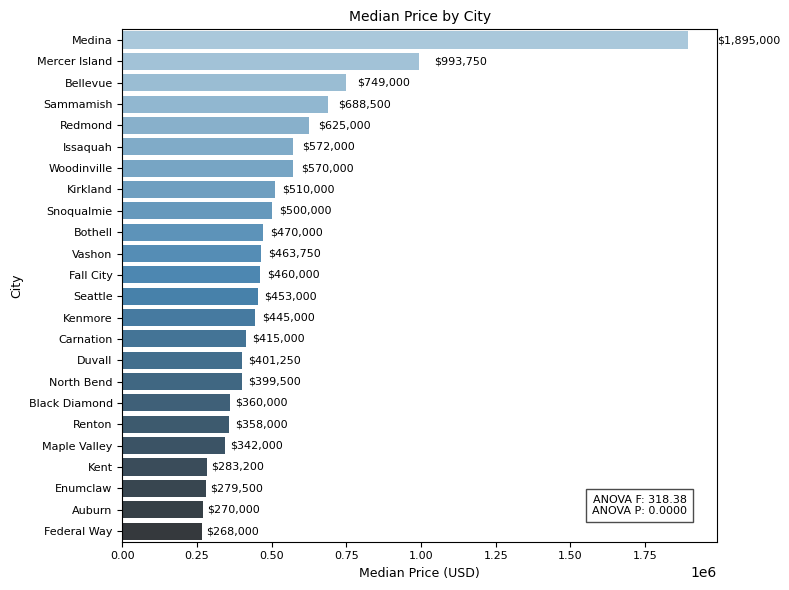

In [73]:
# Group data by city and calculate the median price
median_price_by_city = innercity_treated.groupby('city')['price'].median().sort_values(ascending=False)

# Prepare data for ANOVA test
city_groups = [innercity_treated[innercity_treated['city'] == city]['price'].dropna() for city in median_price_by_city.index]
anova_result = f_oneway(*city_groups)

# ANOVA F-value and p-value
anova_f = anova_result.statistic
anova_p = anova_result.pvalue

# Chart aesthetics
font_title = 10
font_label = 9
font_tick = 8
label_offset = 0.05  # Adjust label placement
box_color = '#2b83ba'  # Muted dark blue for bars
text_color = 'black'

# Create the bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x=median_price_by_city.values, 
    y=median_price_by_city.index, 
    palette='Blues_d'
)

# Annotate bar values with median prices
for i, value in enumerate(median_price_by_city.values):
    ax.text(value + (value * label_offset), i, f"${value:,.0f}", 
            va='center', fontsize=8, color=text_color)

# Title and labels
plt.title("Median Price by City", fontsize=font_title, color=text_color)
plt.xlabel("Median Price (USD)", fontsize=font_label, color=text_color)
plt.ylabel("City", fontsize=font_label, color=text_color)
plt.xticks(fontsize=font_tick, color=text_color)
plt.yticks(fontsize=font_tick, color=text_color)

# Annotate ANOVA F and p values
plt.text(
    0.95, 0.05, f"ANOVA F: {anova_f:.2f}\nANOVA P: {anova_p:.4f}",
    transform=ax.transAxes, ha='right', va='bottom', fontsize=8,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='black')
)

# Save and show the chart
plt.tight_layout()
plt.savefig(".\\images\\median_price_by_city.svg", format="svg", dpi=300)
plt.show()

# Business Insigths from EDA

## Is the data unbalanced? If so, what can be done? Please explain in the context of the business 
### Data unbalance
####  Price Distribution
-Box Plot and Histogram indicate extreme outliers in the higher price ranges. This suggests the presence of high-end properties significantly skewing the data.
- Summary Statistics:
    - Mean Price: $540,182
    - Median Price: $450,000
    - Standard Deviation: $367,362
    - Skewness: 4.02 (indicating a right-skewed distribution)
    - Kurtosis: 34.52 (indicating heavy tails due to extreme values)
- These metrics confirm that the price data is not evenly distributed and is heavily skewed by high-value properties.
- Outliers: Extreme prices may disproportionately affect model training.
- Skewness in Target Variable: The skewness may lead to suboptimal performance for models assuming normality (e.g., linear regression).
#### Categorical Features
- waterfront_view Majority of properties do not have a waterfront view
- furnished Predominantly unfurnished properties
- This imbalance could mean these features may not significantly impact price prediction unless carefully engineered or combined with other variables.
- Features like waterfront_view and furnished may require rebalancing or transformation.
### what can be done
- For Price Distribution:
    - Log Transformation: Apply a log transformation to reduce skewness in price before training.
    - Remove or Cap Outliers: Cap or remove extreme price values using quantiles (e.g., top 1%)
- For Categorical Features:
    -  Feature Engineering: Create new features or interactions (e.g., combine waterfront_view with zipcode).
   - SMOTE or Class Weighting: If used in a classification context, address imbalance using oversampling techniques.
- For Target Variable:
    - Scale Price: Standardize or normalize the price variable for consistency across models.
    - Use Robust Models: Consider tree-based models (e.g., Random Forest, XGBoost) that handle skewed and imbalanced data well.


Original Skewness: 4.021715573048685
Transformed Skewness: 0.4289733115510523


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


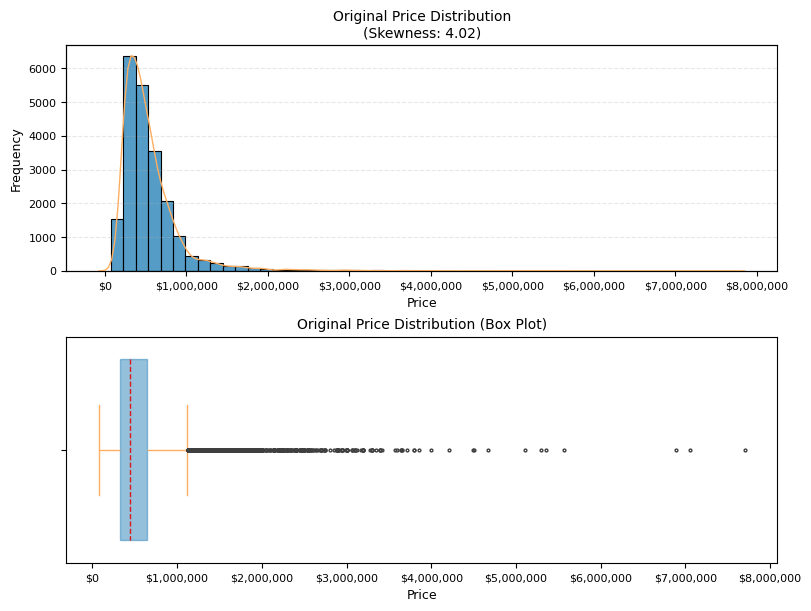

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


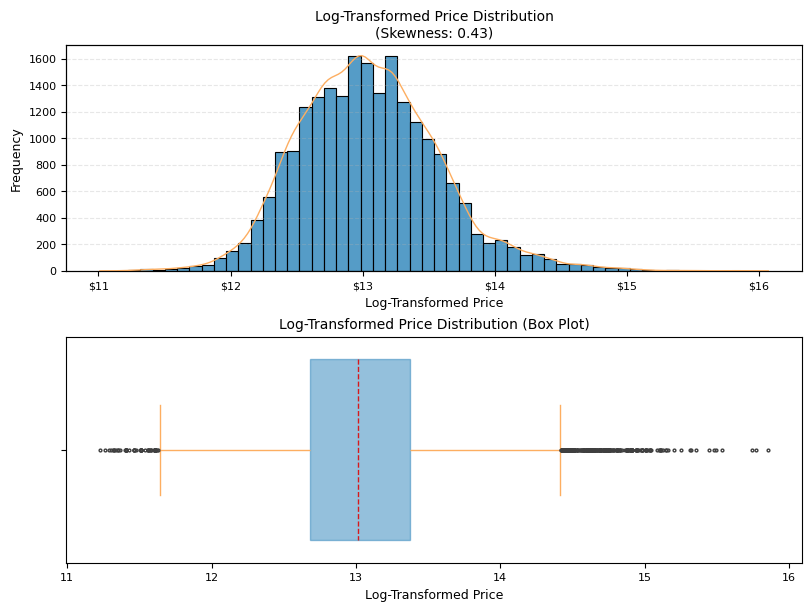

In [74]:
# Create a copy of the dataset
df_new = innercity_treated.copy()

# Step 1: Calculate and Display Skewness
original_skewness = df_new['price'].skew()
print(f"Original Skewness: {original_skewness}")

# Step 2: Apply Log Transformation
df_new['price_log'] = np.log1p(df_new['price'])  # Use log1p to handle zeros (log(1 + x))

# Step 3: Calculate Skewness After Transformation
transformed_skewness = df_new['price_log'].skew()
print(f"Transformed Skewness: {transformed_skewness}")

# Define aesthetics
font_title = 10
font_label = 9
font_tick = 8
color_hist = '#2b83ba'  # Muted blue for histogram
color_kde = '#fdae61'  # Muted orange for KDE line
color_box = '#2b83ba'  # Muted blue for boxplots
color_whiskers = '#fdae61'  # Muted orange for whiskers
color_median = '#d7191c'  # Muted red for median line

# Function to plot histogram with KDE on secondary axis
def plot_histogram_with_kde(ax, data, title, xlabel, ylabel):
    sns.histplot(data, bins=50, color=color_hist, alpha=0.8, ax=ax)  # Histogram
    ax2 = ax.twinx()  # Secondary y-axis for KDE
    sns.kdeplot(data, color=color_kde, linewidth=1, ax=ax2)  # KDE line with linewidth=1
    ax2.get_yaxis().set_visible(False)  # Hide secondary axis
    ax2.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=font_title, color='black')
    ax.set_xlabel(xlabel, fontsize=font_label, color='black')
    ax.set_ylabel(ylabel, fontsize=font_label, color='black')
    ax.tick_params(axis='x', labelsize=font_tick, colors='black')
    ax.tick_params(axis='y', labelsize=font_tick, colors='black')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${int(x):,}"))

# Plot Original Price
fig, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)

# Histogram for Original Price
plot_histogram_with_kde(
    axes[0],
    df_new['price'],
    f"Original Price Distribution\n(Skewness: {original_skewness:.2f})",
    "Price",
    "Frequency"
)

# Box Plot for Original Price
sns.boxplot(
    x=df_new['price'], ax=axes[1],
    boxprops=dict(color=color_box, facecolor=color_box, alpha=0.5, linewidth=1),
    whiskerprops=dict(color=color_whiskers, linewidth=1),
    capprops=dict(color=color_whiskers, linewidth=1),
    medianprops=dict(color=color_median, linestyle='--', linewidth=1),
    flierprops=dict(marker='o', markersize=2, color='black', linestyle='none')  # Outliers as small dots
)
axes[1].set_title("Original Price Distribution (Box Plot)", fontsize=font_title, color='black')
axes[1].set_xlabel("Price", fontsize=font_label, color='black')
axes[1].tick_params(axis='x', labelsize=font_tick, colors='black')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${int(x):,}"))

plt.savefig(".\\images\\original_price_distribution.svg", format="svg", dpi=300)
plt.show()

# Plot Transformed Price
fig, axes = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)

# Histogram for Transformed Price
plot_histogram_with_kde(
    axes[0],
    df_new['price_log'],
    f"Log-Transformed Price Distribution\n(Skewness: {transformed_skewness:.2f})",
    "Log-Transformed Price",
    "Frequency"
)

# Box Plot for Transformed Price
sns.boxplot(
    x=df_new['price_log'], ax=axes[1],
    boxprops=dict(color=color_box, facecolor=color_box, alpha=0.5, linewidth=1),
    whiskerprops=dict(color=color_whiskers, linewidth=1),
    capprops=dict(color=color_whiskers, linewidth=1),
    medianprops=dict(color=color_median, linestyle='--', linewidth=1),
    flierprops=dict(marker='o', markersize=2, color='black', linestyle='none')  # Outliers as small dots
)
axes[1].set_title("Log-Transformed Price Distribution (Box Plot)", fontsize=font_title, color='black')
axes[1].set_xlabel("Log-Transformed Price", fontsize=font_label, color='black')
axes[1].tick_params(axis='x', labelsize=font_tick, colors='black')

plt.savefig(".\\images\\transformed_price_distribution.svg", format="svg", dpi=300)
plt.show()

## Any business insights using clustering (if applicable) 
 Cluster | Price       | Num Bedrooms per House | Num Bathrooms per Bedroom | Total Area | Living Area (log) | House Age | Waterfront View | Condition | Construction Grade |
|---------|-------------|-------------------------|----------------------------|------------|-------------------|-----------|------------------|-----------|---------------------|
| 0       | 525,341.0   | 4.0                     | 2.0                        | 10,523.0   | 8.0               | 61.0      | 0.0              | 4.0       | 7.0                 |
| 1       | 428,520.0   | 3.0                     | 2.0                        | 7,931.0    | 8.0               | 22.0      | 0.0              | 3.0       | 8.0                 |
| 2       | 1,668,301.0 | 3.0                     | 2.0                        | 13,549.0   | 8.0               | 53.0      | 1.0              | 4.0       | 9.0                 |
| 3       | 354,960.0   | 3.0                     | 1.0                        | 8,159.0    | 7.0               | 68.0      | 0.0              | 3.0       | 7.0                 |
| 4       | 938,214.0   | 4.0                     | 3.0                        | 12,954.0   | 8.0               | 27.0      | 0.0              | 3.0       | 9.0                 |

### Cluster	Possible Representation
- 0	Older Luxury Homes: High price, larger houses with 4 bedrooms, older in age, average construction quality, and no waterfront view.
- 1	Modern Affordable Homes: Mid-range price, moderate size, newer homes with better construction grade and average condition.
- 2	Premium Waterfront Properties: Very high price, larger area, waterfront view, high construction grade, catering to luxury buyers.
- 3	Budget-Friendly Older Homes: Low price, smaller area, older homes with lower construction quality and condition.
- 4	Spacious Modern High-End Homes: High price, large area, newer homes with high construction grade, catering to upscale families.

In [75]:
# Check for NaN values in the entire dataset
nan_summary = df_new.isnull().sum()

# Print the columns with NaN values
print("Columns with NaN values:")
print(nan_summary[nan_summary > 0])

# Print the total number of NaN values
total_nan = innercity_treated.isnull().sum().sum()
print(f"\nTotal number of NaN values: {total_nan}")

Columns with NaN values:
Series([], dtype: int64)

Total number of NaN values: 0


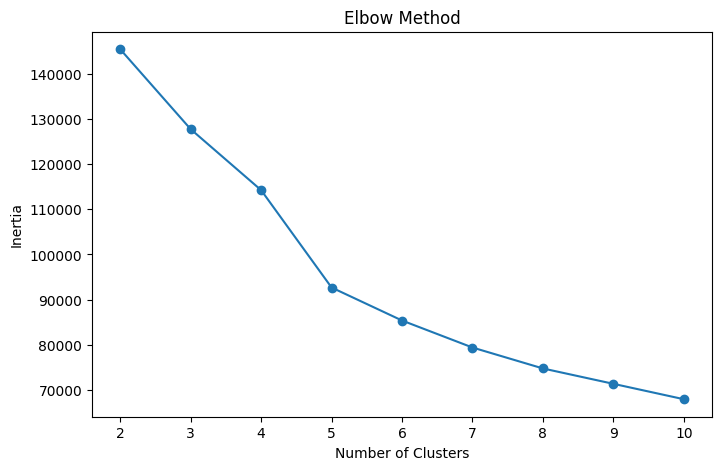

In [76]:
# Select relevant columns for clustering
columns_to_cluster = [
    'price', 'num_bedrooms_per_house', 'num_bathrooms_per_bedroom',
    'total_area', 'living_area_sqft_log', 'house_age',
    'waterfront_view', 'condition', 'construction_grade'
]

data_cluster = df_new[columns_to_cluster]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cluster)

# Elbow Method
inertia = []
range_clusters = range(2, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig(f".\\images\\elbow.svg", format="svg", dpi=1200)
plt.show()

In [77]:
# Choose optimal number of clusters (e.g., 4 based on the elbow curve)
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_new['cluster'] = kmeans.fit_predict(data_scaled)

In [78]:
df_new['waterfront_view'] = df_new['waterfront_view'].astype('int')
df_new['condition'] = df_new['condition'].astype('int')
df_new['construction_grade']= df_new['construction_grade'].astype('int')
df_new.info()


columns_to_cluster_con= [
    'price', 'num_bedrooms_per_house', 'num_bathrooms_per_bedroom',
    'total_area', 'living_area_sqft_log', 'house_age','waterfront_view', 'condition', 'construction_grade'
]

# Group by clusters to get mean values
cluster_analysis_con = df_new.groupby('cluster')[columns_to_cluster_con].mean().round(0)


# Display cluster analysis
cluster_analysis_con

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   house_id                    21613 non-null  category      
 1   sale_date                   21613 non-null  datetime64[ns]
 2   price                       21613 non-null  float64       
 3   num_bedrooms_per_house      21613 non-null  Int64         
 4   num_bathrooms_per_bedroom   21613 non-null  float64       
 5   num_floors                  21613 non-null  category      
 6   waterfront_view             21613 non-null  int64         
 7   views                       21613 non-null  category      
 8   condition                   21613 non-null  int64         
 9   construction_grade          21613 non-null  int64         
 10  zip                         21613 non-null  category      
 11  furnished                   21613 non-null  category  

price  num_bedrooms_per_house  num_bathrooms_per_bedroom  \
cluster                                                                 
0         524612.0                     4.0                        2.0   
1         428389.0                     3.0                        2.0   
2        1668301.0                     3.0                        2.0   
3         355295.0                     3.0                        1.0   
4         936854.0                     4.0                        3.0   

         total_area  living_area_sqft_log  house_age  waterfront_view  \
cluster                                                                 
0           10538.0                   8.0       61.0              0.0   
1            7933.0                   8.0       22.0              0.0   
2           13468.0                   8.0       53.0              1.0   
3            8151.0                   7.0       68.0              0.0   
4           12937.0                   8.0       27.0              0.0   

         condition  construction_grade  
cluster                                 
0              4.0                 7.0  
1              3.0                 8.0  
2              4.0                 9.0  
3              3.0                 7.0  
4              3.0                 9.0

## Any other business insights
- Cluster 0: Affordable Older Family Homes
    - Price Range: Moderate.
    - Features: Larger houses with more bedrooms but moderate construction quality.
    - Target Audience: Families seeking spacious homes at a reasonable price, likely in suburban areas.

- Cluster 1: Budget Compact Homes
    - Price Range: Lowest among clusters.
    - Features: Smaller houses, fewer bedrooms and bathrooms, older construction with basic amenities.
    - Target Audience: Budget-conscious buyers, possibly first-time homeowners or investors for rental properties.

- Cluster 2: Premium Waterfront Properties
    - Price Range: Highest.
    - Features: High-end homes with waterfront views, excellent construction grade, and premium amenities.
    - Target Audience: Luxury buyers seeking exclusivity and high-quality living.

- Cluster 3: Modern Mid-Range Homes
    - Price Range: Slightly above budget homes.
    - Features: Moderately priced newer homes, smaller size but good condition and construction quality.
    - Target Audience: Young families or professionals looking for modern amenities at a reasonable cost.

- Cluster 4: Spacious High-End Family Homes
    - Price Range: Upper mid-range to high-end.
    - Features: Large, newer homes with multiple bedrooms and bathrooms, great construction quality but no waterfront.
    - Target Audience: Upper-middle-class families looking for space, comfort, and a modern lifestyle.


# Preprocessing the Data bases post findings from EDA
1. index data using house_id and sale_date
3. remove column that were transformed zipcode,basement_sqft, price as we have city, has_basement and price_log as replacements
4. Change all the datatypes to the correct ones for modeling.
5. transform total_area to log scale
6. order the attribute in groups that make sense, optional only for better readability.
7. create two dataset one for Linear Regression and the other for Tree and ensemble models
8. split the data into Train and test
9. scale data for linear models and clustering where needed

In [79]:
df_new.to_csv('.\\data\\output\\innercity_treated.csv')
innercity_treated = df_new.copy()

# Convert 'house_id' and 'sale_date' as index
innercity_treated.set_index(['house_id', 'sale_date'], inplace=True)

# Extract 'price' column into a new DataFrame
price_df = innercity_treated[['price']]

# Drop 'price' column from the original DataFrame
innercity_treated = innercity_treated.drop(columns=['price','zip'])

In [80]:
# data type conversions
column_data_types = {
    # Numerical variables (count)
    'num_bedrooms_per_house': 'int32',
    'house_age': 'int32',
    'renovation_age': 'int32',

    # Numerical variables (continuous)
    'num_bathrooms_per_bedroom': 'float32',
    'total_area': 'float32',
    'month_sin': 'float32',
    'month_cos': 'float32',
    'living_area_sqft_log': 'float32',
    'above_ground_area_sqft_log': 'float32',
    'living_area_2015_sqft_log': 'float32',
    'price_log': 'float32',

    # Categorical variables
    'num_floors': 'category',
    'waterfront_view': 'category',
    'views': 'category',
    'condition': 'category',
    'construction_grade': 'category',
    'furnished': 'category',
    'has_basement': 'category',
    'is_renovated': 'category',
    'city': 'category',
    'cluster': 'category'
}
# Apply the data type conversions
for col, dtype in column_data_types.items():
    innercity_treated[col] = innercity_treated[col].astype(dtype)

# Verify the updated data types
print(innercity_treated.dtypes)

num_bedrooms_per_house           int32
num_bathrooms_per_bedroom      float32
num_floors                    category
waterfront_view               category
views                         category
condition                     category
construction_grade            category
furnished                     category
total_area                     float32
has_basement                  category
month_sin                      float32
month_cos                      float32
living_area_sqft_log           float32
above_ground_area_sqft_log     float32
living_area_2015_sqft_log      float32
house_age                        int32
is_renovated                  category
renovation_age                   int32
city                          category
price_log                      float32
cluster                       category
dtype: object


In [81]:
# Ordinal categorical variables
ordinal_vars = {
    'condition': [1, 2, 3, 4, 5],  # Poor to Excellent
    'construction_grade': list(range(1, 14)),  # 1 to 13 (Least to Best Grade)
    'views': [0,1, 2, 3, 4],  # Number of views
    'num_floors': [1, 1.5, 2, 2.5, 3, 3.5]  # Possible number of floors
}
for col, order in ordinal_vars.items():
    innercity_treated[col] = pd.Categorical(
        innercity_treated[col], categories=order, ordered=True
    )

In [82]:
unique_cities = innercity_treated['city'].nunique()
print(f"Number of unique cities: {unique_cities}")

Number of unique cities: 24


In [83]:
from sklearn.preprocessing import OneHotEncoder
# One-hot encode 'cluster' and 'city' variables
one_hot_cluster = pd.get_dummies(innercity_treated['cluster'], prefix='cluster', drop_first=True).astype('int32')
one_hot_city = pd.get_dummies(innercity_treated['city'], prefix='city', drop_first=True).astype('int32')


# Concatenate the one-hot encoded columns back to the dataset
innercity_treated = pd.concat([innercity_treated, one_hot_cluster, one_hot_city], axis=1)


# Save the updated dataset
innercity_treated.to_csv("./data/output/innercity_treated_city_onehot.csv", index=False)

In [84]:
# Log-transform the 'total_area' column
innercity_treated['total_area_log'] = np.log1p(innercity_treated['total_area'])

# Drop the original 'total_area' column
innercity_treated.drop(columns=['total_area'], inplace=True)

# Display the updated DataFrame
print("Log transformation applied to 'total_area', and the original column has been dropped.")
innercity_treated.head()

# Save the updated dataset
innercity_treated.to_csv("./data/output/innercity_model_data_transformed.csv", index=False)

Log transformation applied to 'total_area', and the original column has been dropped.


In [85]:
# Verify the updated data types
print(innercity_treated.dtypes)

num_bedrooms_per_house           int32
num_bathrooms_per_bedroom      float32
num_floors                    category
waterfront_view               category
views                         category
condition                     category
construction_grade            category
furnished                     category
has_basement                  category
month_sin                      float32
month_cos                      float32
living_area_sqft_log           float32
above_ground_area_sqft_log     float32
living_area_2015_sqft_log      float32
house_age                        int32
is_renovated                  category
renovation_age                   int32
city                          category
price_log                      float32
cluster                       category
cluster_1                        int32
cluster_2                        int32
cluster_3                        int32
cluster_4                        int32
city_Bellevue                    int32
city_Black Diamond       

In [86]:
# Define the new column order
new_column_order = [
    # Target Variable
    'price_log',
    
    # House Characteristics
    'num_bedrooms_per_house', 'num_bathrooms_per_bedroom', 'num_floors',
    'living_area_sqft_log', 'above_ground_area_sqft_log', 
    'living_area_2015_sqft_log', 'total_area_log',
    
    # House Age and Renovation
    'house_age', 'is_renovated', 'renovation_age',
    
    # House Quality
    'condition', 'construction_grade',
    
    # Amenities and Features
    'waterfront_view', 'views', 'furnished', 'has_basement',
    
    # Temporal Features
    'month_sin', 'month_cos',
    
    # Cluster
    'cluster','cluster_1','cluster_2','cluster_3','cluster_4',
    
    # City One-Hot Encoded Variables
    'city',
    'city_Bellevue', 'city_Black Diamond', 'city_Bothell', 'city_Carnation',
    'city_Duvall', 'city_Enumclaw', 'city_Fall City', 'city_Federal Way',
    'city_Issaquah', 'city_Kenmore', 'city_Kent', 'city_Kirkland',
    'city_Maple Valley', 'city_Medina', 'city_Mercer Island', 
    'city_North Bend', 'city_Redmond', 'city_Renton', 'city_Sammamish',
    'city_Seattle', 'city_Snoqualmie', 'city_Vashon', 'city_Woodinville'
]

# Reorder the columns
innercity_treated = innercity_treated[new_column_order]

# Save the reorganized dataset
innercity_treated.to_csv("./data/output/innercity_treated_reorganized.csv", index=False)

In [87]:
# create two data sets for Linear and Tree Models
tree_model_data =  innercity_treated.drop(columns=['cluster_1','cluster_2','cluster_3','cluster_4','city_Bellevue', 'city_Black Diamond', 'city_Bothell', 'city_Carnation',
    'city_Duvall', 'city_Enumclaw', 'city_Fall City', 'city_Federal Way',
    'city_Issaquah', 'city_Kenmore', 'city_Kent', 'city_Kirkland',
    'city_Maple Valley', 'city_Medina', 'city_Mercer Island', 
    'city_North Bend', 'city_Redmond', 'city_Renton', 'city_Sammamish',
    'city_Seattle', 'city_Snoqualmie', 'city_Vashon', 'city_Woodinville']).copy()

linear_model_data = innercity_treated.drop(columns=['cluster','city']).copy()

tree_model_data.info()


# change the dtypes for linear models data
dtypes_map = {
    'num_floors' : 'float32',
    'is_renovated' : 'int32',
    'condition' : 'int32',
    'construction_grade' : 'int32',
    'waterfront_view': 'int32',
    'views': 'int32',
    'furnished': 'int32',
    'has_basement': 'int32'
}

# Loop through the dtypes_map and change the data types
for column, dtype in dtypes_map.items():
    if column in linear_model_data.columns:
        linear_model_data[column] = linear_model_data[column].astype(dtype)

linear_model_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21613 entries, (np.int64(3876100940), Timestamp('2015-04-27 00:00:00')) to (np.int64(8805900430), Timestamp('2014-12-29 00:00:00'))
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   price_log                   21613 non-null  float32 
 1   num_bedrooms_per_house      21613 non-null  int32   
 2   num_bathrooms_per_bedroom   21613 non-null  float32 
 3   num_floors                  21613 non-null  category
 4   living_area_sqft_log        21613 non-null  float32 
 5   above_ground_area_sqft_log  21613 non-null  float32 
 6   living_area_2015_sqft_log   21613 non-null  float32 
 7   total_area_log              21613 non-null  float32 
 8   house_age                   21613 non-null  int32   
 9   is_renovated                21613 non-null  category
 10  renovation_age              21613 non-null  int32   
 11  condition                 

In [88]:
tree_model_data.to_csv('.\\data\\output\\tree_model_data.csv')
linear_model_data.to_csv('.\\data\\output\\linear_model_data.csv')

In [89]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X_tree = tree_model_data.drop(columns=["price_log"])
y_tree = tree_model_data["price_log"]

X_linear = linear_model_data.drop(columns=["price_log"])
y_linear = linear_model_data["price_log"]

# Train-test split for tree-based models
X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(
    X_tree, y_tree, test_size=0.2, random_state=42
)

# Train-test split for linear models
X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42
)

print(X_tree_train.shape)
print(y_tree_train.shape)
print(X_tree_test.shape)
print(y_tree_test.shape)

print(X_linear_train.shape)
print(y_linear_train.shape)
print(X_linear_test.shape)
print(y_linear_test.shape)


(17290, 20)
(17290,)
(4323, 20)
(4323,)
(17290, 45)
(17290,)
(4323, 45)
(4323,)


In [90]:
from sklearn.preprocessing import StandardScaler
# Scale the Linear models and clustering data.
X_linear_train.info()
columns_to_scale = ['num_bedrooms_per_house','num_bathrooms_per_bedroom', 'num_floors', 'living_area_sqft_log','above_ground_area_sqft_log','living_area_2015_sqft_log','total_area_log'
                    ,'house_age','renovation_age','condition','construction_grade','views']
scaler = StandardScaler()

X_linear_train_scaled = X_linear_train.copy()
X_linear_train_scaled[columns_to_scale] = scaler.fit_transform(X_linear_train_scaled[columns_to_scale])

X_linear_test_scaled = X_linear_test.copy()
X_linear_test_scaled[columns_to_scale] = scaler.transform(X_linear_test[columns_to_scale])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17290 entries, (np.int64(3582200200), Timestamp('2015-04-27 00:00:00')) to (np.int64(9201000100), Timestamp('2015-04-14 00:00:00'))
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   num_bedrooms_per_house      17290 non-null  int32  
 1   num_bathrooms_per_bedroom   17290 non-null  float32
 2   num_floors                  17290 non-null  float32
 3   living_area_sqft_log        17290 non-null  float32
 4   above_ground_area_sqft_log  17290 non-null  float32
 5   living_area_2015_sqft_log   17290 non-null  float32
 6   total_area_log              17290 non-null  float32
 7   house_age                   17290 non-null  int32  
 8   is_renovated                17290 non-null  int32  
 9   renovation_age              17290 non-null  int32  
 10  condition                   17290 non-null  int32  
 11  construction_grade          17290 non-n

In [91]:
X_linear_train_scaled = X_linear_train_scaled.reset_index()
X_linear_train_house_id = X_linear_train_scaled[['house_id','sale_date']].copy()
X_linear_train_scaled.drop(columns=['house_id','sale_date'], inplace=True)

X_linear_test_scaled = X_linear_test_scaled.reset_index()
X_linear_test_house_id = X_linear_test_scaled[['house_id','sale_date']].copy()
X_linear_test_scaled.drop(columns=['house_id','sale_date'], inplace=True)

y_linear_train = y_linear_train.reset_index()
y_linear_train_house_id = y_linear_train[['house_id','sale_date']].copy()
y_linear_train.drop(columns=['house_id','sale_date'], inplace=True)

y_linear_test = y_linear_test.reset_index()
y_linear_test_house_id = y_linear_test[['house_id','sale_date']].copy()
y_linear_test.drop(columns=['house_id','sale_date'], inplace=True)

In [92]:
X_linear_train_scaled.to_csv('.\\data\\output\\X_linear_train_scaled.csv',index=False)
y_linear_train.to_csv('.\\data\\output\\y_linear_train.csv',index=False)
X_linear_test_scaled.to_csv('.\\data\\output\\X_linear_test_scaled.csv',index=False)
y_linear_test.to_csv('.\\data\\output\\y_linear_test.csv',index=False)

X_tree_train.to_csv('.\\data\\output\\X_tree_train.csv')
y_tree_train.to_csv('.\\data\\output\\y_tree_train.csv')
X_tree_test.to_csv('.\\data\\output\\X_tree_test.csv')
y_tree_test.to_csv('.\\data\\output\\y_tree_test.csv')

# Model Building and Testing

In [93]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np

C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [94]:
# Define a DataFrame to store results
results_df = pd.DataFrame(columns=["Model", "RMSE_Train", "RMSE_Test", "MAPE_Train", "MAPE_Test"])

In [95]:
# Define a function to evaluate and record model performance
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Train model
    model.fit(X_train, y_train)
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Metrics
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
    # Append to results
    results_df.loc[len(results_df)] = [name, rmse_train, rmse_test, mape_train, mape_test]

In [96]:
# Results DataFrame Initialization
results = pd.DataFrame(columns=['Model', 'RMSE_Train', 'RMSE_Test', 'MAPE_Train', 'MAPE_Test', 'R2_Train', 'R2_Test'])

# List of models and their parameters
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=42)),
    ('Lasso Regression', Lasso(random_state=42)),
    ('ElasticNet', ElasticNet(random_state=42)),
    ('Bayesian Ridge', BayesianRidge()),
    ('Huber Regressor', HuberRegressor(max_iter=500)),
    ('KNN Regressor', KNeighborsRegressor(n_neighbors=5)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    # Adding Tree-based Models
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Extra Trees Regressor', ExtraTreesRegressor(random_state=42)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42)),
    ('XGBoost Regressor', XGBRegressor(random_state=42, objective='reg:squarederror', verbosity=0)),
    ('LightGBM Regressor', LGBMRegressor(random_state=42)),
    ('Histogram-Based Gradient Boosting Regressor', HistGradientBoostingRegressor(random_state=42))
]

# Train and evaluate each model
for model_name, model in models:
    print(f"Training {model_name}...")
    # Fit the model
    model.fit(X_linear_train_scaled, y_linear_train)
    
    # Predict on train and test sets
    y_train_pred = model.predict(X_linear_train_scaled)
    y_test_pred = model.predict(X_linear_test_scaled)
    
    # Calculate metrics
    rmse_train = np.sqrt(mean_squared_error(y_linear_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_linear_test, y_test_pred))
    mape_train = mean_absolute_percentage_error(y_linear_train, y_train_pred)
    mape_test = mean_absolute_percentage_error(y_linear_test, y_test_pred)
    r2_train = r2_score(y_linear_train, y_train_pred)
    r2_test = r2_score(y_linear_test, y_test_pred)
    
    # Append metrics to results DataFrame using pd.concat
    results = pd.concat([results, pd.DataFrame({
        'Model': [model_name],
        'RMSE_Train': [rmse_train],
        'RMSE_Test': [rmse_test],
        'MAPE_Train': [mape_train],
        'MAPE_Test': [mape_test],
        'R2_Train': [r2_train],
        'R2_Test': [r2_test]
    })], ignore_index=True)

# Display results
results.sort_values(by='RMSE_Test', inplace=True)
results.reset_index(drop=True, inplace=True)

# Save results to CSV
results.to_csv("./data/output/linear_and_tree_models_results.csv", index=False)

# Display the final DataFrame
results

C:\Users\kurtg\AppData\Local\Temp\ipykernel_14648\2237831325.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training Bayesian Ridge...


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Huber Regressor...


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training KNN Regressor...
Training Random Forest Regressor...


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Decision Tree Regressor...
Training Extra Trees Regressor...


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Gradient Boosting Regressor...


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Training XGBoost Regressor...
Training LightGBM Regressor...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 17290, number of used features: 45
[LightGBM] [Info] Start training from score 13.051699
Training Histogram-Based Gradient Boosting Regressor...


C:\Users\kurtg\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model  RMSE_Train  RMSE_Test  \
0                            LightGBM Regressor    0.200366   0.213218   
1   Histogram-Based Gradient Boosting Regressor    0.201982   0.213901   
2                         Extra Trees Regressor    0.000568   0.215306   
3                             XGBoost Regressor    0.183966   0.218344   
4                       Random Forest Regressor    0.088388   0.223920   
5                   Gradient Boosting Regressor    0.239560   0.237038   
6                              Ridge Regression    0.248118   0.242957   
7                                Bayesian Ridge    0.248103   0.242961   
8                             Linear Regression    0.248098   0.242974   
9                               Huber Regressor    0.249536   0.243653   
10                                KNN Regressor    0.221734   0.264491   
11                      Decision Tree Regressor    0.000568   0.312990   
12                             Lasso Regression    0.529061   0.517771   
13                                   ElasticNet    0.529061   0.517771   

      MAPE_Train  MAPE_Test  R2_Train   R2_Test  
0   1.151393e-02   0.012126  0.856572  0.830192  
1   1.160267e-02   0.012171  0.854248  0.829102  
2   6.541660e-07   0.011909  0.999999  0.826849  
3   1.019713e-02   0.012360  0.879090  0.821928  
4   4.894223e-03   0.012524  0.972089  0.812717  
5   1.399899e-02   0.013786  0.794971  0.790132  
6   1.439954e-02   0.014176  0.780061  0.779520  
7   1.439713e-02   0.014177  0.780087  0.779512  
8   1.439557e-02   0.014179  0.780096  0.779487  
9   1.426539e-02   0.014024  0.777538  0.778254  
10  1.257684e-02   0.015139  0.824347  0.738704  
11  6.541660e-07   0.017628  0.999999  0.634091  
12  3.173957e-02   0.031433  0.000000 -0.001355  
13  3.173957e-02   0.031433  0.000000 -0.001355

In [97]:
from sklearn.model_selection import GridSearchCV

## Run this on Google Colab
### Results 1st Hyper Parameter tuning run Gridsearch
| Model                                              | Best Params                              | RMSE_Train | RMSE_Test | MAPE_Train | MAPE_Test | R2_Train | R2_Test |
|----------------------------------------------------|------------------------------------------|------------|-----------|------------|-----------|----------|---------|
| LightGBM Regressor 1st Tuning                      | {'learning_rate': 0.1, 'n_estimators': 300} | 0.170525   | 0.210543  | 0.009683   | 0.011871  | 0.896112 | 0.834425 |
| Histogram-Based Gradient Boosting Regressor 1st... | {'learning_rate': 0.1, 'max_iter': 200}    | 0.184108   | 0.211753  | 0.010498   | 0.012004  | 0.878903 | 0.832518 |
### Results 2nd Hyper Parameter tuning run Random Search
| Model                                       | Best Params                                                                                   | RMSE_Train | RMSE_Test | MAPE_Train | MAPE_Test | R2_Train | R2_Test |
|---------------------------------------------|----------------------------------------------------------------------------------------------|------------|-----------|------------|-----------|----------|---------|
| LightGBM Regressor 2nd Tuning               | {'num_leaves': 31, 'n_estimators': 400, 'max_depth': -1, 'learning_rate': 0.05}              | 0.182296   | 0.210237  | 0.010413   | 0.011907  | 0.881275 | 0.834907 |
| Histogram-Based Gradient Boosting Regressor 2nd Tuning | {'max_iter': 400, 'max_depth': 10, 'learning_rate': 0.05, 'l2_regularization': 1.0} | 0.188119   | 0.210465  | 0.010741   | 0.011899  | 0.873569 | 0.834548 |
### Results 3rd Hyper Parameter tuning run Random Search Specific Ranges
| Model                                          | Best Params                                                                                                           | RMSE_Train | RMSE_Test | MAPE_Train | MAPE_Test | R2_Train | R2_Test |
|------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------|------------|-----------|------------|-----------|----------|---------|
| LightGBM Regressor Random Search               | {'learning_rate': 0.054154987361867815, 'max_depth': -1, 'n_estimators': 446, 'num_leaves': 41}                        | 0.1682     | 0.2077    | 0.0095     | 0.0116    | 0.8990   | 0.8389  |
| Histogram-Based Gradient Boosting Regressor Random Search | {'l2_regularization': 0.6154698647431895, 'learning_rate': 0.11477017434965217, 'max_depth': 21, 'max_iter': 469}      | 0.1921     | 0.2129    | 0.0110     | 0.0121    | 0.8682   | 0.8307  |



In [98]:
# import os
# import pandas as pd
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
# from lightgbm import LGBMRegressor
# from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# from sklearn.ensemble import HistGradientBoostingRegressor
# from xgboost import XGBRegressor
# import numpy as np

# # Set environment variables
# os.environ['JOBLIB_MULTIPROCESSING'] = '1'
# os.environ['JOBLIB_PROCESS_TIMEOUT'] = '1200'  # 10 minutes

# # Define hyperparameter grids for selected models
# param_grids = {
#     'LightGBM Regressor': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
#     'Histogram-Based Gradient Boosting Regressor': {'learning_rate': [0.01, 0.1, 0.2], 'max_iter': [100, 200, 300]},
#     #'XGBoost Regressor': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]}
# }

# # Initialize selected models
# models = [
#     ('LightGBM Regressor', LGBMRegressor(random_state=42, force_row_wise=True)),
#     ('Histogram-Based Gradient Boosting Regressor', HistGradientBoostingRegressor(random_state=42)),
#     # ('XGBoost Regressor', XGBRegressor(random_state=42, objective='reg:squarederror', verbosity=0))
# ]

# # Results DataFrame Initialization
# tuning_results = pd.DataFrame(columns=['Model', 'Best Params', 'RMSE_Train', 'RMSE_Test', 
#                                        'MAPE_Train', 'MAPE_Test', 'R2_Train', 'R2_Test'])

# # Train and evaluate each model
# for model_name, model in models:
#     print(f"Tuning {model_name}...")
    
#     if model_name in param_grids:  # Only tune models with hyperparameters
#         grid_search = GridSearchCV(
#             estimator=model,
#             param_grid=param_grids[model_name],
#             scoring='neg_mean_squared_error',  # Use negative RMSE for scoring
#             cv=5,
#             n_jobs=2 if model_name in ['Random Forest Regressor', 'XGBoost Regressor'] else -1,
#             verbose=1
#         )
#         grid_search.fit(X_linear_train_scaled, y_linear_train)

#         # Use the best estimator from GridSearchCV
#         best_model = grid_search.best_estimator_
#         best_params = grid_search.best_params_
#     else:
#         # Use default parameters for models without hyperparameters
#         best_model = model
#         best_model.fit(X_linear_train_scaled, y_linear_train)
#         best_params = "Default"

#     # Predict on train and test sets
#     y_train_pred = best_model.predict(X_linear_train_scaled)
#     y_test_pred = best_model.predict(X_linear_test_scaled)

#     # Calculate metrics
#     rmse_train = np.sqrt(mean_squared_error(y_tree_train, y_train_pred))
#     rmse_test = np.sqrt(mean_squared_error(y_tree_test, y_test_pred))
#     mape_train = mean_absolute_percentage_error(y_tree_train, y_train_pred)
#     mape_test = mean_absolute_percentage_error(y_tree_test, y_test_pred)
#     r2_train = r2_score(y_tree_train, y_train_pred)
#     r2_test = r2_score(y_tree_test, y_test_pred)

#     # Append metrics and best parameters to tuning_results DataFrame
#     tuning_results = pd.concat([tuning_results, pd.DataFrame({
#         'Model': [f"{model_name} 1st Tuning"],
#         'Best Params': [best_params],
#         'RMSE_Train': [rmse_train],
#         'RMSE_Test': [rmse_test],
#         'MAPE_Train': [mape_train],
#         'MAPE_Test': [mape_test],
#         'R2_Train': [r2_train],
#         'R2_Test': [r2_test]
#     })], ignore_index=True)

# # Sort and reset index for results by RMSE_Test
# tuning_results.sort_values(by='RMSE_Test', inplace=True)
# tuning_results.reset_index(drop=True, inplace=True)

# # Save results to CSV
# tuning_results.to_csv("./data/output/tree_models_hyperparameter_tuning_results_1st_tuning.csv", index=False)

# # Display results
# print("Hyperparameter Tuning and Model Performance Results (Sorted by RMSE_Test):")
# tuning_results

In [99]:
# import os
# import pandas as pd
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
# from lightgbm import LGBMRegressor
# from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# from sklearn.ensemble import HistGradientBoostingRegressor
# import numpy as np

# os.environ['JOBLIB_MULTIPROCESSING'] = '1'
# os.environ['JOBLIB_PROCESS_TIMEOUT'] = '1200'  # 10 minutes

# # Define hyperparameter distributions for RandomizedSearchCV
# param_distributions = {
#     'LightGBM Regressor': {
#         'n_estimators': [100, 200, 300, 400, 500],
#         'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#         'num_leaves': [31, 50, 100, 150],
#         'max_depth': [-1, 10, 20, 30]
#     },
#     'Histogram-Based Gradient Boosting Regressor': {
#         'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
#         'max_iter': [100, 200, 300, 400, 500],
#         'max_depth': [None, 10, 20, 30],
#         'l2_regularization': [0.0, 0.1, 1.0, 10.0]
#     }
# }

# # Initialize selected models
# models = [
#     ('LightGBM Regressor', LGBMRegressor(random_state=42, force_row_wise=True)),
#     ('Histogram-Based Gradient Boosting Regressor', HistGradientBoostingRegressor(random_state=42))
# ]

# # Results DataFrame Initialization
# tuning_results = pd.DataFrame(columns=['Model', 'Best Params', 'RMSE_Train', 'RMSE_Test', 
#                                        'MAPE_Train', 'MAPE_Test', 'R2_Train', 'R2_Test'])

# # Train and evaluate each model
# for model_name, model in models:
#     print(f"Tuning {model_name}...")
    
#     if model_name in param_distributions:  # Only tune models with hyperparameters
#         random_search = RandomizedSearchCV(
#             estimator=model,
#             param_distributions=param_distributions[model_name],
#             scoring='neg_mean_squared_error',  # Use negative RMSE for scoring
#             cv=5,
#             n_iter=50,  # Number of random samples
#             n_jobs=-1,
#             verbose=1,
#             random_state=42
#         )
#         # Fit RandomizedSearchCV
#         random_search.fit(X_linear_train_scaled, y_linear_train)

#         # Use the best estimator from RandomizedSearchCV
#         best_model = random_search.best_estimator_
#         best_params = random_search.best_params_
#     else:
#         # Use default parameters for models without hyperparameters
#         best_model = model
#         best_model.fit(X_linear_train_scaled, y_linear_train)
#         best_params = "Default"

#     # Predict on train and test sets
#     y_train_pred = best_model.predict(X_linear_train_scaled)
#     y_test_pred = best_model.predict(X_linear_test_scaled)

#     # Calculate metrics
#     rmse_train = np.sqrt(mean_squared_error(y_linear_train, y_train_pred))
#     rmse_test = np.sqrt(mean_squared_error(y_linear_train, y_test_pred))
#     mape_train = mean_absolute_percentage_error(y_linear_train, y_train_pred)
#     mape_test = mean_absolute_percentage_error(y_linear_train, y_test_pred)
#     r2_train = r2_score(y_linear_train, y_train_pred)
#     r2_test = r2_score(y_linear_train, y_test_pred)

#     # Append metrics and best parameters to tuning_results DataFrame
#     tuning_results = pd.concat([tuning_results, pd.DataFrame({
#         'Model': [f"{model_name} 2nd Tuning"],
#         'Best Params': [best_params],
#         'RMSE_Train': [rmse_train],
#         'RMSE_Test': [rmse_test],
#         'MAPE_Train': [mape_train],
#         'MAPE_Test': [mape_test],
#         'R2_Train': [r2_train],
#         'R2_Test': [r2_test]
#     })], ignore_index=True)

# # Sort and reset index for results by RMSE_Test
# tuning_results.sort_values(by='RMSE_Test', inplace=True)
# tuning_results.reset_index(drop=True, inplace=True)

# # Save results to CSV
# tuning_results.to_csv("./data/output/tree_models_hyperparameter_tuning_results_2nd_tuning.csv", index=False)

# # Display results
# print("Hyperparameter Tuning and Model Performance Results (Sorted by RMSE_Test):")
# tuning_results

In [100]:
# import os
# import pandas as pd
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
# from lightgbm import LGBMRegressor
# from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# from sklearn.ensemble import HistGradientBoostingRegressor
# import numpy as np
# from scipy.stats import uniform, randint

# # Set environment variables to handle multiprocessing and timeout
# os.environ['JOBLIB_MULTIPROCESSING'] = '1'
# os.environ['JOBLIB_PROCESS_TIMEOUT'] = '600'  # 10 minutes

# # Define hyperparameter grids for RandomizedSearchCV
# param_grids = {
#     'LightGBM Regressor': {
#         'n_estimators': randint(300, 500),
#         'learning_rate': uniform(0.03, 0.07),
#         'num_leaves': randint(40, 60),
#         'max_depth': [-1, 10, 20]
#     },
#     'Histogram-Based Gradient Boosting Regressor': {
#         'max_iter': randint(300, 500),
#         'learning_rate': uniform(0.08, 0.12),
#         'max_depth': randint(20, 40),
#         'l2_regularization': uniform(0.5, 1.5)
#     }
# }

# # Initialize selected models
# models = [
#     ('LightGBM Regressor', LGBMRegressor(random_state=42, force_row_wise=True)),
#     ('Histogram-Based Gradient Boosting Regressor', HistGradientBoostingRegressor(random_state=42))
# ]

# # Results DataFrame Initialization
# tuning_results = pd.DataFrame(columns=['Model', 'Best Params', 'RMSE_Train', 'RMSE_Test',
#                                        'MAPE_Train', 'MAPE_Test', 'R2_Train', 'R2_Test'])

# # Train and evaluate each model
# for model_name, model in models:
#     print(f"Tuning {model_name} using RandomizedSearchCV...")

#     random_search = RandomizedSearchCV(
#         estimator=model,
#         param_distributions=param_grids[model_name],
#         scoring='neg_mean_squared_error',  # Use negative RMSE for scoring
#         cv=5,
#         n_jobs=-1,
#         verbose=1,
#         random_state=42,
#         n_iter=200  # Number of random configurations to sample
#     )
#     random_search.fit(X_linear_train_scaled, y_linear_train)

#     # Use the best estimator from RandomizedSearchCV
#     best_model = random_search.best_estimator_
#     best_params = random_search.best_params_

#      # Predict on train and test sets
#     y_train_pred = best_model.predict(X_linear_train_scaled)
#     y_test_pred = best_model.predict(X_linear_test_scaled)

#     # Calculate metrics
#     rmse_train = np.sqrt(mean_squared_error(y_linear_train, y_train_pred))
#     rmse_test = np.sqrt(mean_squared_error(y_linear_test, y_test_pred))
#     mape_train = mean_absolute_percentage_error(y_linear_train, y_train_pred)
#     mape_test = mean_absolute_percentage_error(y_linear_test, y_test_pred)
#     r2_train = r2_score(y_linear_train, y_train_pred)
#     r2_test = r2_score(y_linear_test, y_test_pred)

#     # Append metrics and best parameters to tuning_results DataFrame
#     tuning_results = pd.concat([tuning_results, pd.DataFrame({
#         'Model': [f"{model_name} Random Search"],
#         'Best Params': [best_params],
#         'RMSE_Train': [rmse_train],
#         'RMSE_Test': [rmse_test],
#         'MAPE_Train': [mape_train],
#         'MAPE_Test': [mape_test],
#         'R2_Train': [r2_train],
#         'R2_Test': [r2_test]
#     })], ignore_index=True)

# # Sort and reset index for results by RMSE_Test
# tuning_results.sort_values(by='RMSE_Test', inplace=True)
# tuning_results.reset_index(drop=True, inplace=True)

# # Display results
# print("RandomizedSearchCV Tuning and Model Performance Results (Sorted by RMSE_Test):")
# print(tuning_results)

# # Save results to CSV
# tuning_results.to_csv("./data/output/tree_models_random_search_results.csv", index=False)
# tuning_results


## 

In [102]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Define the best LightGBM model with the given parameters
best_lightgbm_model = lgb.LGBMRegressor(
    learning_rate=0.054154987361867815,
    max_depth=-1,
    n_estimators=446,
    num_leaves=41,
    random_state=42
)

# Train the model
best_lightgbm_model.fit(X_linear_train_scaled, y_linear_train)

# Predict on train and test sets
y_train_pred = best_lightgbm_model.predict(X_linear_train_scaled)
y_test_pred = best_lightgbm_model.predict(X_linear_test_scaled)

# Evaluate the model
rmse_train = np.sqrt(mean_squared_error(y_linear_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_linear_test, y_test_pred))
mape_train = mean_absolute_percentage_error(y_linear_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_linear_test, y_test_pred)
r2_train = r2_score(y_linear_train, y_train_pred)
r2_test = r2_score(y_linear_test, y_test_pred)

# Print evaluation metrics
print("Evaluation Metrics for Best LightGBM Model:")
print(f"RMSE (Train): {rmse_train:.4f}")
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"MAPE (Train): {mape_train:.4f}")
print(f"MAPE (Test): {mape_test:.4f}")
print(f"R2 (Train): {r2_train:.4f}")
print(f"R2 (Test): {r2_test:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1383
[LightGBM] [Info] Number of data points in the train set: 17290, number of used features: 45
[LightGBM] [Info] Start training from score 13.051699
Evaluation Metrics for Best LightGBM Model:
RMSE (Train): 0.1677
RMSE (Test): 0.2070
MAPE (Train): 0.0095
MAPE (Test): 0.0116
R2 (Train): 0.8995
R2 (Test): 0.8399


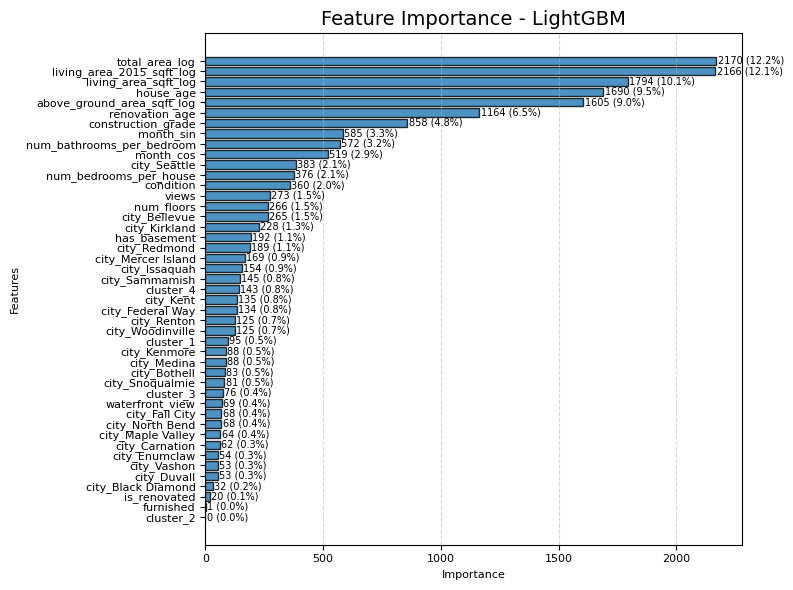

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure feature importances and feature names align
feature_importances = best_lightgbm_model.feature_importances_
if len(feature_importances) != len(X_linear_train_scaled.columns):
    feature_names = X_linear_train_scaled.columns[:len(feature_importances)]
else:
    feature_names = X_linear_train_scaled.columns

# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Calculate percentage contribution for each feature
total_importance = importance_df['Importance'].sum()
importance_df['Percentage'] = (importance_df['Importance'] / total_importance) * 100

# Plot feature importance
plt.figure(figsize=(8, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='#1f77b4', edgecolor='black', alpha=0.8)
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.title('Feature Importance - LightGBM', fontsize=14, color='black')
plt.xlabel('Importance', fontsize=8, color='black')
plt.ylabel('Features', fontsize=8, color='black')
plt.tick_params(axis='both', labelsize=8, colors='black')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add value and percentage labels to the bars
for bar, percentage in zip(bars, importance_df['Percentage']):
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height() / 2,
             f'{width:.0f} ({percentage:.1f}%)',  # Add percentage to the label
             va='center', fontsize=7, color='black')

plt.tight_layout()

# Save and show the plot
plt.savefig(".\\images\\feature_importance_lightgbm_with_labels_and_percentage.svg", format="svg", dpi=300)
plt.show()